<a href="https://colab.research.google.com/github/alezakuskin/Stark_ML/blob/Ions/Main_body.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# StarkML: Machine Learning-based Tool for Predicting Stark Parameters of Atomic Emission Lines

# Imports

In [ ]:
!pip install pytorch-tabnet
!git clone -b Ions https://github.com/alezakuskin/Stark_ML

     ---------------------------------------- 0.0/14.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/14.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/14.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/14.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/14.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/14.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/14.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/14.8 MB ? eta -:--:--
     ---------------------------------------- 0.1/14.8 MB 1.1 MB/s eta 0:00:14
     ---------------------------------------- 0.1/14.8 MB 1.1 MB/s eta 0:00:14
     --------------------------------------- 0.1/14.8 MB 660.6 kB/s eta 0:00:23
     --------------------------------------- 0.1/14.8 MB 656.4 kB/s eta 0:00:23
     --------------------------------------- 0.1/14.8 MB 711.9 kB/s eta 0:00:21
      --------------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
shap 0.41.0 requires cloudpickle, which is not installed.
shap 0.41.0 requires numba, which is not installed.
shap 0.41.0 requires pandas, which is not installed.
rdkit 2022.9.5 requires Pillow, which is not installed.
optuna 3.1.1 requires PyYAML, which is not installed.
optuna 3.1.1 requires sqlalchemy>=1.3.0, which is not installed.
catboost 1.1.1 requires matplotlib, which is not installed.
catboost 1.1.1 requires pandas>=0.24.0, which is not installed.
catboost 1.1.1 requires plotly, which is not installed.


In [ ]:
RunInColab = 'google.colab' in str(get_ipython())
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

#Installing missing packages
!pip install optuna
!pip install catboost
!pip install xgboost
!pip install lightgbm

#Imports
import os
import stat
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import time
import importlib
import json
import torch
import lightgbm
#torch.autograd.set_detect_anomaly(False)
torch.set_default_tensor_type(torch.DoubleTensor)
torch.set_default_dtype(torch.float64)

#Importing sklearn models and metrics
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm
from sklearn.preprocessing import StandardScaler

#Importing TabNet Regressor model    
#from pytorch_tabnet.tab_model import  TabNetRegressor

np.random.seed(777)

import pytorch_tabnet
os.environ['tabnet'] = pytorch_tabnet.__path__.__dict__['_path'][0]
os.environ['patchfile'] = os.path.abspath(os.path.join('Stark_ML', 'float64.patch'))
if os.name == 'nt':
    !cd /d %tabnet% & patch < "%patchfile%"
else:
    !cd $tabnet && patch -f < $patchfile
importlib.reload(pytorch_tabnet)

if RunInColab:
    from google.colab import output
    def clear_output():
        output.clear()
else:
    from IPython import display
    def clear_output():
        display.clear_output()

clear_output()

In [ ]:
#Download and import all utilities and models
'''if os.path.isdir('Stark_ML'):
    import Stark_ML
    def remove_readonly(func, path, _):
            os.chmod(path, stat.S_IWRITE)
            func(path)
    shutil.rmtree(Stark_ML.__path__.__dict__['_path'][0], onerror = remove_readonly)

!git clone -b Temperature-tuning https://github.com/alezakuskin/Stark_ML'''

import Stark_ML
import Stark_ML.utils.optuning
import Stark_ML.models.base_models
import Stark_ML.utils.metrics
import Stark_ML.utils.terms
import Stark_ML.utils.testset
import Stark_ML.utils.plotting
import Stark_ML.models.tabnet

importlib.reload(Stark_ML.models.base_models)
importlib.reload(Stark_ML.utils.optuning)
importlib.reload(Stark_ML.utils.metrics)
importlib.reload(Stark_ML.utils.plotting)
importlib.reload(Stark_ML.models.tabnet)

from Stark_ML.models.base_models import *
from Stark_ML.utils.optuning import *
from Stark_ML.utils.metrics import *
from Stark_ML.utils.terms import *
from Stark_ML.utils.testset import *
from Stark_ML.utils.plotting import *
from Stark_ML.models.tabnet import *
from Stark_ML.utils import *
from pytorch_tabnet.tab_model import  TabNetRegressor
clear_output()

# Data preprocessing

In [ ]:
#Import data for training and testing
a_data = pd.read_excel(Stark_ML.__path__.__dict__['_path'][0] + '/Source_files/Stark_data.xlsx',
                     sheet_name='Experimental',
                     usecols='A:BC'
                   )
#Replace term symbols with quantum numbers
a_data['Term'] = term_to_number(data['Term'])
a_data['Term.1'] = term_to_number(data['Term.1'])

#Making sure that atoms and ions datasets have the same set of columns
for i, name in enumerate(data_i.columns):
    if name != a_data.columns[i]:
        if name in a_data.columns:
            print(f'renaming {name}')
            a_data = a_data.rename(columns = {name: name+'.1'})
        a_data.insert(i, data_i.columns[i], 0)
        
a_data.insert(a_data.columns.get_loc('E upper')+1, 'Gap to ion', 0)
a_data['Gap to ion'] = gap_to_ion(a_data, 'E upper')

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\Alex\.conda\envs\TorchCUDAenv\lib\site-packages\pandas\compat\_optional.py", line 142, in import_optional_dependency
    except ImportError:
  File "C:\Users\Alex\.conda\envs\TorchCUDAenv\lib\importlib\__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1050, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1027, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1004, in _find_and_load_unlocked
ModuleNotFoundError: No module named 'openpyxl'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Alex\.conda\envs\TorchCUDAenv\lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Alex\AppData\Local\Temp\1\ipykernel_584\4086760037.py", line 2, in <module>
    d

In [ ]:
#Step 1.
#Exclude elements for testing
#Defining elements to exclude from training set
elements_to_exclude = ['S', 'Mg', 'Mn']

In [ ]:
#Step 2.
#Creating data, targets and labels for the process of width prediction
a_data_width = a_data[np.isnan(a_data['w (A)']) == False]
a_data_width_elements = a_data_width.loc[a_data_width['Element'].isin(elements_to_exclude)]
a_data_width = a_data_width.drop(a_data_width_elements.index)
a_data_width = a_data_width.sort_values(by=['Z number'])

#Separate targets from data
a_target_width = a_data_width['w (A)']
a_target_width_elements = a_data_width_elements['w (A)']

#Separate labels from data
a_label_width = a_data_width.loc[:, ['Element', 'Wavelength']]
a_label_width_elements = a_data_width_elements.loc[:, ['Element', 'Wavelength']]

#Remove width and shift values from data
a_data_width = a_data_width.drop(columns = ['d (A)', 'w (A)'])
a_data_width_elements = a_data_width_elements.drop(columns = ['d (A)', 'w (A)'])

In [ ]:
#Step 3.
#Split into train and test by quartiles
#Q1
data_test_q1, target_test_q1 = test_selection(a_data_width,
                                              a_target_width,
                                              p = 0.17,
                                              low_limit = 'min',
                                              up_limit = 25,
                                              random_state = 7)

#Q2
data_test_q2, target_test_q2 = test_selection(a_data_width,
                                              a_target_width,
                                              p = 0.17,
                                              low_limit = 25,
                                              up_limit = 50,
                                              random_state = 7)

#Q3
data_test_q3, target_test_q3 = test_selection(a_data_width,
                                              a_target_width,
                                              p = 0.17,
                                              low_limit = 50,
                                              up_limit = 75,
                                              random_state = 7)

#Q4
target_test_q4 = pd.Series()
while len(target_test_q4[target_test_q4 > 150]) < 1 or len(target_test_q4[(target_test_q4 > 70) & (target_test_q4 < 150)]) < 1:
    data_test_q4, target_test_q4 = test_selection(a_data_width,
                                                a_target_width,
                                                p = 0.17,
                                                low_limit = 75,
                                                random_state = None)

#manually selected and fixed random state that gives the closest train and test distributios  
data_test_q4, target_test_q4 = test_selection(a_data_width,
                                                a_target_width,
                                                p = 0.17,
                                                low_limit = 75,
                                                random_state = 6)

#print(target_test_q4[target_test_q4 > 70])

#Combining quartiles into full test dataset
a_data_width_test, a_target_width_test = pd.concat([data_test_q1, data_test_q2]), pd.concat([target_test_q1, target_test_q2])
a_data_width_test, a_target_width_test = pd.concat([a_data_width_test, data_test_q3]), pd.concat([a_target_width_test, target_test_q3])
a_data_width_test, a_target_width_test = pd.concat([a_data_width_test, data_test_q4]), pd.concat([a_target_width_test, target_test_q4])

#Remove test entries from data -> get train set
a_data_width_train, a_target_width_train = a_data_width.drop(a_data_width_test.index), a_target_width.drop(a_target_width_test.index)

C:\Users\Alex\AppData\Local\Temp\1\ipykernel_17728\2615308658.py:28: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [ ]:
#Step 4. Augmentation. Applied only to train set
factor = 1.05                                          #For every item with temperature T in data add two more items with T*factor and T/factor
a_data_width_train_extended = a_data_width_train.copy()
a_target_width_train_extended = a_target_width_train
for index, row in a_data_width_train.iterrows():
    row['T'] = row['T']*factor
    a_data_width_train_extended = pd.concat([a_data_width_train_extended, row.to_frame().T], ignore_index=True)
    a_target_width_train_extended = pd.concat([a_target_width_train_extended, pd.Series(a_target_width_train.loc[index])], ignore_index=True)

    row['T'] = row['T']/factor**2
    a_data_width_train_extended = pd.concat([a_data_width_train_extended, row.to_frame().T], ignore_index=True)
    a_target_width_train_extended = pd.concat([a_target_width_train_extended, pd.Series(a_target_width_train.loc[index])], ignore_index=True)
a_data_width_train_extended = a_data_width_train_extended.astype(a_data_width_train.dtypes.to_dict())

## -- *OPTIONAL*-- Width data visual description

In [ ]:
data_width.describe()

Wavelength    Z number          1s          2s          2p  \
count   897.000000  897.000000  897.000000  897.000000  897.000000   
mean    437.237659   14.851728    1.769231    1.612040    3.460424   
std     216.218894   15.978406    0.421560    0.737235    2.179154   
min     113.416500    2.000000    1.000000    0.000000    0.000000   
25%     283.999000    6.000000    2.000000    2.000000    1.000000   
50%     471.315614    7.000000    2.000000    2.000000    3.000000   
75%     541.520000   26.000000    2.000000    2.000000    6.000000   
max    2058.130000   82.000000    2.000000    2.000000    6.000000   

               3s          3p          3d          4s          4p  ...  \
count  897.000000  897.000000  897.000000  897.000000  897.000000  ...   
mean     0.858417    1.943144    2.469342    0.332219    0.749164  ...   
std      0.905723    2.720643    3.995171    0.687093    1.679233  ...   
min      0.000000    0.000000    0.000000    0.000000    0.000000  ...   
25%      0.000000    0.000000    0.000000    0.000000    0.000000  ...   
50%      1.000000    0.000000    0.000000    0.000000    0.000000  ...   
75%      2.000000    6.000000    7.000000    0.000000    1.000000  ...   
max      2.000000    6.000000   10.000000    2.000000    6.000000  ...   

               8p          8d          9s         10s  Multiplicity.1  \
count  897.000000  897.000000  897.000000  897.000000      897.000000   
mean     0.001115    0.002230    0.001115    0.001115        2.899666   
std      0.033389    0.047193    0.033389    0.033389        1.247752   
min      0.000000    0.000000    0.000000    0.000000        1.000000   
25%      0.000000    0.000000    0.000000    0.000000        2.000000   
50%      0.000000    0.000000    0.000000    0.000000        3.000000   
75%      0.000000    0.000000    0.000000    0.000000        4.000000   
max      1.000000    1.000000    1.000000    1.000000        7.000000   

           Term.1    Parity.1         J.1       E upper             T  
count  897.000000  897.000000  897.000000  8.970000e+02    897.000000  
mean     1.544036    0.603122    1.827202  2.113072e+05  16462.332219  
std      1.312079    0.489523    1.432334  3.325359e+06   9439.627870  
min      0.000000    0.000000    0.000000  1.173231e+04   2950.000000  
25%      1.000000    0.000000    1.000000  5.387426e+04  10970.000000  
50%      1.000000    1.000000    1.500000  8.848342e+04  12500.000000  
75%      2.000000    1.000000    2.000000  1.184278e+05  20800.000000  
max      5.000000    1.000000    7.000000  9.968131e+07  50000.000000  

[8 rows x 52 columns]

In [ ]:
data_width_stats = target_width.describe()
print(data_width_stats)

count    897.000000
mean       4.564198
std       12.780995
min        0.001500
25%        0.204444
50%        1.451247
75%        4.016393
max      180.500000
Name: w (A), dtype: float64


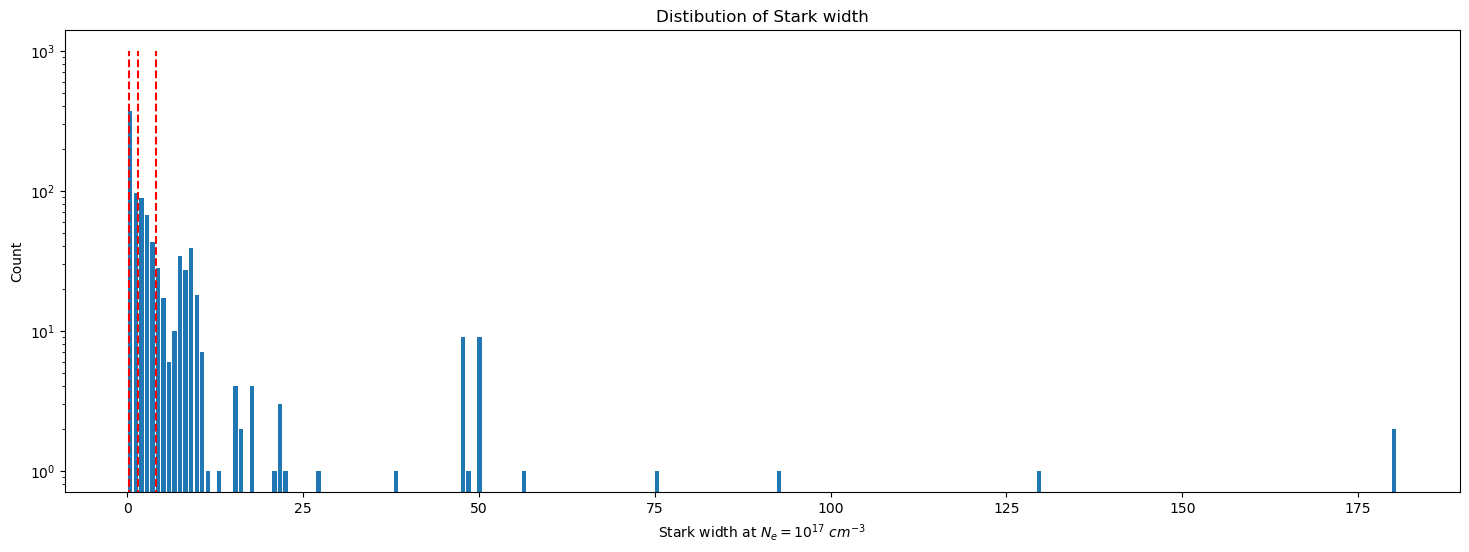

In [ ]:
fig, ax = plt.subplots(figsize = (18, 6))
n, bins, patches = plt.hist(target_width, bins='auto', log=True, rwidth = 0.8)
ax.vlines(x = data_width_stats['25%'], ymin = 0, ymax = 1000, ls='--', colors='r')
ax.vlines(x = data_width_stats['50%'], ymin = 0, ymax = 1000, ls='--', colors='r')
ax.vlines(x = data_width_stats['75%'], ymin = 0, ymax = 1000, ls='--', colors='r')

ax.set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
ax.set_ylabel('Count')
ax.set_title('Distibution of Stark width')

plt.show()

#plt.savefig('Width distribution.png', dpi = 300)

C:\Users\Alex\AppData\Local\Temp\1\ipykernel_17728\248873214.py:19: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[1, 0].get_shared_x_axes().join(axs[0, 0], axs[1, 0])
C:\Users\Alex\AppData\Local\Temp\1\ipykernel_17728\248873214.py:20: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[1, 1].get_shared_x_axes().join(axs[0, 1], axs[1, 1])
C:\Users\Alex\AppData\Local\Temp\1\ipykernel_17728\248873214.py:21: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[3, 0].get_shared_x_axes().join(axs[2, 0], axs[3, 0])
C:\Users\Alex\AppData\Local\Temp\1\ipykernel_17728\248873214.py:22: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[3, 1].get_shared_x_axes().join(axs[2,

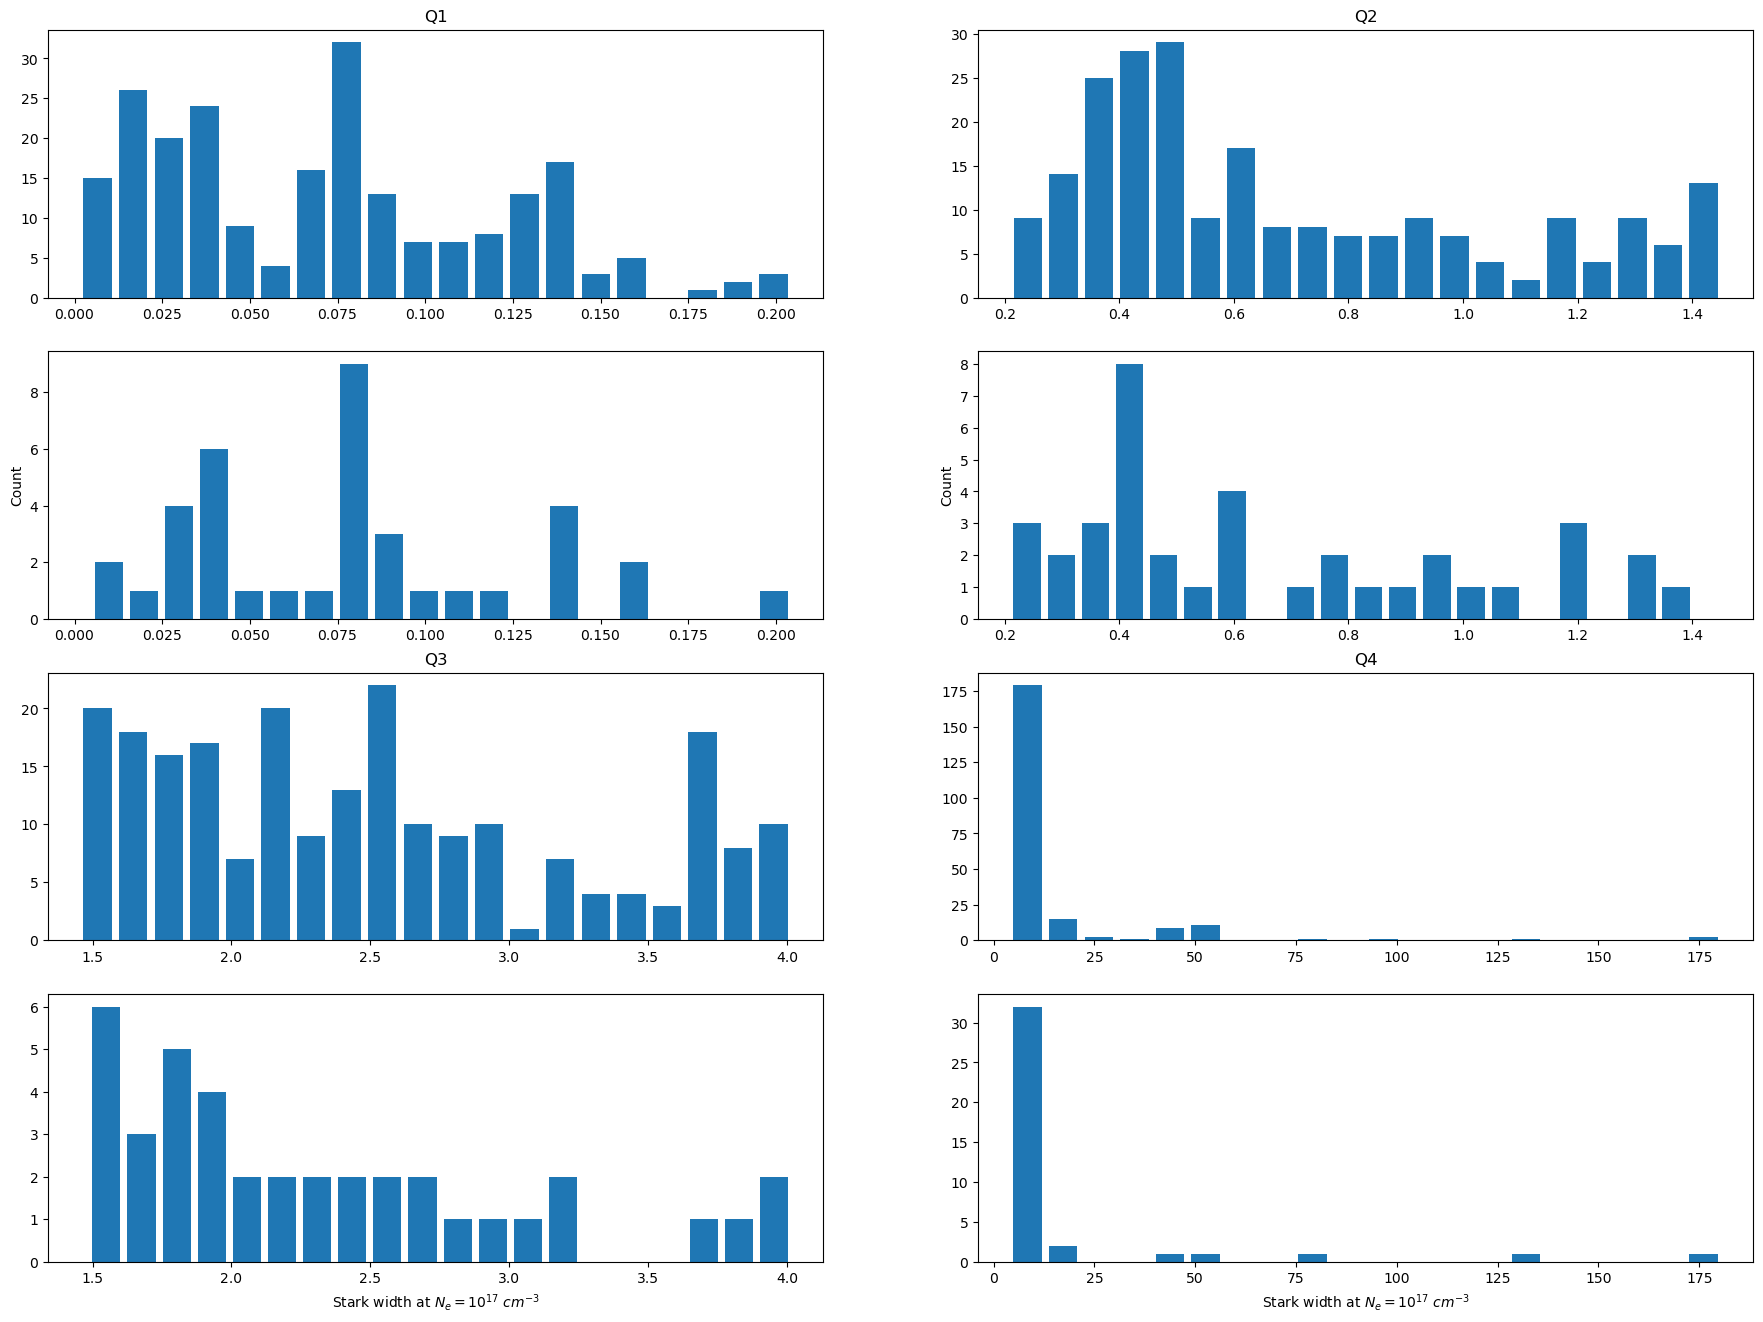

In [ ]:
#Plotting train-test distributions
fig, axs = plt.subplots(4, 2, figsize = (22, 16), sharex = False)

axs[0, 0].hist(target_width[target_width <= data_width_stats['25%']], bins=20, log=False, rwidth = 0.8)
axs[1, 0].hist(target_test_q1, bins = 20, rwidth = 0.8)

axs[0, 1].hist(target_width[(target_width > data_width_stats['25%']) & (target_width <= data_width_stats['50%'])],
                            bins=20, log=False, rwidth = 0.8)
axs[1, 1].hist(target_test_q2, bins = 20, rwidth = 0.8)

axs[2, 0].hist(target_width[(target_width > data_width_stats['50%']) & (target_width <= data_width_stats['75%'])],
                            bins=20, log=False, rwidth = 0.8)
axs[3, 0].hist(target_test_q3, bins = 20, rwidth = 0.8)

axs[2, 1].hist(target_width[target_width > data_width_stats['75%']],
                            bins=20, log=False, rwidth = 0.8)
axs[3, 1].hist(target_test_q4, bins = 20, rwidth = 0.8)

axs[1, 0].get_shared_x_axes().join(axs[0, 0], axs[1, 0])
axs[1, 1].get_shared_x_axes().join(axs[0, 1], axs[1, 1])
axs[3, 0].get_shared_x_axes().join(axs[2, 0], axs[3, 0])
axs[3, 1].get_shared_x_axes().join(axs[2, 1], axs[3, 1])

axs[0, 0].set_title('Q1')
axs[2, 0].set_title('Q3')
axs[0, 1].set_title('Q2')
axs[2, 1].set_title('Q4')
axs[1, 0].set_ylabel('Count')
axs[1, 1].set_ylabel('Count')
axs[3, 0].set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
axs[3, 1].set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
plt.show()

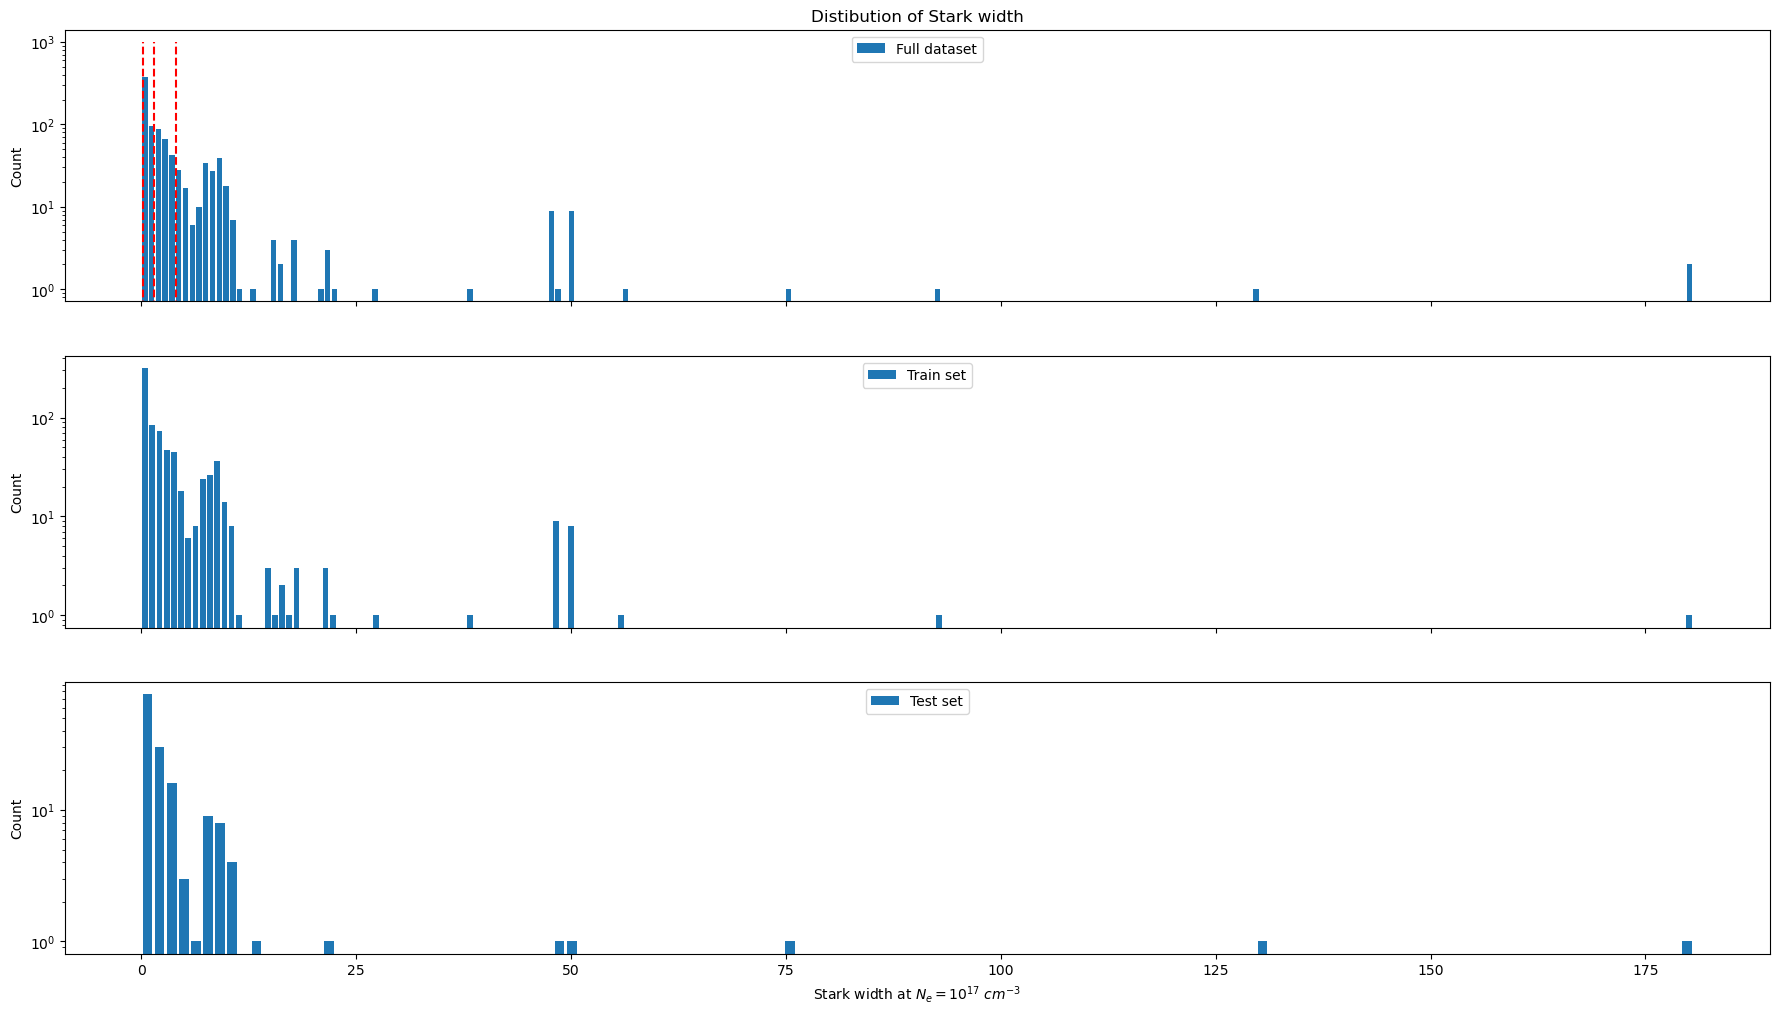

In [ ]:
test_width_stats = target_width_test.describe()

fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = True)
axs[0].hist(target_width, bins='auto', log=True, rwidth = 0.8, label = 'Full dataset')
axs[1].hist(target_width_train, bins = 'auto', log = True, rwidth = 0.8, label = 'Train set')
axs[2].hist(target_width_test, bins = 'auto', log = True, rwidth = 0.8, label = 'Test set')


axs[0].vlines(x = data_width_stats['25%'], ymin = 0, ymax = 1000, ls='--', colors='r')
axs[0].vlines(x = data_width_stats['50%'], ymin = 0, ymax = 1000, ls='--', colors='r')
axs[0].vlines(x = data_width_stats['75%'], ymin = 0, ymax = 1000, ls='--', colors='r')
'''axs[1].vlines(x = test_width_stats['25%'], ymin = 0, ymax = 100, ls='--', colors='r')
axs[1].vlines(x = test_width_stats['50%'], ymin = 0, ymax = 100, ls='--', colors='r')
axs[1].vlines(x = test_width_stats['75%'], ymin = 0, ymax = 100, ls='--', colors='r')
'''
axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')
axs[2].set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
axs[0].set_ylabel('Count')
axs[1].set_ylabel('Count')
axs[2].set_ylabel('Count')
axs[0].set_title('Distibution of Stark width')

plt.show()

#plt.savefig('Width distribution.png', dpi = 300)

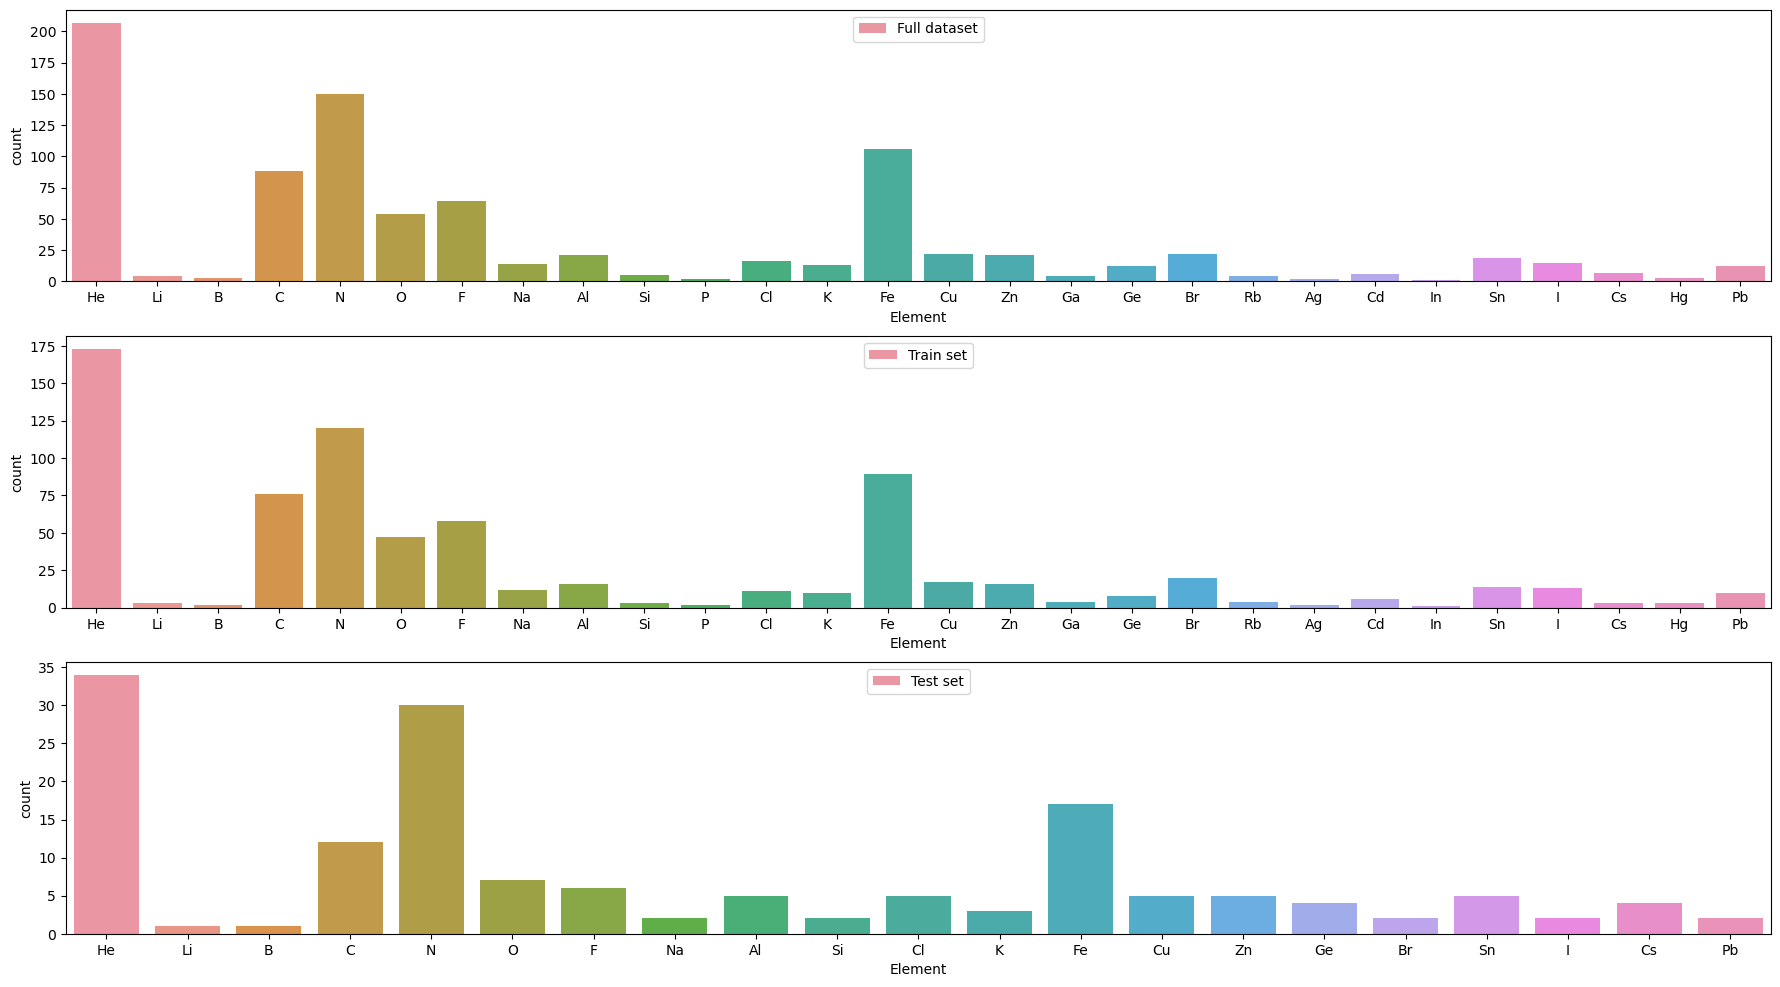

In [ ]:
fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = False)
sns.countplot(data = data_width, x = 'Element',  ax = axs[0], label = 'Full dataset')
sns.countplot(data = data_width_train.sort_values(by = ['Z number']), x = 'Element',  ax = axs[1], label = 'Train set')
sns.countplot(data = data_width_test.sort_values(by = ['Z number']), x = 'Element', ax = axs[2], label = 'Test set')

axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')

plt.show()

# Shift data preprocessing

In [ ]:
#Creating data, target and labels for shift prediction
data_shift = data[np.isnan(data['d (A)']) == False]
data_shift_elements = data_shift.loc[data_shift['Element'].isin(elements_to_exclude)]
data_shift = data_shift.drop(data_shift_elements.index)
data_shift = data_shift.sort_values(by=['Z number'])
target_shift = data_shift['d (A)']
label_shift = data_shift.loc[:, ['Element', 'Wavelength']]
data_shift = data_shift.drop(columns = ['w (A)', 'd (A)'])
target_shift_elements = data_shift_elements['w (A)']
label_shift_elements = data_shift_elements.loc[:, ['Element', 'Wavelength']]

In [ ]:
#Split into train and test by quartiles
#Q1
data_test_q1, target_test_q1 = test_selection(data_shift,
                                              target_shift,
                                              p = 0.17,
                                              low_limit = 'min',
                                              up_limit = 25,
                                              random_state = 7)

#Q2
data_test_q2, target_test_q2 = test_selection(data_shift,
                                              target_shift,
                                              p = 0.17,
                                              low_limit = 25,
                                              up_limit = 50,
                                              random_state = 7)

#Q3
data_test_q3, target_test_q3 = test_selection(data_shift,
                                              target_shift,
                                              p = 0.17,
                                              low_limit = 50,
                                              up_limit = 75,
                                              random_state = 7)

#Q4
target_test_q4 = pd.Series()
while len(target_test_q4[target_test_q4 > 17.5]) < 1 or len(target_test_q4[(target_test_q4 > 11.5) & (target_test_q4 < 17.5)]) < 1:
    data_test_q4, target_test_q4 = test_selection(data_shift,
                                                target_shift,
                                                p = 0.17,
                                                low_limit = 75,
                                                random_state = None)

#Merging full train and test datasets
data_shift_test, target_shift_test = pd.concat([data_test_q1, data_test_q2]), pd.concat([target_test_q1, target_test_q2])
data_shift_test, target_shift_test = pd.concat([data_shift_test, data_test_q3]), pd.concat([target_shift_test, target_test_q3])
data_shift_test, target_shift_test = pd.concat([data_shift_test, data_test_q4]), pd.concat([target_shift_test, target_test_q4])

data_shift_train, target_shift_train = data_shift.drop(data_shift_test.index), target_shift.drop(target_shift_test.index)

C:\Users\Alex\AppData\Local\Temp\1\ipykernel_17728\3391233251.py:27: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  target_test_q4 = pd.Series()


## -- *OPTIONAL*-- Shift data visual description 

In [ ]:
data_shift.describe()

Wavelength    Z number          1s          2s          2p          3s  \
count  331.000000  331.000000  331.000000  331.000000  331.000000  331.000000   
mean   479.888947   14.045317    1.740181    1.531722    3.308157    0.737160   
std    192.056662   17.933067    0.439199    0.802301    2.162047    0.853039   
min    119.955000    2.000000    1.000000    0.000000    0.000000    0.000000   
25%    391.633000    2.000000    1.000000    1.000000    1.000000    0.000000   
50%    501.568000    8.000000    2.000000    2.000000    3.000000    0.000000   
75%    589.200750   13.000000    2.000000    2.000000    6.000000    2.000000   
max    852.112000   82.000000    2.000000    2.000000    6.000000    2.000000   

               3p          3d          4s          4p  ...          8p     8d  \
count  331.000000  331.000000  331.000000  331.000000  ...  331.000000  331.0   
mean     1.435045    1.797583    0.314199    0.749245  ...    0.003021    0.0   
std      2.371135    3.775294    0.694837    1.845705  ...    0.054965    0.0   
min      0.000000    0.000000    0.000000    0.000000  ...    0.000000    0.0   
25%      0.000000    0.000000    0.000000    0.000000  ...    0.000000    0.0   
50%      0.000000    0.000000    0.000000    0.000000  ...    0.000000    0.0   
75%      1.000000    0.000000    0.000000    0.000000  ...    0.000000    0.0   
max      6.000000   10.000000    2.000000    6.000000  ...    1.000000    0.0   

          9s    10s  Multiplicity.1      Term.1    Parity.1         J.1  \
count  331.0  331.0      331.000000  331.000000  331.000000  331.000000   
mean     0.0    0.0        2.764350    1.187311    0.555891    1.480363   
std      0.0    0.0        1.114123    0.864075    0.497619    0.999428   
min      0.0    0.0        1.000000    0.000000    0.000000    0.000000   
25%      0.0    0.0        2.000000    1.000000    0.000000    1.000000   
50%      0.0    0.0        3.000000    1.000000    1.000000    1.500000   
75%      0.0    0.0        3.000000    2.000000    1.000000    2.000000   
max      0.0    0.0        7.000000    5.000000    1.000000    7.000000   

            E upper             T  
count  3.310000e+02    331.000000  
mean   4.027146e+05  17826.404834  
std    5.473695e+06   9920.444183  
min    1.173231e+04   3800.000000  
25%    5.375643e+04  11000.000000  
50%    9.966391e+04  15000.000000  
75%    1.832368e+05  22700.000000  
max    9.968131e+07  49000.000000  

[8 rows x 52 columns]

count    331.000000
mean       2.034925
std        3.704571
min       -7.485437
25%        0.037200
50%        0.290000
75%        2.881356
max       20.000000
Name: d (A), dtype: float64


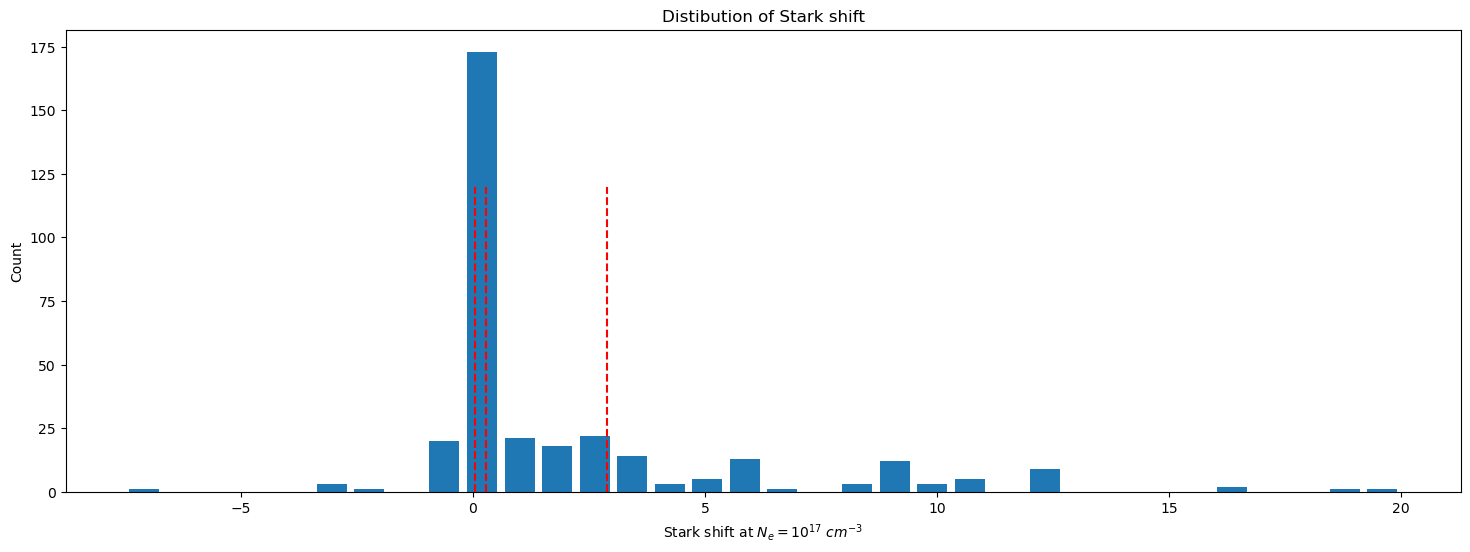

In [ ]:
data_shift_stats = target_shift.describe()
print(data_shift_stats)

fig, ax = plt.subplots(figsize = (18, 6))
n, bins, patches = plt.hist(target_shift, bins='auto', log=False, rwidth = 0.8)
ax.vlines(x = data_shift_stats['25%'], ymin = 0, ymax = 120, ls='--', colors='r')
ax.vlines(x = data_shift_stats['50%'], ymin = 0, ymax = 120, ls='--', colors='r')
ax.vlines(x = data_shift_stats['75%'], ymin = 0, ymax = 120, ls='--', colors='r')

ax.set_xlabel('Stark shift at $N_e = 10^{17}$ $cm^{-3}$')
ax.set_ylabel('Count')
ax.set_title('Distibution of Stark shift')

plt.show()

#plt.savefig('Shift distribution.png', dpi = 300)

C:\Users\Alex\AppData\Local\Temp\1\ipykernel_17728\3858759292.py:18: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[1, 0].get_shared_x_axes().join(axs[0, 0], axs[1, 0])
C:\Users\Alex\AppData\Local\Temp\1\ipykernel_17728\3858759292.py:19: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[1, 1].get_shared_x_axes().join(axs[0, 1], axs[1, 1])
C:\Users\Alex\AppData\Local\Temp\1\ipykernel_17728\3858759292.py:20: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[3, 0].get_shared_x_axes().join(axs[2, 0], axs[3, 0])
C:\Users\Alex\AppData\Local\Temp\1\ipykernel_17728\3858759292.py:21: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[3, 1].get_shared_x_axes().join(ax

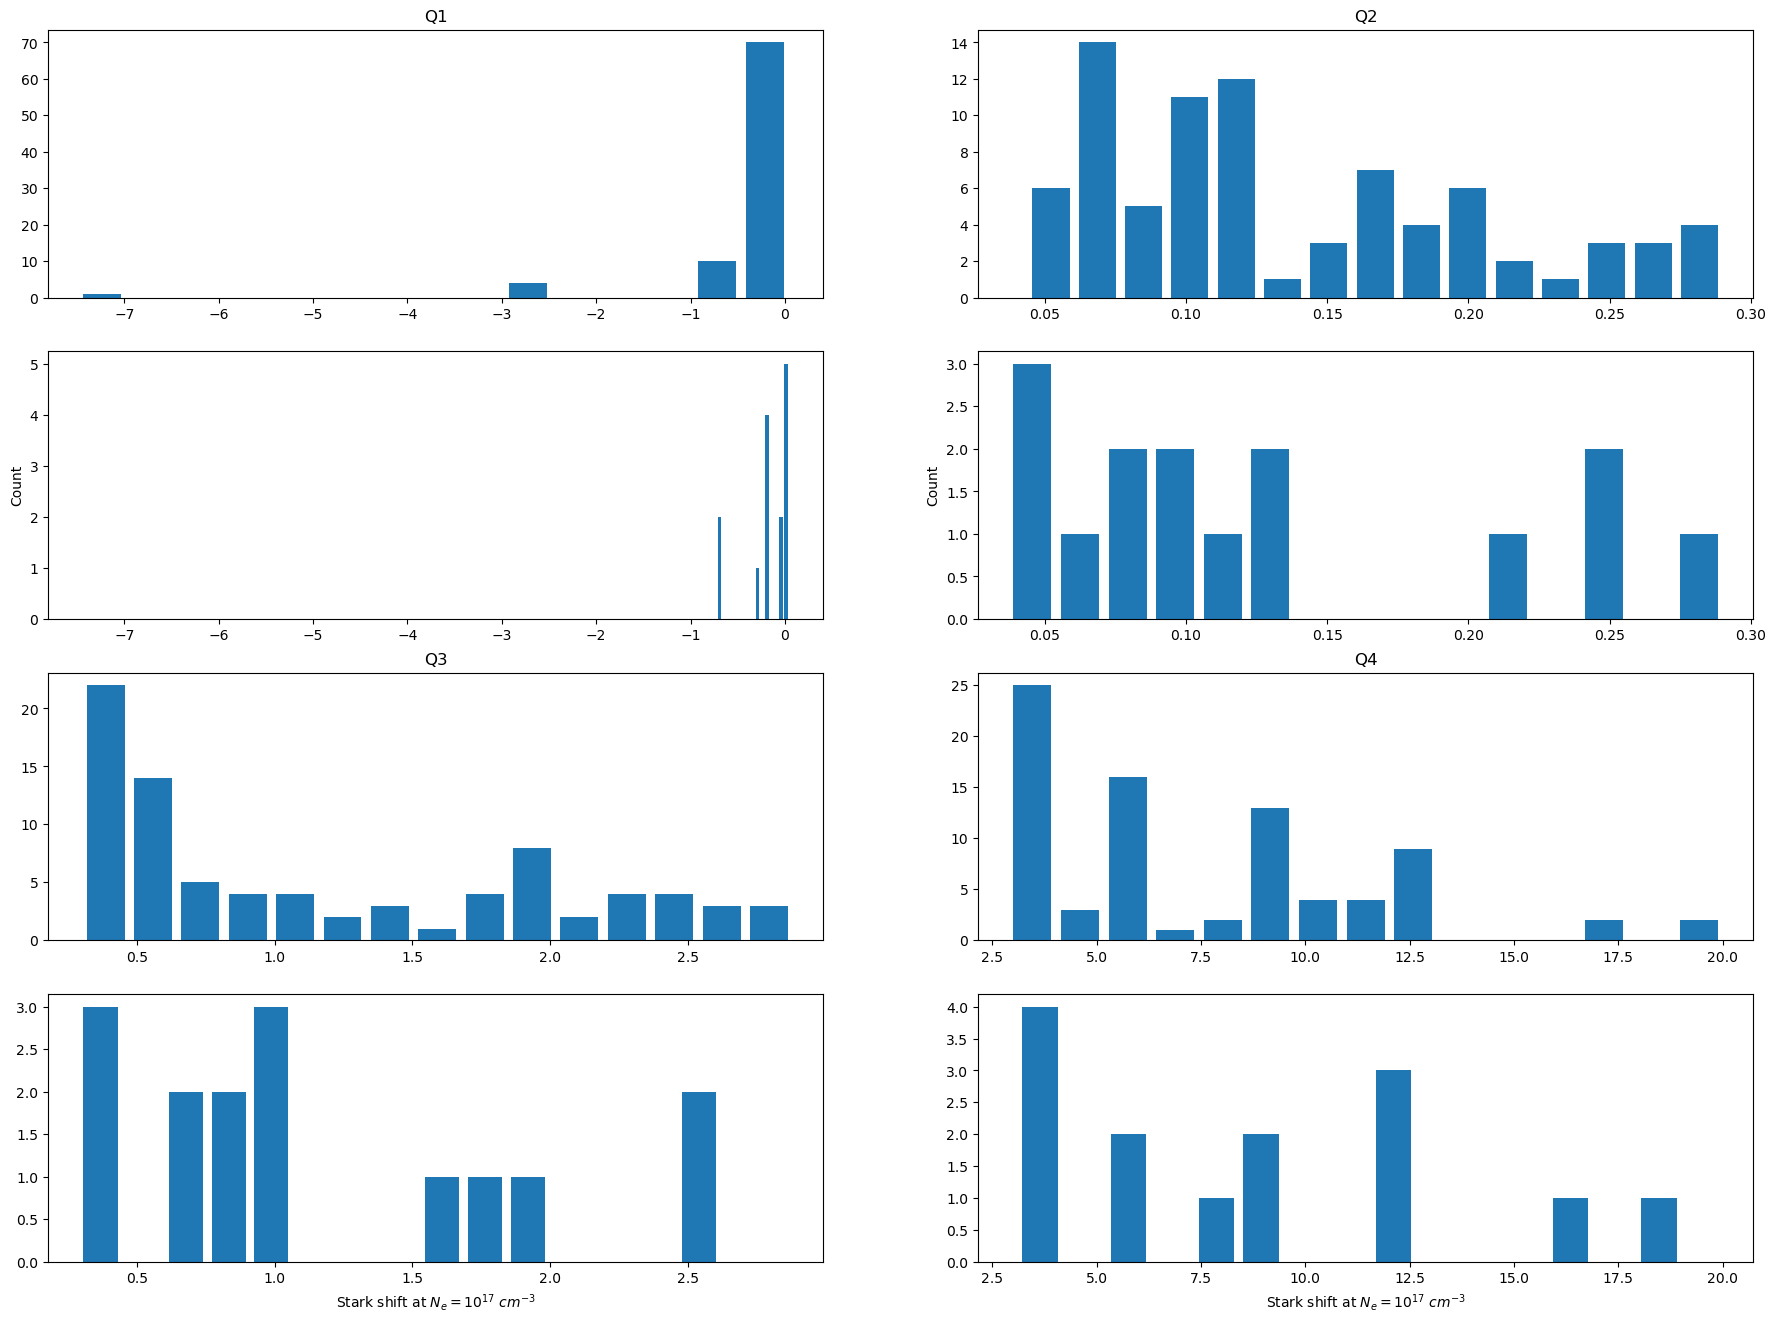

In [ ]:
fig, axs = plt.subplots(4, 2, figsize = (22, 16), sharex = False)

axs[0, 0].hist(target_shift[target_shift <= data_shift_stats['25%']], bins=15, log=False, rwidth = 0.8)
axs[1, 0].hist(target_test_q1, bins = 15, rwidth = 0.8)

axs[0, 1].hist(target_shift[(target_shift > data_shift_stats['25%']) & (target_shift <= data_shift_stats['50%'])],
                            bins=15, log=False, rwidth = 0.8)
axs[1, 1].hist(target_test_q2, bins = 15, rwidth = 0.8)

axs[2, 0].hist(target_shift[(target_shift > data_shift_stats['50%']) & (target_shift <= data_shift_stats['75%'])],
                            bins=15, log=False, rwidth = 0.8)
axs[3, 0].hist(target_test_q3, bins = 15, rwidth = 0.8)

axs[2, 1].hist(target_shift[target_shift > data_shift_stats['75%']],
                            bins=15, log=False, rwidth = 0.8)
axs[3, 1].hist(target_test_q4, bins = 15, rwidth = 0.8)

axs[1, 0].get_shared_x_axes().join(axs[0, 0], axs[1, 0])
axs[1, 1].get_shared_x_axes().join(axs[0, 1], axs[1, 1])
axs[3, 0].get_shared_x_axes().join(axs[2, 0], axs[3, 0])
axs[3, 1].get_shared_x_axes().join(axs[2, 1], axs[3, 1])

axs[0, 0].set_title('Q1')
axs[2, 0].set_title('Q3')
axs[0, 1].set_title('Q2')
axs[2, 1].set_title('Q4')
axs[1, 0].set_ylabel('Count')
axs[1, 1].set_ylabel('Count')
axs[3, 0].set_xlabel('Stark shift at $N_e = 10^{17}$ $cm^{-3}$')
axs[3, 1].set_xlabel('Stark shift at $N_e = 10^{17}$ $cm^{-3}$')
plt.show()

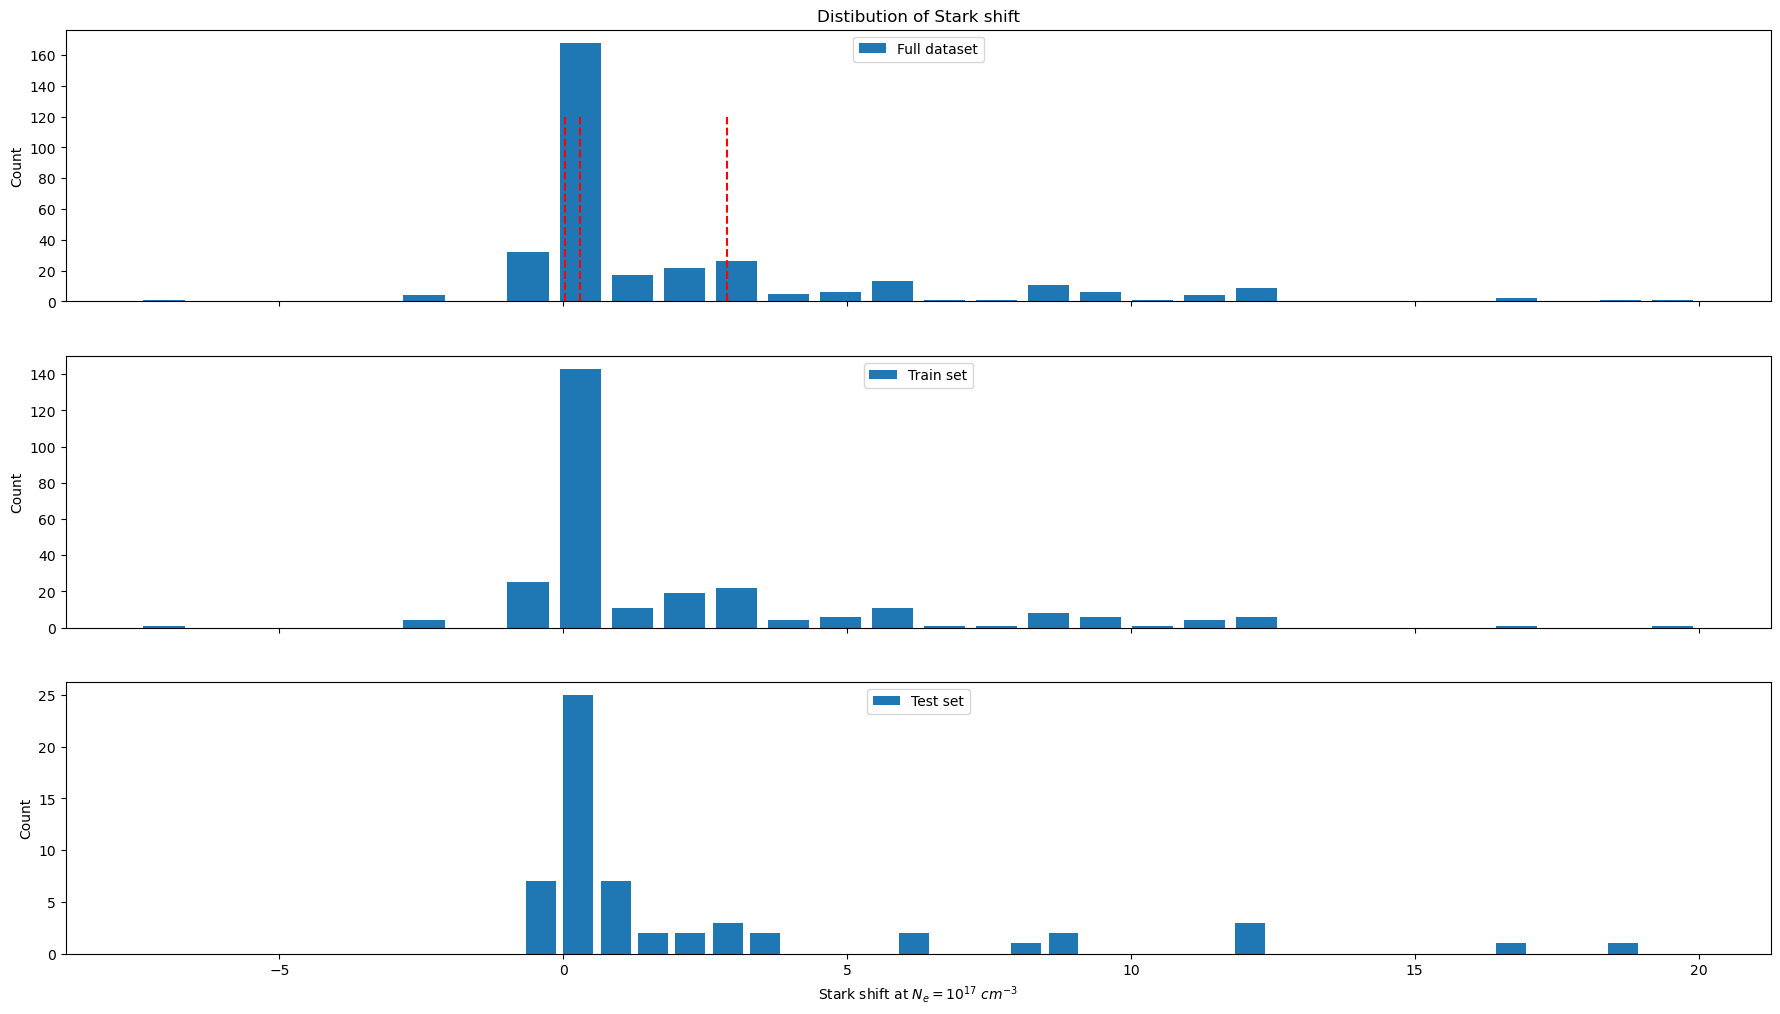

In [ ]:
test_shift_stats = target_shift_test.describe()

fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = True)
axs[0].hist(target_shift, bins=30, log=False, rwidth = 0.8, label = 'Full dataset')
axs[1].hist(target_shift_train, bins = 30, log = False, rwidth = 0.8, label = 'Train set')
axs[2].hist(target_shift_test, bins = 30, log = False, rwidth = 0.8, label = 'Test set')


axs[0].vlines(x = data_shift_stats['25%'], ymin = 0, ymax = 120, ls='--', colors='r')
axs[0].vlines(x = data_shift_stats['50%'], ymin = 0, ymax = 120, ls='--', colors='r')
axs[0].vlines(x = data_shift_stats['75%'], ymin = 0, ymax = 120, ls='--', colors='r')
'''axs[1].vlines(x = test_shift_stats['25%'], ymin = 0, ymax = 100, ls='--', colors='r')
axs[1].vlines(x = test_shift_stats['50%'], ymin = 0, ymax = 100, ls='--', colors='r')
axs[1].vlines(x = test_shift_stats['75%'], ymin = 0, ymax = 100, ls='--', colors='r')
'''
axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')
axs[2].set_xlabel('Stark shift at $N_e = 10^{17}$ $cm^{-3}$')
axs[0].set_ylabel('Count')
axs[1].set_ylabel('Count')
axs[2].set_ylabel('Count')
axs[0].set_title('Distibution of Stark shift')

plt.show()

#plt.savefig('shift distribution.png', dpi = 300)

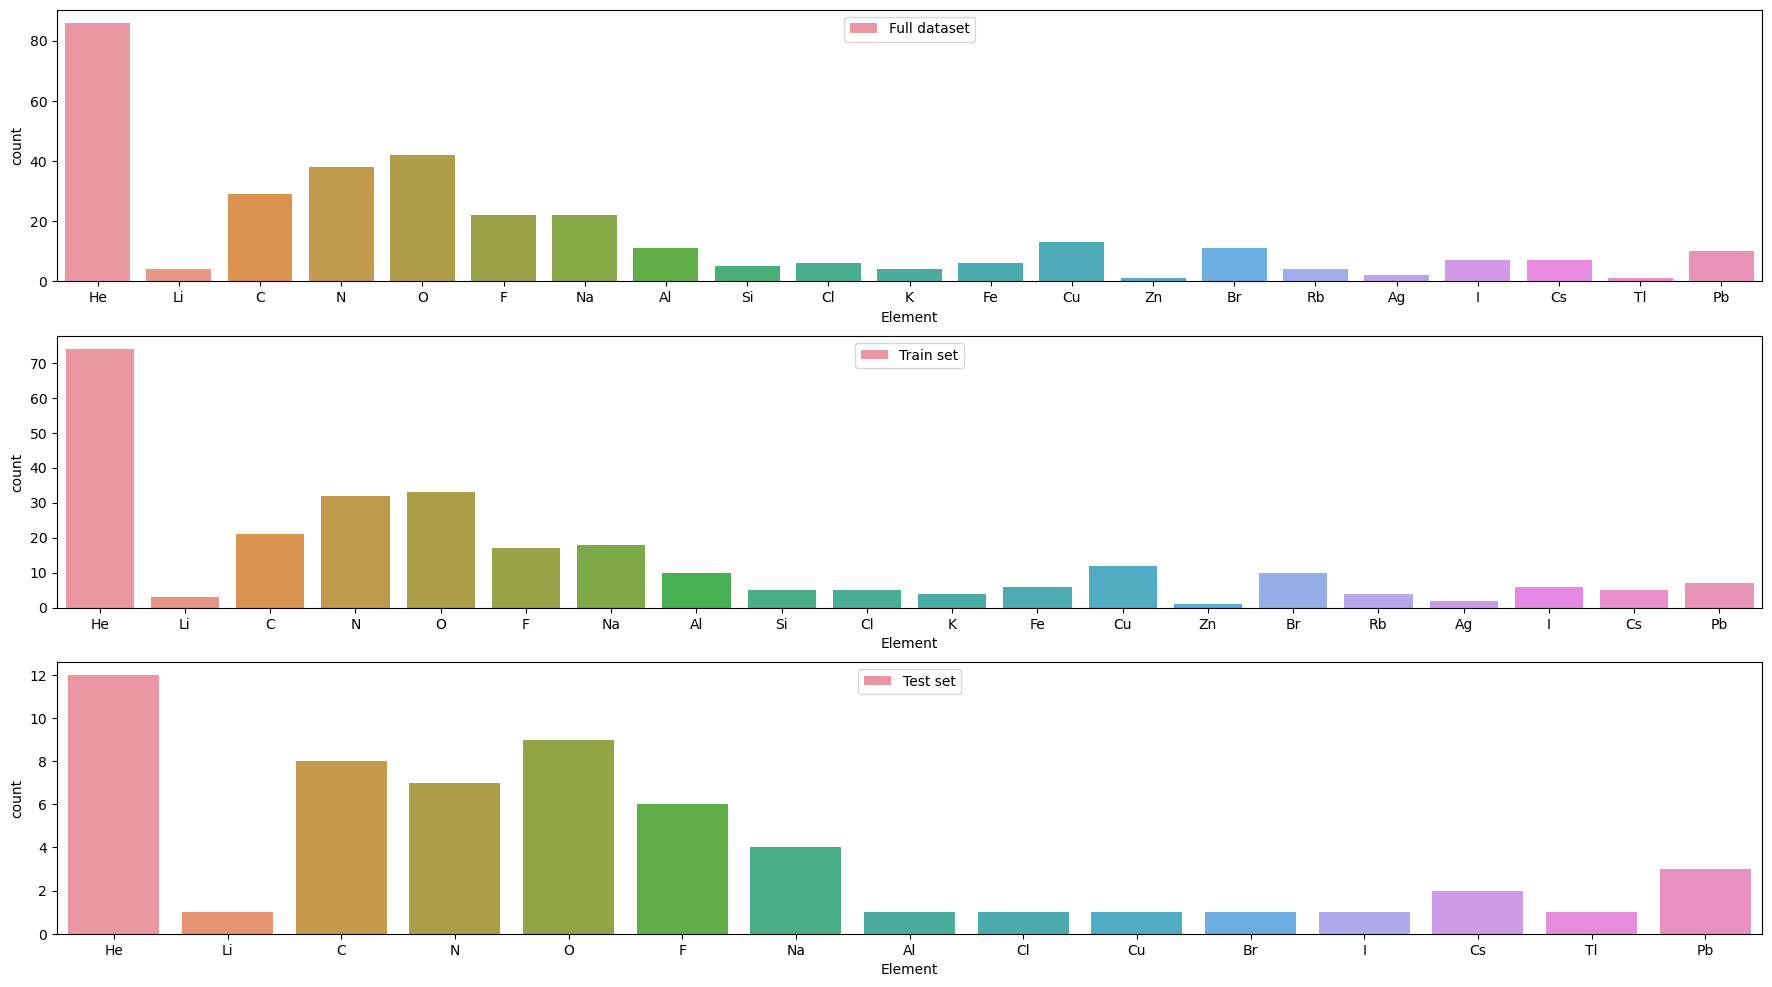

In [ ]:
fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = False)
sns.countplot(data = data_shift, x = 'Element',  ax = axs[0], label = 'Full dataset')
sns.countplot(data = data_shift_train.sort_values(by = ['Z number']), x = 'Element',  ax = axs[1], label = 'Train set')
sns.countplot(data = data_shift_test.sort_values(by = ['Z number']), x = 'Element', ax = axs[2], label = 'Test set')

axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')

plt.show()

# Ions data

In [ ]:
#Import data for training and testing
data_a = pd.read_excel(Stark_ML.__path__.__dict__['_path'][0] + '/Source_files/Stark_data.xlsx',
                     sheet_name='Experimental',
                     usecols='A:BD'
                   )
#Replace term symbols with quantum numbers
data_a['Term'] = term_to_number(data_a['Term'])
data_a['Term.1'] = term_to_number(data_a['Term.1'])

C:\Users\Alex\Documents\GitHub\Stark_ML\utils\terms.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

C:\Users\Alex\Documents\GitHub\Stark_ML\utils\terms.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [ ]:
#Import ions data for training and testing
data_i = pd.read_excel(Stark_ML.__path__.__dict__['_path'][0] + '/Source_files/Stark_data.xlsx',
                     sheet_name='Ions',
                     usecols='A:BM'
                   )
#Replace term symbols with quantum numbers
data_i['Term'] = term_to_number(data_i['Term'])
data_i['Term.1'] = term_to_number(data_i['Term.1'])

#Drop entries with levels' data unavailable
data_i = data_i[data_i['J'].notna()]

C:\Users\Alex\Documents\GitHub\Stark_ML\utils\terms.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

C:\Users\Alex\Documents\GitHub\Stark_ML\utils\terms.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [ ]:
#Making sure that atoms and ions datasets have the same set of columns
for i, name in enumerate(data_i.columns):
    if name != data_a.columns[i]:
        if name in data_a.columns:
            print(f'renaming {name}')
            data_a = data_a.rename(columns = {name: name+'.1'})
        data_a.insert(i, data_i.columns[i], 0)
        print(data_i.columns[i])

Charge
5f
renaming 6d
6d
renaming 7p
7p
5f.1
5g
6f
6g
11s


In [ ]:
#merging atoms and ions together
data = pd.concat([data_a, data_i], axis = 0, ignore_index = True)
data.insert(data.columns.get_loc('E upper')+1, 'Gap to ion', 0)
data['Gap to ion'] = gap_to_ion(data, 'E upper')

C:\Users\Alex\AppData\Local\Temp\1\ipykernel_5856\1058598635.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [ ]:
#Step 1.
#Exclude elements for testing
#Defining elements to exclude from training set
elements_to_exclude = ['S', 'Mg', 'Mn']

In [ ]:
#Step 2.
#Creating data, targets and labels for the process of width prediction
data_width = data[data['w (A)'].isna() == False]
data_width_elements = data_width.loc[data_width['Element'].isin(elements_to_exclude)]
data_width = data_width.drop(data_width_elements.index)
data_width = data_width.sort_values(by=['Z number'])

#Separate targets from data
target_width = data_width['w (A)']
target_width_elements = data_width_elements['w (A)']

#Separate labels from data
label_width = data_width.loc[:, ['Element', 'Wavelength']]
label_width_elements = data_width_elements.loc[:, ['Element', 'Wavelength']]

#Remove width and shift values from data
data_width = data_width.drop(columns = ['d (A)', 'w (A)'])
data_width_elements = data_width_elements.drop(columns = ['d (A)', 'w (A)'])

In [ ]:
#Step 3.
#Split into train and test by quartiles
#Q1
data_test_q1, target_test_q1 = test_selection(data_width,
                                              target_width,
                                              p = 0.17,
                                              low_limit = 'min',
                                              up_limit = 25,
                                              random_state = 7)

#Q2
data_test_q2, target_test_q2 = test_selection(data_width,
                                              target_width,
                                              p = 0.17,
                                              low_limit = 25,
                                              up_limit = 50,
                                              random_state = 7)

#Q3
data_test_q3, target_test_q3 = test_selection(data_width,
                                              target_width,
                                              p = 0.17,
                                              low_limit = 50,
                                              up_limit = 75,
                                              random_state = 7)

#Q4
target_test_q4 = pd.Series()
while len(target_test_q4[target_test_q4 > 150]) < 1 or len(target_test_q4[(target_test_q4 > 70) & (target_test_q4 < 150)]) < 1:
    data_test_q4, target_test_q4 = test_selection(data_width,
                                                target_width,
                                                p = 0.17,
                                                low_limit = 75,
                                                random_state = None)

#manually selected and fixed random state that gives the closest train and test distributios  
data_test_q4, target_test_q4 = test_selection(data_width,
                                                target_width,
                                                p = 0.17,
                                                low_limit = 75,
                                                random_state = 6)

#print(target_test_q4[target_test_q4 > 70])

#Combining quartiles into full test dataset
data_width_test, target_width_test = pd.concat([data_test_q1, data_test_q2]), pd.concat([target_test_q1, target_test_q2])
data_width_test, target_width_test = pd.concat([data_width_test, data_test_q3]), pd.concat([target_width_test, target_test_q3])
data_width_test, target_width_test = pd.concat([data_width_test, data_test_q4]), pd.concat([target_width_test, target_test_q4])

#Remove test entries from data -> get train set
data_width_train, target_width_train = data_width.drop(data_width_test.index), target_width.drop(target_width_test.index)

C:\Users\Alex\AppData\Local\Temp\1\ipykernel_5856\2615308658.py:28: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [ ]:
#Step 4. Augmentation. Applied only to train set
factor = 1.05                                          #For every item with temperature T in data add two more items with T*factor and T/factor
data_width_train_extended = data_width_train.copy()
target_width_train_extended = target_width_train
for index, row in data_width_train.iterrows():
    row['T'] = row['T']*factor
    data_width_train_extended = pd.concat([data_width_train_extended, row.to_frame().T], ignore_index=True)
    target_width_train_extended = pd.concat([target_width_train_extended, pd.Series(target_width_train.loc[index])], ignore_index=True)

    row['T'] = row['T']/factor**2
    data_width_train_extended = pd.concat([data_width_train_extended, row.to_frame().T], ignore_index=True)
    target_width_train_extended = pd.concat([target_width_train_extended, pd.Series(target_width_train.loc[index])], ignore_index=True)
data_width_train_extended = data_width_train_extended.astype(data_width_train.dtypes.to_dict())

## -- *OPTIONAL*-- Atoms + ions data visual description

In [ ]:
data_width_stats = target_width.describe()
print(data_width_stats)

count    3574.000000
mean        1.686131
std         6.748343
min         0.001500
25%         0.200000
50%         0.400000
75%         1.200000
max       180.500000
Name: w (A), dtype: float64


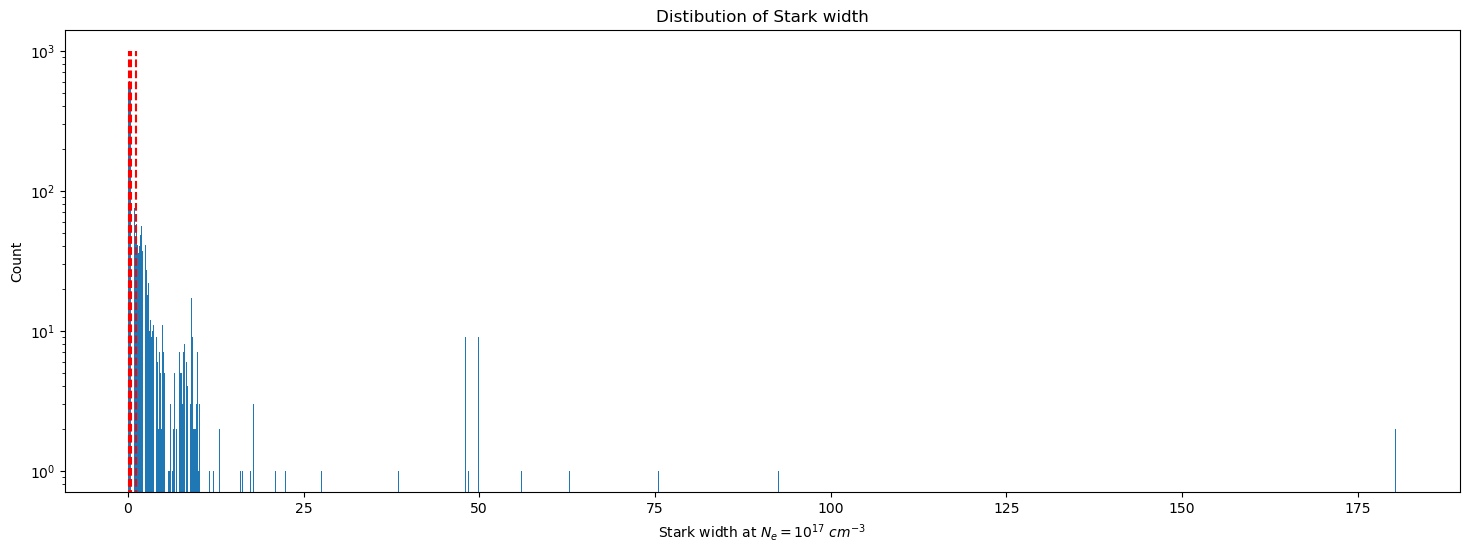

In [ ]:
fig, ax = plt.subplots(figsize = (18, 6))
n, bins, patches = plt.hist(target_width, bins='auto', log=True, rwidth = 0.8)
ax.vlines(x = data_width_stats['25%'], ymin = 0, ymax = 1000, ls='--', colors='r')
ax.vlines(x = data_width_stats['50%'], ymin = 0, ymax = 1000, ls='--', colors='r')
ax.vlines(x = data_width_stats['75%'], ymin = 0, ymax = 1000, ls='--', colors='r')

ax.set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
ax.set_ylabel('Count')
ax.set_title('Distibution of Stark width')

plt.show()

#plt.savefig('Width distribution.png', dpi = 300)

C:\Users\Alex\AppData\Local\Temp\1\ipykernel_17728\248873214.py:19: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[1, 0].get_shared_x_axes().join(axs[0, 0], axs[1, 0])
C:\Users\Alex\AppData\Local\Temp\1\ipykernel_17728\248873214.py:20: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[1, 1].get_shared_x_axes().join(axs[0, 1], axs[1, 1])
C:\Users\Alex\AppData\Local\Temp\1\ipykernel_17728\248873214.py:21: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[3, 0].get_shared_x_axes().join(axs[2, 0], axs[3, 0])
C:\Users\Alex\AppData\Local\Temp\1\ipykernel_17728\248873214.py:22: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[3, 1].get_shared_x_axes().join(axs[2,

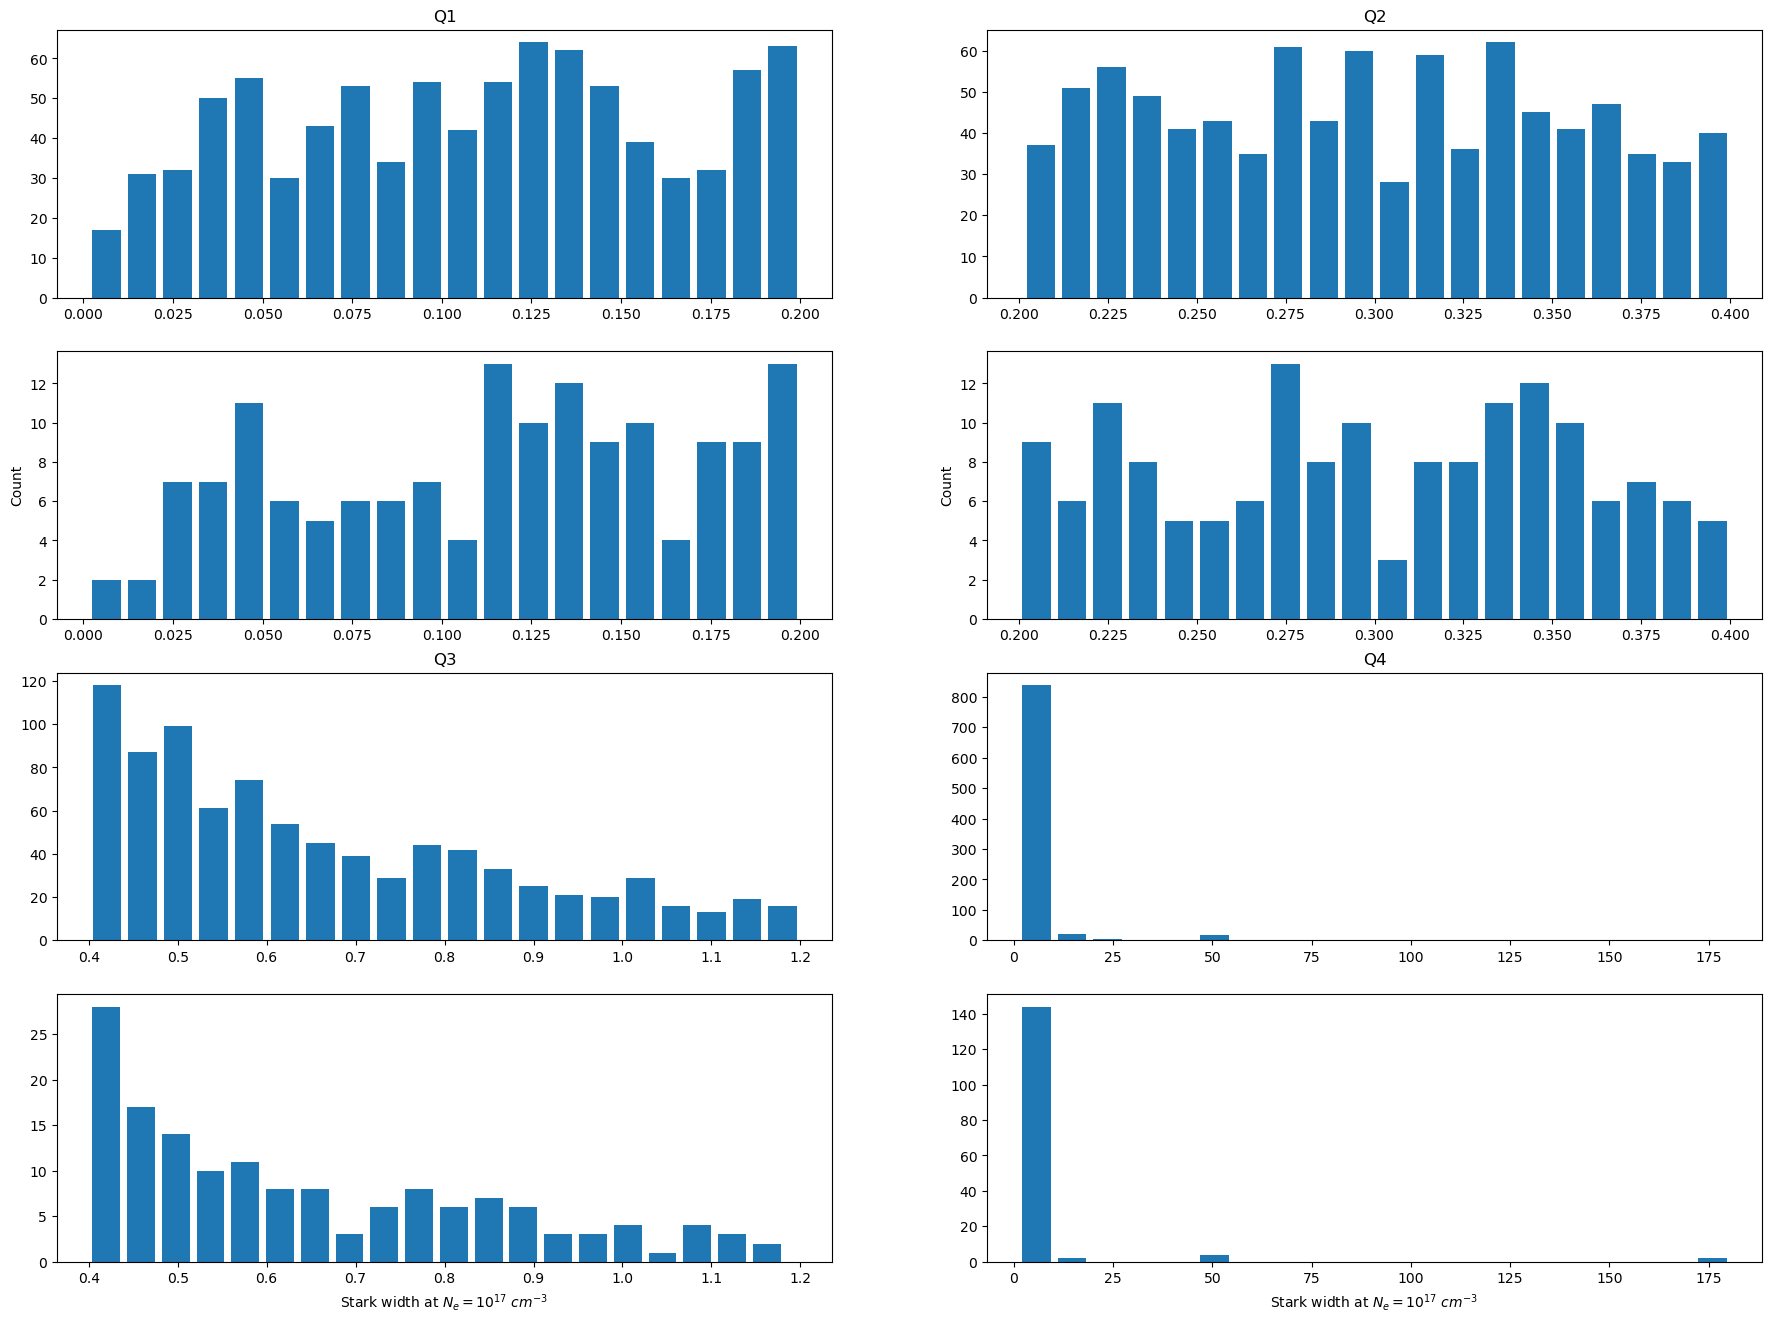

In [ ]:
#Plotting train-test distributions
fig, axs = plt.subplots(4, 2, figsize = (22, 16), sharex = False)

axs[0, 0].hist(target_width[target_width <= data_width_stats['25%']], bins=20, log=False, rwidth = 0.8)
axs[1, 0].hist(target_test_q1, bins = 20, rwidth = 0.8)

axs[0, 1].hist(target_width[(target_width > data_width_stats['25%']) & (target_width <= data_width_stats['50%'])],
                            bins=20, log=False, rwidth = 0.8)
axs[1, 1].hist(target_test_q2, bins = 20, rwidth = 0.8)

axs[2, 0].hist(target_width[(target_width > data_width_stats['50%']) & (target_width <= data_width_stats['75%'])],
                            bins=20, log=False, rwidth = 0.8)
axs[3, 0].hist(target_test_q3, bins = 20, rwidth = 0.8)

axs[2, 1].hist(target_width[target_width > data_width_stats['75%']],
                            bins=20, log=False, rwidth = 0.8)
axs[3, 1].hist(target_test_q4, bins = 20, rwidth = 0.8)

axs[1, 0].get_shared_x_axes().join(axs[0, 0], axs[1, 0])
axs[1, 1].get_shared_x_axes().join(axs[0, 1], axs[1, 1])
axs[3, 0].get_shared_x_axes().join(axs[2, 0], axs[3, 0])
axs[3, 1].get_shared_x_axes().join(axs[2, 1], axs[3, 1])

axs[0, 0].set_title('Q1')
axs[2, 0].set_title('Q3')
axs[0, 1].set_title('Q2')
axs[2, 1].set_title('Q4')
axs[1, 0].set_ylabel('Count')
axs[1, 1].set_ylabel('Count')
axs[3, 0].set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
axs[3, 1].set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
plt.show()

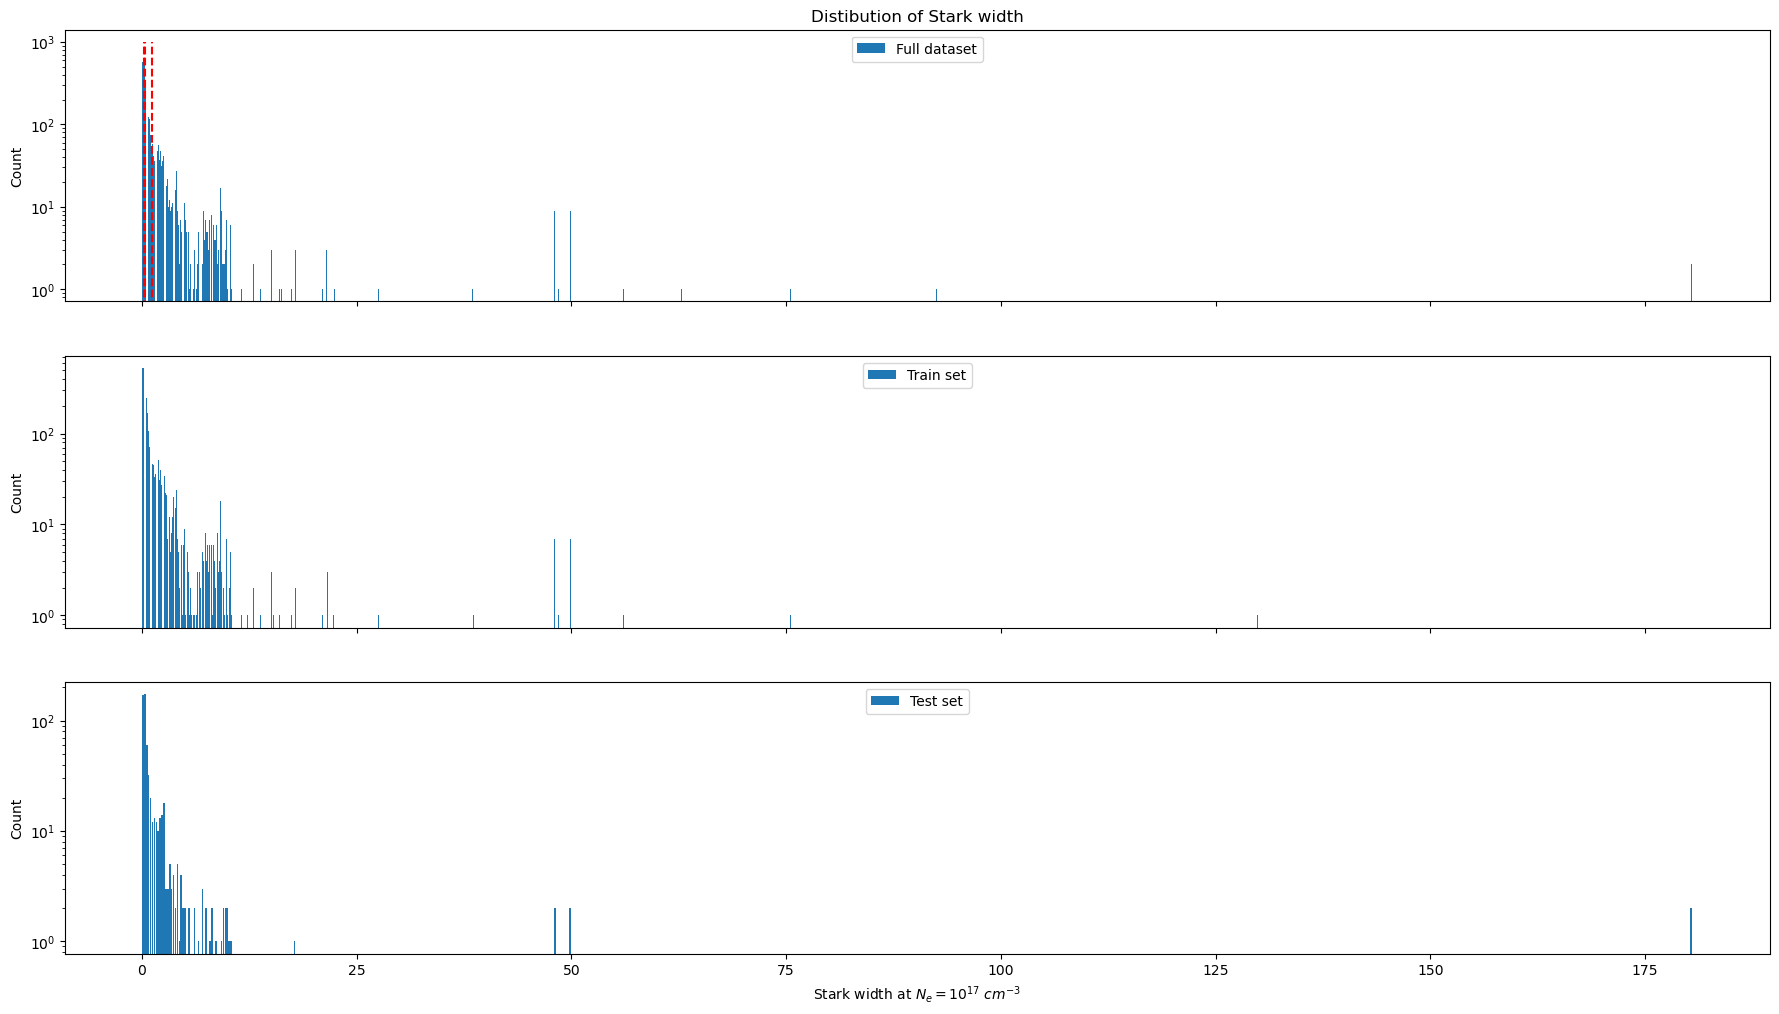

In [ ]:
test_width_stats = target_width_test.describe()

fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = True)
axs[0].hist(target_width, bins='auto', log=True, rwidth = 0.8, label = 'Full dataset')
axs[1].hist(target_width_train, bins = 'auto', log = True, rwidth = 0.8, label = 'Train set')
axs[2].hist(target_width_test, bins = 'auto', log = True, rwidth = 0.8, label = 'Test set')


axs[0].vlines(x = data_width_stats['25%'], ymin = 0, ymax = 1000, ls='--', colors='r')
axs[0].vlines(x = data_width_stats['50%'], ymin = 0, ymax = 1000, ls='--', colors='r')
axs[0].vlines(x = data_width_stats['75%'], ymin = 0, ymax = 1000, ls='--', colors='r')
'''axs[1].vlines(x = test_width_stats['25%'], ymin = 0, ymax = 100, ls='--', colors='r')
axs[1].vlines(x = test_width_stats['50%'], ymin = 0, ymax = 100, ls='--', colors='r')
axs[1].vlines(x = test_width_stats['75%'], ymin = 0, ymax = 100, ls='--', colors='r')
'''
axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')
axs[2].set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
axs[0].set_ylabel('Count')
axs[1].set_ylabel('Count')
axs[2].set_ylabel('Count')
axs[0].set_title('Distibution of Stark width')

plt.show()

#plt.savefig('Width distribution.png', dpi = 300)

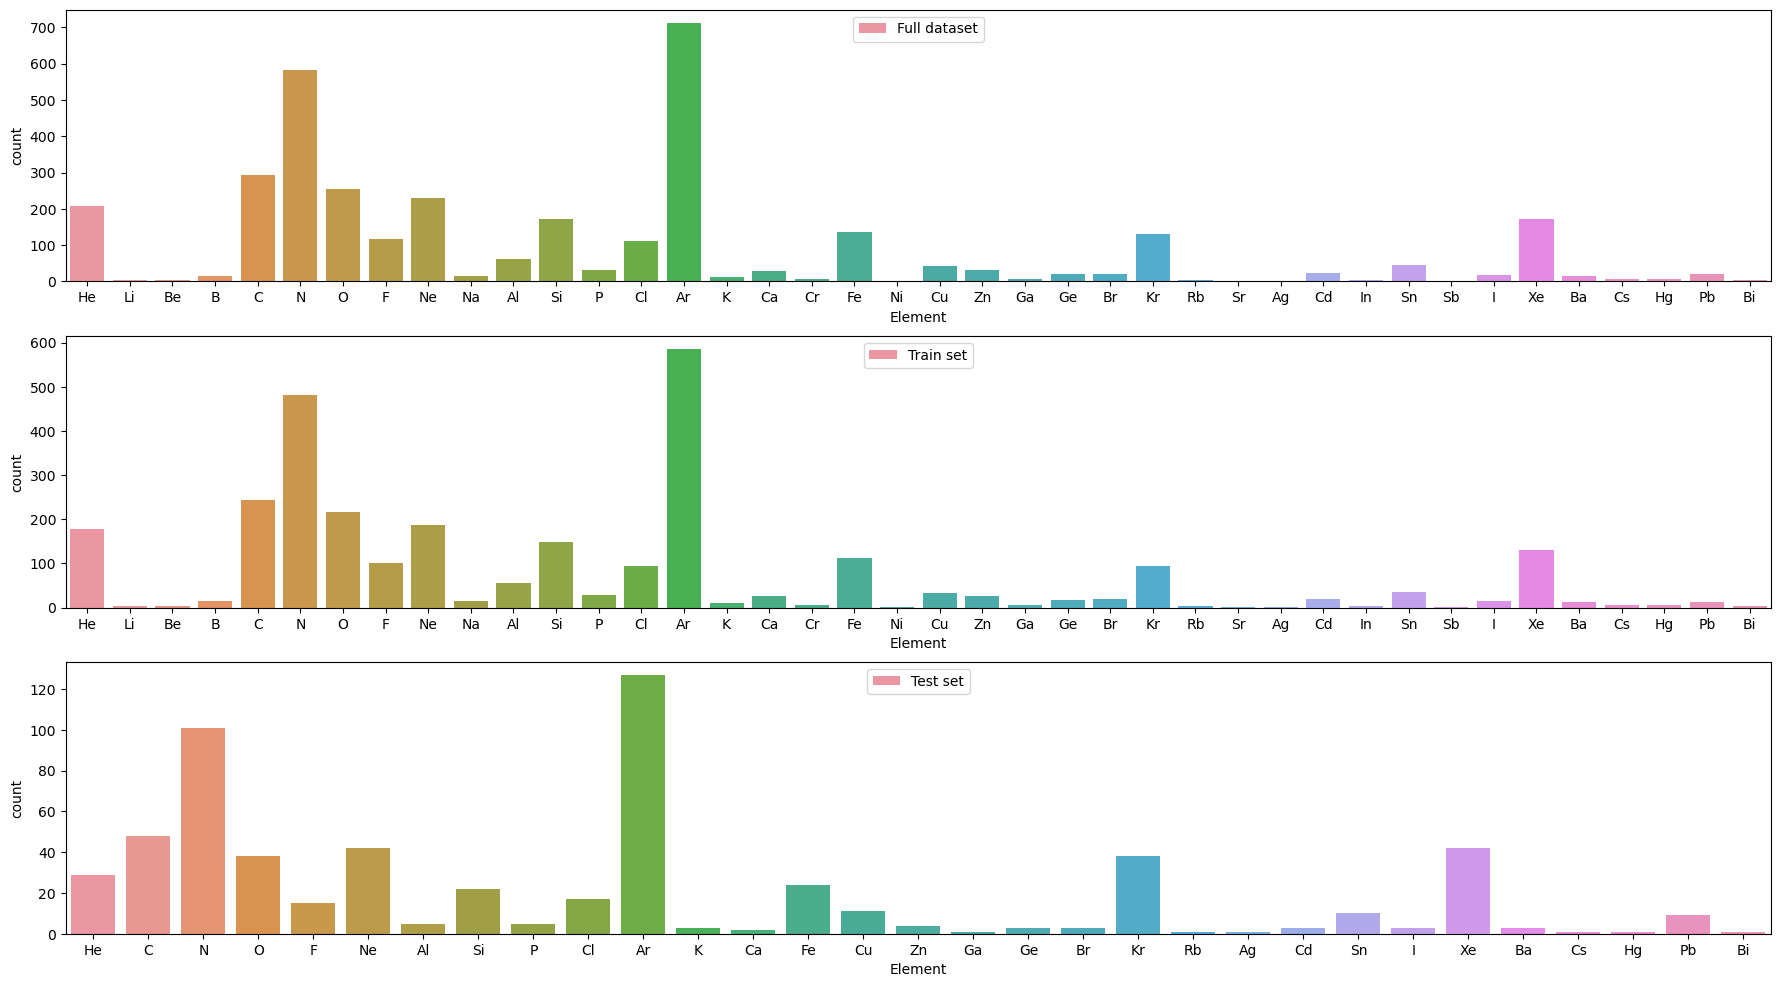

In [ ]:
fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = False)
sns.countplot(data = data_width, x = 'Element',  ax = axs[0], label = 'Full dataset')
sns.countplot(data = data_width_train.sort_values(by = ['Z number']), x = 'Element',  ax = axs[1], label = 'Train set')
sns.countplot(data = data_width_test.sort_values(by = ['Z number']), x = 'Element', ax = axs[2], label = 'Test set')

axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')

plt.show()

# Shift data preprocessing

In [ ]:
#Creating data, target and labels for shift prediction
data_shift = data[data['d (A)'].isna() == False]
data_shift_elements = data_shift.loc[data_shift['Element'].isin(elements_to_exclude)]
data_shift = data_shift.drop(data_shift_elements.index)
data_shift = data_shift.sort_values(by=['Z number'])
target_shift = data_shift['d (A)']
label_shift = data_shift.loc[:, ['Element', 'Wavelength']]
data_shift = data_shift.drop(columns = ['w (A)', 'd (A)'])
target_shift_elements = data_shift_elements['w (A)']
label_shift_elements = data_shift_elements.loc[:, ['Element', 'Wavelength']]

In [ ]:
#Split into train and test by quartiles
#Q1
data_test_q1, target_test_q1 = test_selection(data_shift,
                                              target_shift,
                                              p = 0.17,
                                              low_limit = 'min',
                                              up_limit = 25,
                                              random_state = 7)

#Q2
data_test_q2, target_test_q2 = test_selection(data_shift,
                                              target_shift,
                                              p = 0.17,
                                              low_limit = 25,
                                              up_limit = 50,
                                              random_state = 7)

#Q3
data_test_q3, target_test_q3 = test_selection(data_shift,
                                              target_shift,
                                              p = 0.17,
                                              low_limit = 50,
                                              up_limit = 75,
                                              random_state = 7)

#Q4
target_test_q4 = pd.Series()
while len(target_test_q4[target_test_q4 > 17.5]) < 1 or len(target_test_q4[(target_test_q4 > 11.5) & (target_test_q4 < 17.5)]) < 1:
    data_test_q4, target_test_q4 = test_selection(data_shift,
                                                target_shift,
                                                p = 0.17,
                                                low_limit = 75,
                                                random_state = None)
  
#Merging full train and test datasets
data_shift_test, target_shift_test = pd.concat([data_test_q1, data_test_q2]), pd.concat([target_test_q1, target_test_q2])
data_shift_test, target_shift_test = pd.concat([data_shift_test, data_test_q3]), pd.concat([target_shift_test, target_test_q3])
data_shift_test, target_shift_test = pd.concat([data_shift_test, data_test_q4]), pd.concat([target_shift_test, target_test_q4])

data_shift_train, target_shift_train = data_shift.drop(data_shift_test.index), target_shift.drop(target_shift_test.index)

C:\Users\Alex\AppData\Local\Temp\1\ipykernel_5856\2608651296.py:27: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



## -- *OPTIONAL*-- Shift data visual description 

In [ ]:
data_shift_stats = target_shift.describe()
print(data_shift_stats)

count    1220.000000
mean        0.582145
std         2.134892
min        -7.485437
25%        -0.030000
50%         0.038459
75%         0.250000
max        20.000000
Name: d (A), dtype: float64


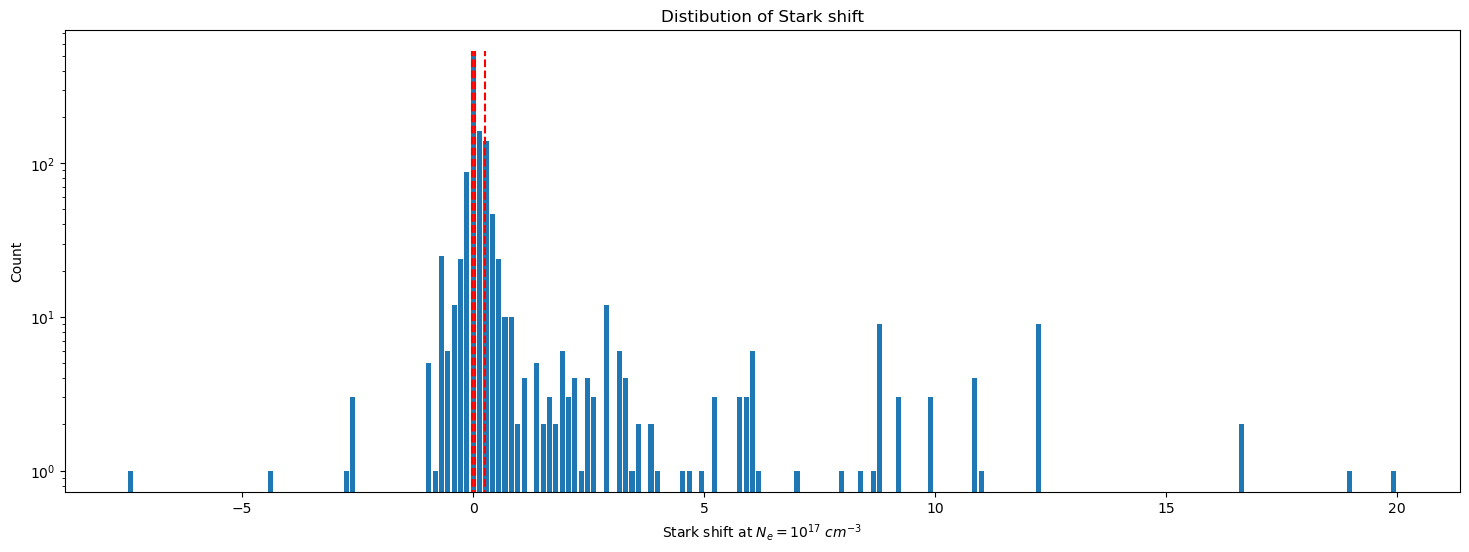

In [ ]:
fig, ax = plt.subplots(figsize = (18, 6))
n, bins, patches = plt.hist(target_shift, bins=200, log=True, rwidth = 0.8)
ax.vlines(x = data_shift_stats['25%'], ymin = 0, ymax = np.max(n), ls='--', colors='r')
ax.vlines(x = data_shift_stats['50%'], ymin = 0, ymax = np.max(n), ls='--', colors='r')
ax.vlines(x = data_shift_stats['75%'], ymin = 0, ymax = np.max(n), ls='--', colors='r')

ax.set_xlabel('Stark shift at $N_e = 10^{17}$ $cm^{-3}$')
ax.set_ylabel('Count')
ax.set_title('Distibution of Stark shift')

plt.show()

#plt.savefig('Shift distribution.png', dpi = 300)

C:\Users\Alex\AppData\Local\Temp\1\ipykernel_17728\3858759292.py:18: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[1, 0].get_shared_x_axes().join(axs[0, 0], axs[1, 0])
C:\Users\Alex\AppData\Local\Temp\1\ipykernel_17728\3858759292.py:19: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[1, 1].get_shared_x_axes().join(axs[0, 1], axs[1, 1])
C:\Users\Alex\AppData\Local\Temp\1\ipykernel_17728\3858759292.py:20: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[3, 0].get_shared_x_axes().join(axs[2, 0], axs[3, 0])
C:\Users\Alex\AppData\Local\Temp\1\ipykernel_17728\3858759292.py:21: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[3, 1].get_shared_x_axes().join(ax

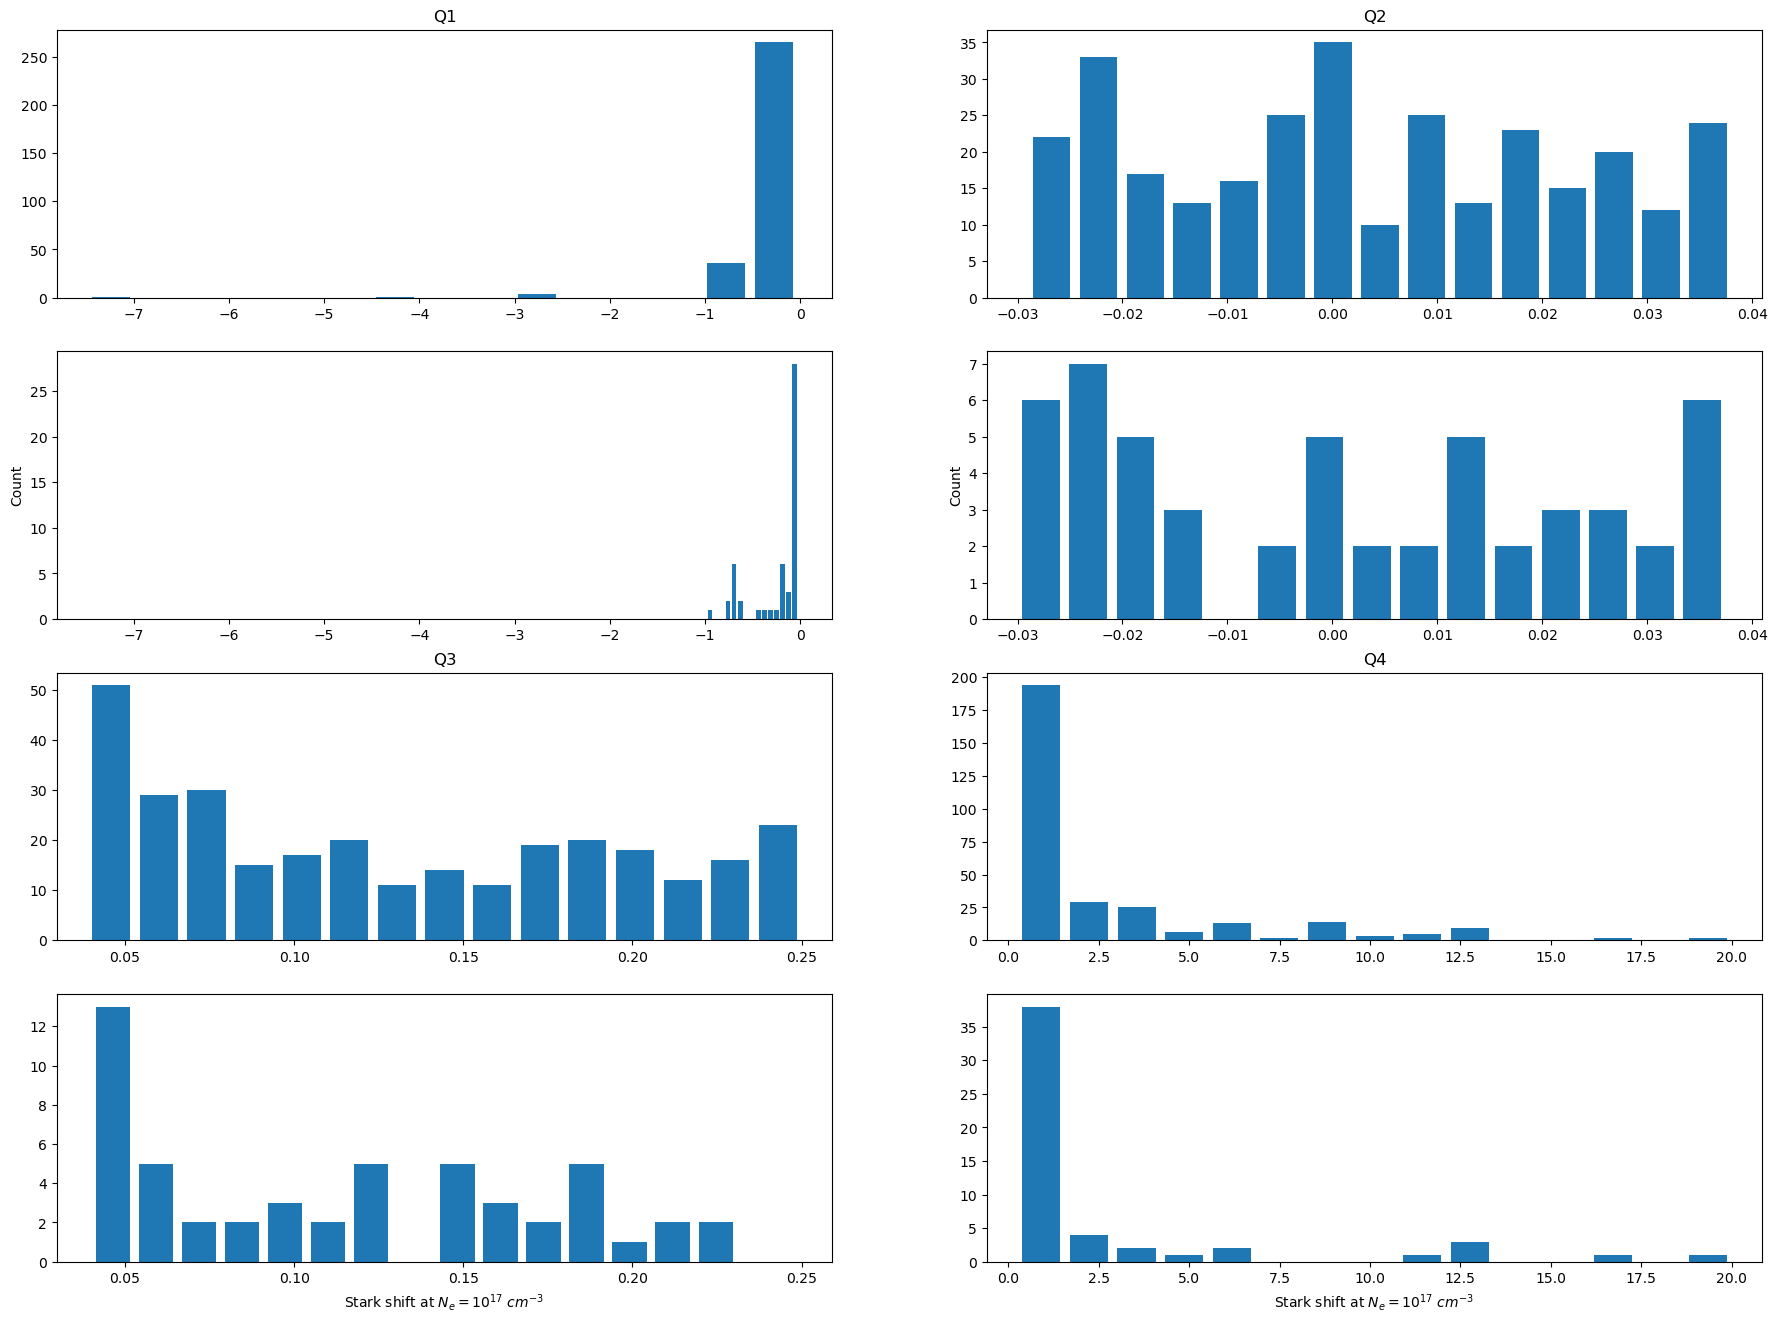

In [ ]:
fig, axs = plt.subplots(4, 2, figsize = (22, 16), sharex = False)

axs[0, 0].hist(target_shift[target_shift <= data_shift_stats['25%']], bins=15, log=False, rwidth = 0.8)
axs[1, 0].hist(target_test_q1, bins = 15, rwidth = 0.8)

axs[0, 1].hist(target_shift[(target_shift > data_shift_stats['25%']) & (target_shift <= data_shift_stats['50%'])],
                            bins=15, log=False, rwidth = 0.8)
axs[1, 1].hist(target_test_q2, bins = 15, rwidth = 0.8)

axs[2, 0].hist(target_shift[(target_shift > data_shift_stats['50%']) & (target_shift <= data_shift_stats['75%'])],
                            bins=15, log=False, rwidth = 0.8)
axs[3, 0].hist(target_test_q3, bins = 15, rwidth = 0.8)

axs[2, 1].hist(target_shift[target_shift > data_shift_stats['75%']],
                            bins=15, log=False, rwidth = 0.8)
axs[3, 1].hist(target_test_q4, bins = 15, rwidth = 0.8)

axs[1, 0].get_shared_x_axes().join(axs[0, 0], axs[1, 0])
axs[1, 1].get_shared_x_axes().join(axs[0, 1], axs[1, 1])
axs[3, 0].get_shared_x_axes().join(axs[2, 0], axs[3, 0])
axs[3, 1].get_shared_x_axes().join(axs[2, 1], axs[3, 1])

axs[0, 0].set_title('Q1')
axs[2, 0].set_title('Q3')
axs[0, 1].set_title('Q2')
axs[2, 1].set_title('Q4')
axs[1, 0].set_ylabel('Count')
axs[1, 1].set_ylabel('Count')
axs[3, 0].set_xlabel('Stark shift at $N_e = 10^{17}$ $cm^{-3}$')
axs[3, 1].set_xlabel('Stark shift at $N_e = 10^{17}$ $cm^{-3}$')
plt.show()

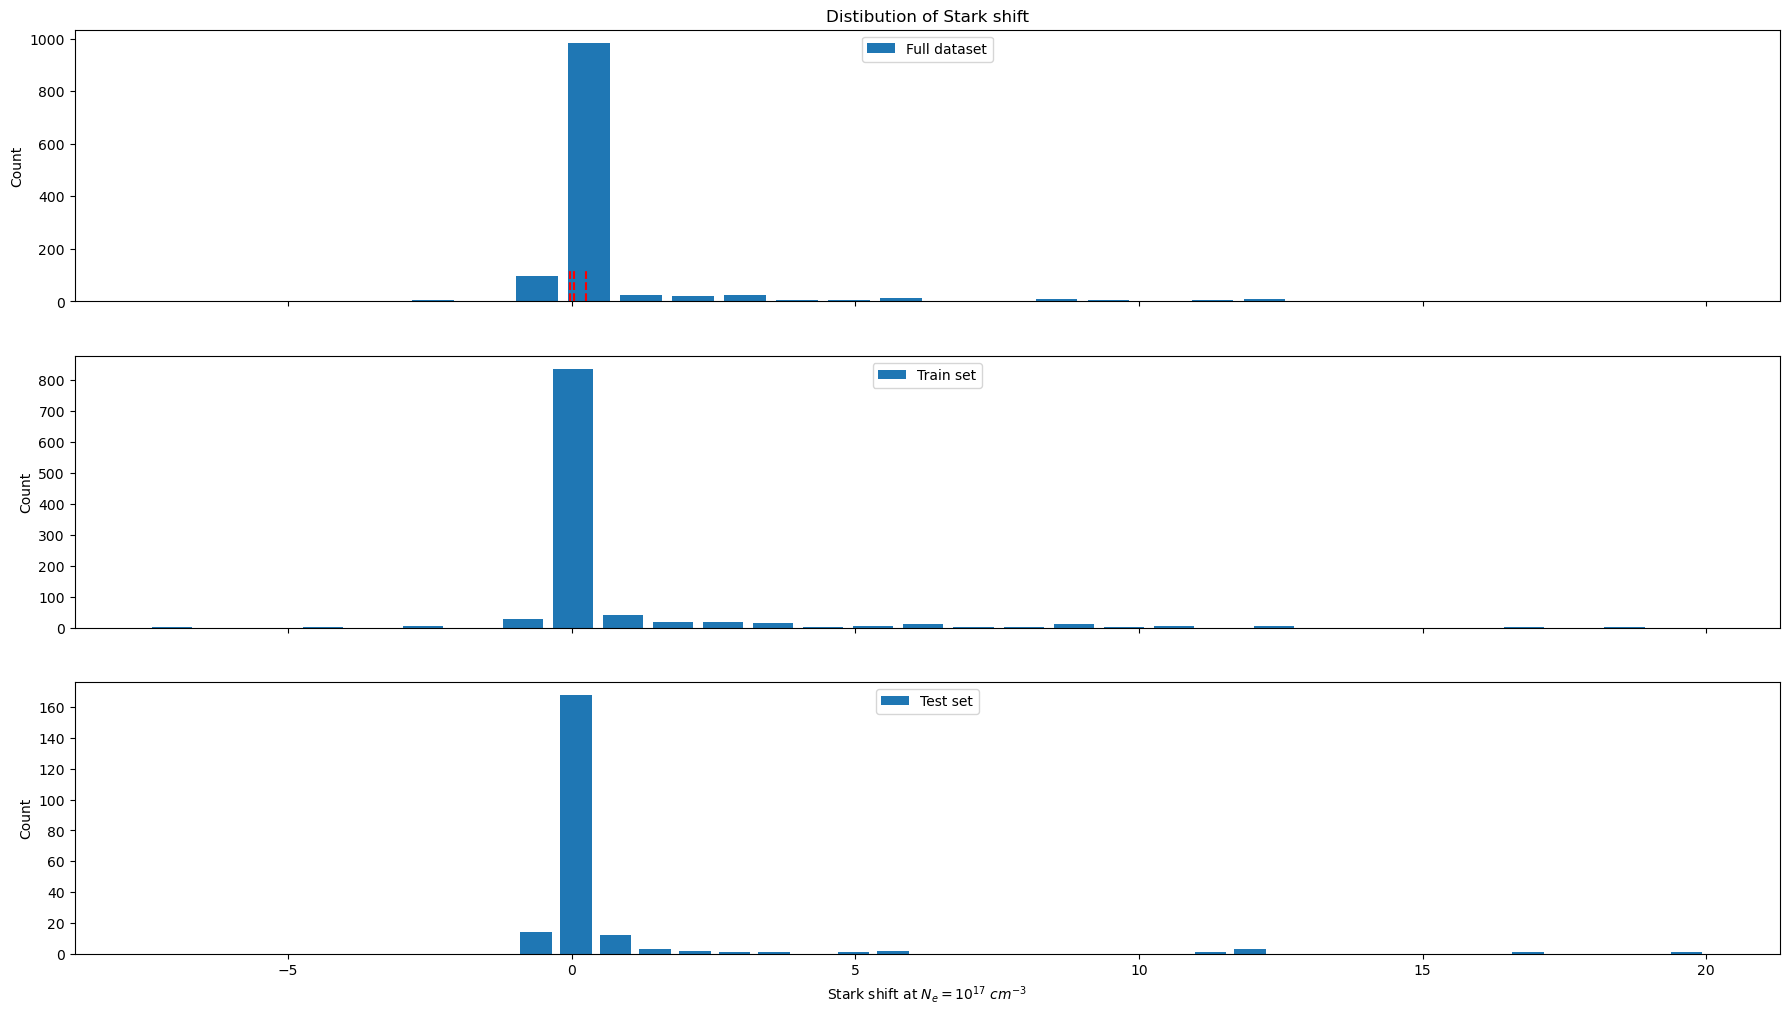

In [ ]:
test_shift_stats = target_shift_test.describe()

fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = True)
axs[0].hist(target_shift, bins=30, log=False, rwidth = 0.8, label = 'Full dataset')
axs[1].hist(target_shift_train, bins = 30, log = False, rwidth = 0.8, label = 'Train set')
axs[2].hist(target_shift_test, bins = 30, log = False, rwidth = 0.8, label = 'Test set')


axs[0].vlines(x = data_shift_stats['25%'], ymin = 0, ymax = 120, ls='--', colors='r')
axs[0].vlines(x = data_shift_stats['50%'], ymin = 0, ymax = 120, ls='--', colors='r')
axs[0].vlines(x = data_shift_stats['75%'], ymin = 0, ymax = 120, ls='--', colors='r')
'''axs[1].vlines(x = test_shift_stats['25%'], ymin = 0, ymax = 100, ls='--', colors='r')
axs[1].vlines(x = test_shift_stats['50%'], ymin = 0, ymax = 100, ls='--', colors='r')
axs[1].vlines(x = test_shift_stats['75%'], ymin = 0, ymax = 100, ls='--', colors='r')
'''
axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')
axs[2].set_xlabel('Stark shift at $N_e = 10^{17}$ $cm^{-3}$')
axs[0].set_ylabel('Count')
axs[1].set_ylabel('Count')
axs[2].set_ylabel('Count')
axs[0].set_title('Distibution of Stark shift')

plt.show()

#plt.savefig('shift distribution.png', dpi = 300)

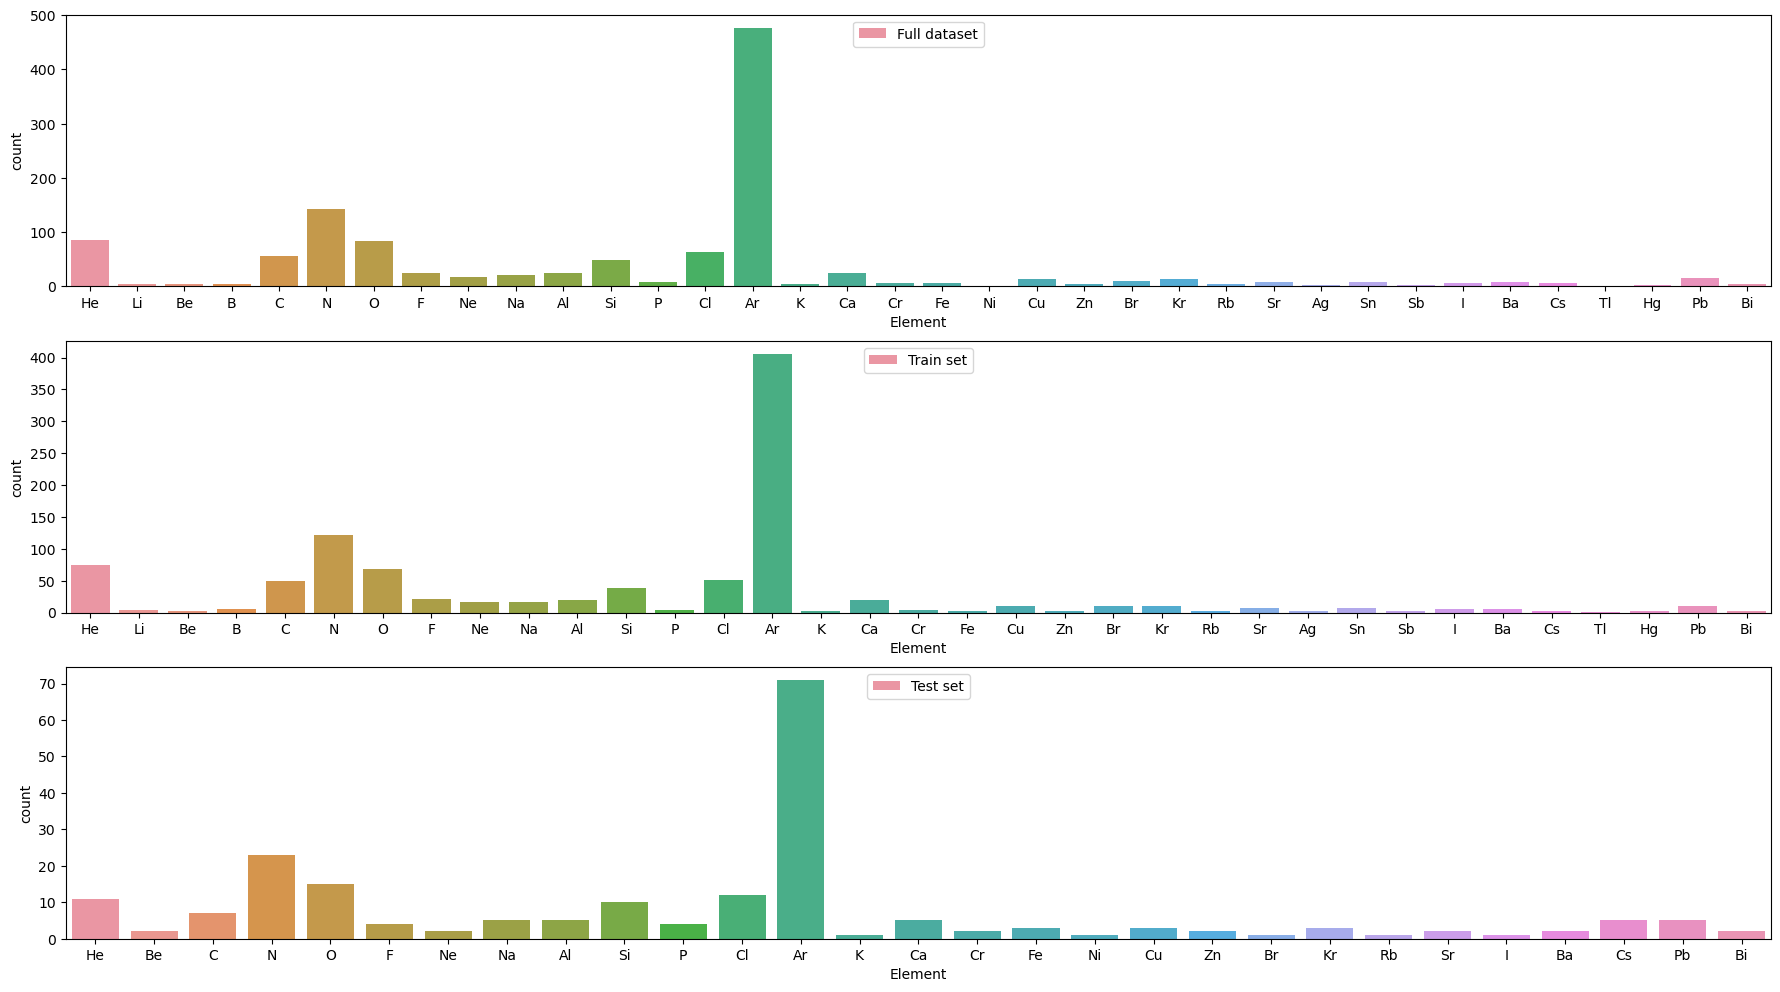

In [ ]:
fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = False)
sns.countplot(data = data_shift, x = 'Element',  ax = axs[0], label = 'Full dataset')
sns.countplot(data = data_shift_train.sort_values(by = ['Z number']), x = 'Element',  ax = axs[1], label = 'Train set')
sns.countplot(data = data_shift_test.sort_values(by = ['Z number']), x = 'Element', ax = axs[2], label = 'Test set')

axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')

plt.show()

# Both data preprocessing (currently not used anywhere further)

In [ ]:
#Selecting items for predicting both parameters simultaneously (currently not used anywhere further)
data_both = data[(data['w (A)'].isna() == False) & (data['d (A)'].isna() == False)]
target_both = data_both.loc[:, ['w (A)', 'd (A)']]
label_both = data_both.loc[:, ['Element', 'Wavelength']]
data_both = data_both.drop(columns = ['w (A)', 'd (A)'])

# Dataset modifications  (scaling, augmentation)

In [ ]:
augmented_train_set = False#@param {type:"boolean"}
#@markdown Note: augmentation will be applied to width only 

#@markdown ---

#@markdown Select whether you'd like to work with 'width' or 'shift' predictions
parameter  = 'width' #@param ["width", "shift"]

#@markdown ---

#@markdown You can enter any reasonable value less than 180 Angstrom to limit the upper boundary of width walues. (not recommended to change)
width_threshold =  200#@param {type:"number"}

#@markdown ---

#@markdown Scale target values by the formula: $y_{scaled} = ln(1 + \frac{y_{raw}}{\epsilon})$
scaled_target = True#@param {type:"boolean"}
epsilon = 1e-3#@param {type: "number"}

#@markdown ---

apply_scaler = True#@param {type:"boolean"}

In [ ]:
#Assigning proper variables
#Assigning width wariables
if augmented_train_set:
    XW_train, YW_train = data_width_train_extended.drop(columns=['Element', 'Wavelength', 'Z number']), target_width_train_extended
    XW_test, YW_test = data_width_test.drop(columns=['Element', 'Wavelength', 'Z number']), target_width_test
else:
    XW_train, YW_train = data_width_train.drop(columns=['Element', 'Wavelength', 'Z number']), target_width_train
    XW_test, YW_test = data_width_test.drop(columns=['Element', 'Wavelength', 'Z number']), target_width_test
XW_train = XW_train.sample(frac = 1, random_state = 777)                        #reshuffle
YW_train = YW_train.sample(frac = 1, random_state = 777)

#Assigning shift variables
XS_train, YS_train = data_shift_train.drop(columns=['Element', 'Wavelength', 'Z number']), target_shift_train
XS_test, YS_test = data_shift_test.drop(columns=['Element', 'Wavelength', 'Z number']), target_shift_test
XS_train = XS_train.sample(frac = 1, random_state = 777)
YS_train = YS_train.sample(frac = 1, random_state = 777)

#Assigning proper variables for elements-exclusive test set
XW_elem = data_width_elements.drop(columns=['Element', 'Wavelength', 'Z number'])
YW_elem = target_width_elements
LW_elem = label_width_elements

XS_elem = data_shift_elements.drop(columns=['Element', 'Wavelength', 'Z number', 'd (A)', 'w (A)'])
YS_elem = target_shift_elements
LS_elem = label_shift_elements


#Applying upper boundary to width values
XW_train = XW_train.loc[YW_train.loc[YW_train < width_threshold].index]
YW_train = YW_train.loc[YW_train < width_threshold]
XW_test = XW_test.loc[YW_test.loc[YW_test < width_threshold].index]
YW_test = YW_test.loc[YW_test < width_threshold]
XW_elem = XW_elem.loc[YW_elem.loc[YW_elem < width_threshold].index]
YW_elem = YW_elem.loc[YW_elem < width_threshold]
LW_elem = LW_elem.loc[YW_elem.loc[YW_elem < width_threshold].index]


#Applying scaling of width targets
if scaled_target:
    YW_train = np.log(1 + YW_train / epsilon)
    YW_test = np.log(1 + YW_test / epsilon)
    YW_elem = np.log(1 + YW_elem / epsilon)


#Applying 'width' or 'shift selection
if parameter == 'width':
    X_train, Y_train = XW_train, YW_train
    X_test, Y_test = XW_test, YW_test
    X_elem, Y_elem, L_elem = XW_elem, YW_elem, LW_elem
else:
    X_train, Y_train = XS_train, YS_train
    X_test, Y_test = XS_test, YS_test
    X_elem, Y_elem, L_elem = XS_elem, YS_elem, XS_elem


print(f'Number of items with width: {data_width.shape[0]}')
print(f'Number of items with shift: {data_shift.shape[0]}')
print(f'Number of items with both parameters: {data_both.shape[0]}')
print()
print(f'Size of elements-exclusive test set: {data_width_elements.shape[0]}')

Number of items with width: 3574
Number of items with shift: 1220
Number of items with both parameters: 924

Size of elements-exclusive test set: 121


In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

# Models optimization

## KNN

In [ ]:
KNN_params = {
    'n_neighbors' : [1, 150],
    'weights' : ['distance', 'uniform'],
    'leaf_size' : [1, 100],
    'p' : [1., 2.],
    'nfold' : 5,
    'squared_metrics' : False,
    'n_jobs' : -1
    }

model_name = KNN

KNN_res = main(X = X_train, y = Y_train, model_name = model_name, params = KNN_params, n_trials = 500)

with open(f'KNN_A+I__Scaled_optimal_parameters', 'w') as fp:
    json.dump(KNN_res.best_params, fp)

[I 2023-05-02 23:50:45,912] A new study created in memory with name: no-name-24b4c260-4fb8-4405-8405-aa0e49c88548


Start hyperparameter optimization


C:\Users\Alex\AppData\Roaming\Python\Python310\site-packages\optuna\progress_bar.py:56: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/500 [00:00<?, ?it/s]

{'n_neighbors': 23, 'weights': 'uniform', 'leaf_size': 62, 'p': 1.2662696666504165}
{'n_neighbors': 49, 'weights': 'uniform', 'leaf_size': 18, 'p': 1.568516500808838}
{'n_neighbors': 40, 'weights': 'uniform', 'leaf_size': 92, 'p': 1.8642171467858073}
{'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 58, 'p': 1.2038785008510553}
{'n_neighbors': 33, 'weights': 'distance', 'leaf_size': 43, 'p': 1.2591789320524351}
{'n_neighbors': 131, 'weights': 'uniform', 'leaf_size': 8, 'p': 1.9049835238183879}
{'n_neighbors': 75, 'weights': 'distance', 'leaf_size': 99, 'p': 1.0733458122899826}
{'n_neighbors': 30, 'weights': 'distance', 'leaf_size': 7, 'p': 1.5718023458774684}
{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 71, 'p': 1.5102524750926796}
{'n_neighbors': 143, 'weights': 'uniform', 'leaf_size': 58, 'p': 1.8953430084297036}
{'n_neighbors': 58, 'weights': 'uniform', 'leaf_size': 21, 'p': 1.8507940921288675}
{'n_neighbors': 150, 'weights': 'uniform', 'leaf_size': 6, 'p': 1.982889283

[I 2023-05-02 23:51:11,363] Trial 21 finished with value: 0.4938350702616723 and parameters: {'n_neighbors': 93, 'weights': 'distance', 'leaf_size': 38, 'p': 1.002971971220684}. Best is trial 22 with value: 0.4227833088055827.
{'n_neighbors': 13, 'weights': 'distance', 'leaf_size': 47, 'p': 1.146560092047318}
[I 2023-05-02 23:51:15,301] Trial 24 finished with value: 0.4512809014281734 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 37, 'p': 1.0487617861004246}. Best is trial 22 with value: 0.4227833088055827.
{'n_neighbors': 17, 'weights': 'distance', 'leaf_size': 49, 'p': 1.1201755078377487}
[I 2023-05-02 23:51:17,869] Trial 25 finished with value: 0.4260810370293788 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'leaf_size': 39, 'p': 1.0694884216986884}. Best is trial 22 with value: 0.4227833088055827.
{'n_neighbors': 18, 'weights': 'distance', 'leaf_size': 30, 'p': 1.1330336189890307}
[I 2023-05-02 23:51:17,996] Trial 26 finished with value: 0.45130

[I 2023-05-02 23:51:39,926] Trial 49 finished with value: 0.4499232276851437 and parameters: {'n_neighbors': 32, 'weights': 'distance', 'leaf_size': 29, 'p': 1.1962526520365815}. Best is trial 22 with value: 0.4227833088055827.
{'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 53, 'p': 1.0740023705884085}
[I 2023-05-02 23:51:41,673] Trial 50 finished with value: 0.4530248086384507 and parameters: {'n_neighbors': 35, 'weights': 'distance', 'leaf_size': 27, 'p': 1.2018456798974924}. Best is trial 22 with value: 0.4227833088055827.
{'n_neighbors': 8, 'weights': 'distance', 'leaf_size': 55, 'p': 1.2479878429714428}
[I 2023-05-02 23:51:41,694] Trial 51 finished with value: 0.4522670128929381 and parameters: {'n_neighbors': 34, 'weights': 'distance', 'leaf_size': 28, 'p': 1.217861728385228}. Best is trial 22 with value: 0.4227833088055827.
[I 2023-05-02 23:51:41,716] Trial 52 finished with value: 0.4532696463708234 and parameters: {'n_neighbors': 35, 'weights': 'distance', 'leaf_size': 

[I 2023-05-02 23:52:02,892] Trial 76 finished with value: 0.4974876824052673 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.0506718731413522}. Best is trial 66 with value: 0.42173590123516413.
{'n_neighbors': 22, 'weights': 'distance', 'leaf_size': 60, 'p': 1.029261008979477}
[I 2023-05-02 23:52:03,075] Trial 75 finished with value: 0.5231500132057553 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'leaf_size': 82, 'p': 1.0434133623576214}. Best is trial 66 with value: 0.42173590123516413.
{'n_neighbors': 21, 'weights': 'distance', 'leaf_size': 61, 'p': 1.0054716958581724}
[I 2023-05-02 23:52:03,479] Trial 78 finished with value: 0.5106500176649824 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.0459930682862382}. Best is trial 66 with value: 0.42173590123516413.
{'n_neighbors': 21, 'weights': 'distance', 'leaf_size': 68, 'p': 1.000961008317075}
[I 2023-05-02 23:52:03,866] Trial 79 finished with value: 0.496453

[I 2023-05-02 23:52:26,399] Trial 102 finished with value: 0.45267914369862794 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 81, 'p': 1.117263550162941}. Best is trial 82 with value: 0.42105937821829853.
[I 2023-05-02 23:52:26,402] Trial 103 finished with value: 0.45312684270165937 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 90, 'p': 1.112747712760021}. Best is trial 82 with value: 0.42105937821829853.
{'n_neighbors': 11, 'weights': 'distance', 'leaf_size': 64, 'p': 1.0728995327846789}
{'n_neighbors': 12, 'weights': 'distance', 'leaf_size': 72, 'p': 1.076010644015617}
[I 2023-05-02 23:52:26,705] Trial 101 finished with value: 0.4425079838853573 and parameters: {'n_neighbors': 26, 'weights': 'distance', 'leaf_size': 3, 'p': 1.110741430231455}. Best is trial 82 with value: 0.42105937821829853.
{'n_neighbors': 11, 'weights': 'distance', 'leaf_size': 71, 'p': 1.0701757594383021}
[I 2023-05-02 23:52:27,863] Trial 107 finished with value: 0

[I 2023-05-02 23:52:49,388] Trial 129 finished with value: 0.4909671580597944 and parameters: {'n_neighbors': 82, 'weights': 'distance', 'leaf_size': 44, 'p': 1.1320892876418223}. Best is trial 82 with value: 0.42105937821829853.
[I 2023-05-02 23:52:49,412] Trial 130 finished with value: 0.4315447488989436 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'leaf_size': 18, 'p': 1.124405963608482}. Best is trial 82 with value: 0.42105937821829853.
{'n_neighbors': 17, 'weights': 'distance', 'leaf_size': 66, 'p': 1.0943935109868255}
{'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 78, 'p': 1.0321273992196647}
[I 2023-05-02 23:52:49,526] Trial 126 finished with value: 0.4889288266561448 and parameters: {'n_neighbors': 79, 'weights': 'distance', 'leaf_size': 72, 'p': 1.1382924691886507}. Best is trial 82 with value: 0.42105937821829853.
{'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 58, 'p': 1.0886859510865532}
[I 2023-05-02 23:52:50,162] Trial 127 finished with value:

[I 2023-05-02 23:53:13,005] Trial 154 finished with value: 0.4233631527506511 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 69, 'p': 1.0281708640226}. Best is trial 152 with value: 0.42063290064953707.
{'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 51, 'p': 1.024639297568535}
[I 2023-05-02 23:53:13,060] Trial 153 finished with value: 0.4233642477147794 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 69, 'p': 1.0288365047546575}. Best is trial 152 with value: 0.42063290064953707.
[I 2023-05-02 23:53:13,101] Trial 155 finished with value: 0.42336681462300996 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 58, 'p': 1.0294602229526062}. Best is trial 152 with value: 0.42063290064953707.
{'n_neighbors': 135, 'weights': 'distance', 'leaf_size': 86, 'p': 1.0547921015356396}
{'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 85, 'p': 1.0511277007530286}
[I 2023-05-02 23:53:14,475] Trial 156 finished with value: 

{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 62, 'p': 1.0017782469918504}
[I 2023-05-02 23:53:36,218] Trial 177 finished with value: 0.42236030678219494 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 50, 'p': 1.0478556763893507}. Best is trial 159 with value: 0.4205696426953036.
{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 54, 'p': 1.0011547680773165}
[I 2023-05-02 23:53:36,315] Trial 181 finished with value: 0.4290183322513025 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'leaf_size': 49, 'p': 1.0530199939175426}. Best is trial 159 with value: 0.4205696426953036.
{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 89, 'p': 1.0072059256605481}
[I 2023-05-02 23:53:36,924] Trial 182 finished with value: 0.4221240030370862 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 50, 'p': 1.0000833307168164}. Best is trial 159 with value: 0.4205696426953036.
{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 54, 

[I 2023-05-02 23:53:59,983] Trial 205 finished with value: 0.42171206075572093 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 57, 'p': 1.0286184946940797}. Best is trial 159 with value: 0.4205696426953036.
{'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 59, 'p': 1.069987290167885}
[I 2023-05-02 23:54:00,488] Trial 206 finished with value: 0.4215961028914353 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 57, 'p': 1.0296288316915108}. Best is trial 159 with value: 0.4205696426953036.
{'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 59, 'p': 1.0680147827847122}
[I 2023-05-02 23:54:00,632] Trial 207 finished with value: 0.4216286479233237 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 57, 'p': 1.030775545108409}. Best is trial 159 with value: 0.4205696426953036.
{'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 59, 'p': 1.062074289932768}
[I 2023-05-02 23:54:02,897] Trial 209 finished with value: 0.42

{'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 79, 'p': 1.0429674129435196}
{'n_neighbors': 8, 'weights': 'distance', 'leaf_size': 79, 'p': 1.0467941582414266}
{'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 78, 'p': 1.0459995166373588}
[I 2023-05-02 23:54:26,020] Trial 235 finished with value: 0.5682020285894328 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.0481186608379833}. Best is trial 159 with value: 0.4205696426953036.
{'n_neighbors': 8, 'weights': 'distance', 'leaf_size': 80, 'p': 1.0459616221052905}
[I 2023-05-02 23:54:26,310] Trial 234 finished with value: 0.5699636883078396 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.0803995359237402}. Best is trial 159 with value: 0.4205696426953036.
{'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 78, 'p': 1.04673009131311}
[I 2023-05-02 23:54:28,473] Trial 236 finished with value: 0.5601968516921774 and parameters: {'n_neighbors': 11, 'weights':

[I 2023-05-02 23:54:49,354] Trial 259 finished with value: 0.4216012180076801 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'leaf_size': 81, 'p': 1.0456642517535415}. Best is trial 159 with value: 0.4205696426953036.
{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 82, 'p': 1.1058610518576912}
[I 2023-05-02 23:54:49,539] Trial 262 finished with value: 0.4239818847650184 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 80, 'p': 1.0442165357469892}. Best is trial 159 with value: 0.4205696426953036.
{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 83, 'p': 1.018400821253546}
[I 2023-05-02 23:54:50,629] Trial 260 finished with value: 0.4214621137537315 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 83, 'p': 1.0500168001764725}. Best is trial 159 with value: 0.4205696426953036.
{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 84, 'p': 1.4122963603863559}
[I 2023-05-02 23:54:51,668] Trial 261 finished with value: 0.4

[I 2023-05-02 23:55:14,153] Trial 286 finished with value: 0.42959056629584025 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'leaf_size': 77, 'p': 1.0791900314343217}. Best is trial 159 with value: 0.4205696426953036.
{'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 56, 'p': 1.2134630800683759}
[I 2023-05-02 23:55:14,505] Trial 287 finished with value: 0.43991180390775825 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'leaf_size': 77, 'p': 1.8386837023135096}. Best is trial 159 with value: 0.4205696426953036.
{'n_neighbors': 10, 'weights': 'distance', 'leaf_size': 59, 'p': 1.0506374682946318}
[I 2023-05-02 23:55:14,864] Trial 288 finished with value: 0.42532719255292745 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'leaf_size': 87, 'p': 1.2046022523706696}. Best is trial 159 with value: 0.4205696426953036.
{'n_neighbors': 10, 'weights': 'distance', 'leaf_size': 59, 'p': 1.0554115401617874}
[I 2023-05-02 23:55:18,435] Trial 289 finished with v

[I 2023-05-02 23:55:36,236] Trial 312 finished with value: 0.4205459816044884 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 52, 'p': 1.0201145934803952}. Best is trial 312 with value: 0.4205459816044884.
{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 54, 'p': 1.0142745371994781}
[I 2023-05-02 23:55:37,865] Trial 313 finished with value: 0.42107463358868885 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 99, 'p': 1.0155441649096844}. Best is trial 312 with value: 0.4205459816044884.
{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 94, 'p': 1.016745286219023}
[I 2023-05-02 23:55:39,819] Trial 314 finished with value: 0.4205608194136151 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 55, 'p': 1.0206122925045606}. Best is trial 312 with value: 0.4205459816044884.
{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 54, 'p': 1.0012863966582357}
[I 2023-05-02 23:55:40,856] Trial 315 finished with value: 0.

[I 2023-05-02 23:56:01,614] Trial 339 finished with value: 0.4215426474696643 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 52, 'p': 1.0003212331890712}. Best is trial 312 with value: 0.4205459816044884.
{'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 55, 'p': 1.0230988295611994}
[I 2023-05-02 23:56:02,330] Trial 338 finished with value: 0.42582742557956166 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'leaf_size': 53, 'p': 1.0008814885229402}. Best is trial 312 with value: 0.4205459816044884.
{'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 55, 'p': 1.022148694294627}
[I 2023-05-02 23:56:03,526] Trial 340 finished with value: 0.42446704055826806 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'leaf_size': 52, 'p': 1.002139021737634}. Best is trial 312 with value: 0.4205459816044884.
{'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 55, 'p': 1.025909781110197}
[I 2023-05-02 23:56:05,808] Trial 342 finished with value: 0

{'n_neighbors': 10, 'weights': 'distance', 'leaf_size': 50, 'p': 1.363614175667451}
[I 2023-05-02 23:56:24,199] Trial 365 finished with value: 0.42218446005154087 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 57, 'p': 1.033064395316423}. Best is trial 312 with value: 0.4205459816044884.
{'n_neighbors': 10, 'weights': 'distance', 'leaf_size': 98, 'p': 1.0694733061442458}
[I 2023-05-02 23:56:28,452] Trial 366 finished with value: 0.4252116762310106 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'leaf_size': 57, 'p': 1.1742456076045358}. Best is trial 312 with value: 0.4205459816044884.
{'n_neighbors': 10, 'weights': 'distance', 'leaf_size': 49, 'p': 1.5510529864333864}
[I 2023-05-02 23:56:30,262] Trial 367 finished with value: 0.4315216298168803 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 57, 'p': 1.6779894429346642}. Best is trial 312 with value: 0.4205459816044884.
{'n_neighbors': 10, 'weights': 'distance', 'leaf_size': 50,

[I 2023-05-02 23:56:51,491] Trial 390 finished with value: 0.4234244285870344 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 54, 'p': 1.0679752091593058}. Best is trial 312 with value: 0.4205459816044884.
{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 64, 'p': 1.275855179708512}
[I 2023-05-02 23:56:52,854] Trial 391 finished with value: 0.45724345035855685 and parameters: {'n_neighbors': 39, 'weights': 'distance', 'leaf_size': 54, 'p': 1.2026200817776296}. Best is trial 312 with value: 0.4205459816044884.
{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 64, 'p': 1.0128302521347914}
[I 2023-05-02 23:56:53,278] Trial 392 finished with value: 0.42318479040223533 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 54, 'p': 1.0650128294899628}. Best is trial 312 with value: 0.4205459816044884.
{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 59, 'p': 1.0000097222173896}
[I 2023-05-02 23:56:53,439] Trial 394 finished with value: 0.4

[I 2023-05-02 23:57:15,863] Trial 417 finished with value: 0.44925310471390406 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 58, 'p': 1.3231770946166799}. Best is trial 312 with value: 0.4205459816044884.
{'n_neighbors': 13, 'weights': 'distance', 'leaf_size': 64, 'p': 1.038877059383988}
[I 2023-05-02 23:57:16,509] Trial 418 finished with value: 0.45104380820919304 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 92, 'p': 1.0418656936162891}. Best is trial 312 with value: 0.4205459816044884.
{'n_neighbors': 13, 'weights': 'distance', 'leaf_size': 66, 'p': 1.1780179810868048}
[I 2023-05-02 23:57:16,608] Trial 419 finished with value: 0.48092674409461067 and parameters: {'n_neighbors': 67, 'weights': 'distance', 'leaf_size': 91, 'p': 1.1479007363698808}. Best is trial 312 with value: 0.4205459816044884.
{'n_neighbors': 13, 'weights': 'distance', 'leaf_size': 70, 'p': 1.040875126699569}
[I 2023-05-02 23:57:17,918] Trial 421 finished with valu

{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 61, 'p': 1.0000466060135835}
{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 61, 'p': 1.5905909609603122}
{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 60, 'p': 1.296860597329605}
[I 2023-05-02 23:57:39,080] Trial 443 finished with value: 0.4743895525004591 and parameters: {'n_neighbors': 55, 'weights': 'distance', 'leaf_size': 61, 'p': 1.26338346582931}. Best is trial 312 with value: 0.4205459816044884.
[I 2023-05-02 23:57:39,101] Trial 444 finished with value: 0.42599808019274255 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 72, 'p': 1.4799337664161563}. Best is trial 312 with value: 0.4205459816044884.
{'n_neighbors': 19, 'weights': 'distance', 'leaf_size': 52, 'p': 1.0173147208318547}
{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 52, 'p': 1.0597156061700912}
[I 2023-05-02 23:57:41,429] Trial 445 finished with value: 0.42516923523459116 and parameters: {'n_neighbors': 4, 'weights

{'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 53, 'p': 1.0800015060414527}
{'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 98, 'p': 1.872470676124782}
[I 2023-05-02 23:58:02,250] Trial 469 finished with value: 0.4214966483742842 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'leaf_size': 57, 'p': 1.022561293376407}. Best is trial 312 with value: 0.4205459816044884.
[I 2023-05-02 23:58:02,266] Trial 468 finished with value: 0.4214752616591393 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'leaf_size': 57, 'p': 1.021892110982953}. Best is trial 312 with value: 0.4205459816044884.
[I 2023-05-02 23:58:02,345] Trial 470 finished with value: 0.4217921991546921 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'leaf_size': 56, 'p': 1.0205070490839827}. Best is trial 312 with value: 0.4205459816044884.
{'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 63, 'p': 1.6080645136750384}
{'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 47, 'p': 

[I 2023-05-02 23:58:24,279] Trial 495 finished with value: 0.453746985752451 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 49, 'p': 1.7134876319601613}. Best is trial 312 with value: 0.4205459816044884.
[I 2023-05-02 23:58:24,764] Trial 498 finished with value: 0.430058505120975 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'leaf_size': 51, 'p': 1.4124241642059623}. Best is trial 312 with value: 0.4205459816044884.
[I 2023-05-02 23:58:25,163] Trial 496 finished with value: 0.4512809014281734 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 45, 'p': 1.0496717938302027}. Best is trial 312 with value: 0.4205459816044884.
[I 2023-05-02 23:58:25,286] Trial 499 finished with value: 0.45349407062860914 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 42, 'p': 1.6594168505044369}. Best is trial 312 with value: 0.4205459816044884.
[I 2023-05-02 23:58:25,352] Trial 497 finished with value: 0.42361857897892924 and p

Fitting new
Fitting default
Calculating bootstrap score for new
Calculating bootstrap score for default


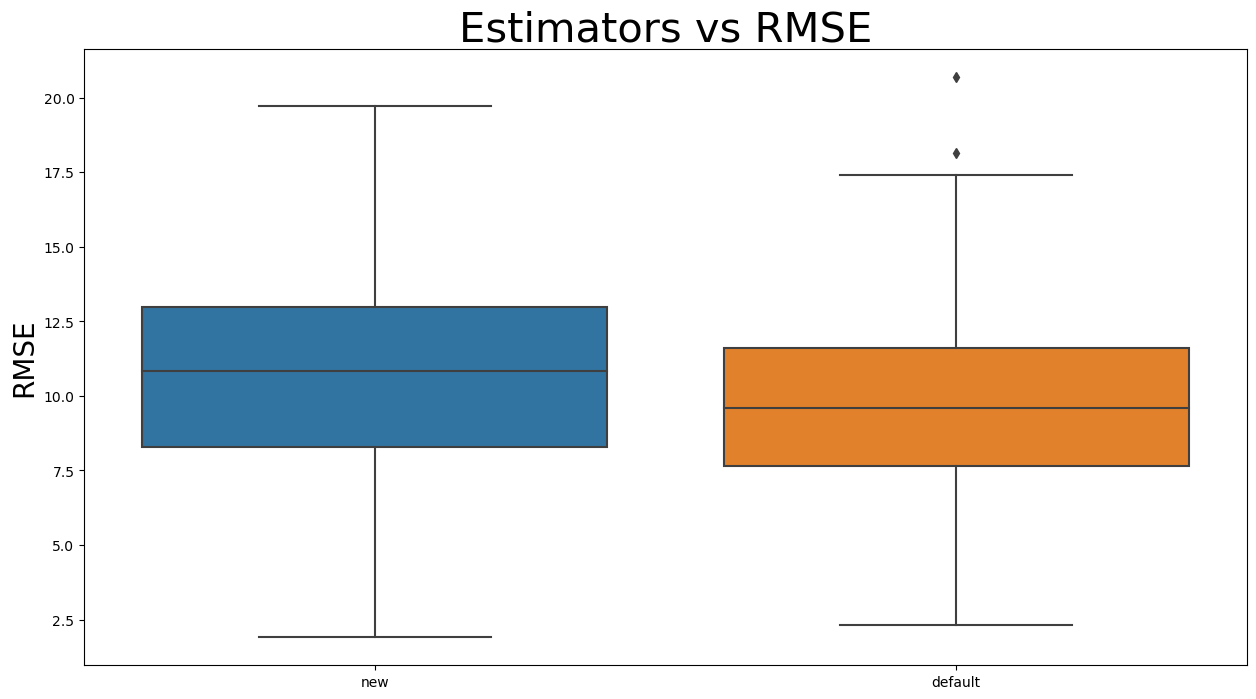

In [ ]:
#Compare default KNN vs optimised KNN
KNN_params = KNN_res.best_params

models = {}

models['new'] = KNeighborsRegressor(**KNN_params)
models['default'] = KNeighborsRegressor()

results = train_and_test_regressor(models, X_train, Y_train, X_test, Y_test)

plot_model_comparison(results)

In [ ]:
#Visualise importance of KNN model parameters
optuna.visualization.plot_param_importances(KNN_res)

In [ ]:
optuna.visualization.plot_slice(KNN_res, params = ['weights', 'n_neighbors'])

## Random Forest

In [ ]:
RF_params = {
    'n_estimators' : 100,
    'max_depth' : [1, 50],
    'min_samples_split' : [2, 10],
    'min_samples_leaf' : [1, 10],
    'criterion' : ['squared_error', 'absolute_error', 'poisson'],      #add 'poisson' for width tuning
    'nfold' : 5,
    'squared_metrics' : False,
    'n_jobs' : -1
    }

model_name = RandomForest

if apply_scaler:
    RF_res = main(X = pd.DataFrame(scaler.transform(X_train)), y = Y_train, model_name = model_name, params = RF_params, n_trials = 500)
else:
    RF_res = main(X = X_train, y = Y_train, model_name = model_name, params = RF_params, n_trials = 500)

with open(f'RF_A+I_StandardScaler_Scaled_optimal_parameters', 'w') as fp:
    json.dump(RF_res.best_params, fp)

[I 2023-05-02 23:58:25,370] A new study created in memory with name: no-name-4238dc3d-a5b1-4e72-8fda-655cf580df9f


Start hyperparameter optimization


C:\Users\Alex\AppData\Roaming\Python\Python310\site-packages\optuna\progress_bar.py:56: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/500 [00:00<?, ?it/s]

{'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 9, 'criterion': 'squared_error'}
{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 8, 'criterion': 'poisson'}
{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 4, 'min_samples_leaf': 10, 'criterion': 'squared_error'}
{'n_estimators': 100, 'max_depth': 43, 'min_samples_split': 2, 'min_samples_leaf': 5, 'criterion': 'absolute_error'}
{'n_estimators': 100, 'max_depth': 40, 'min_samples_split': 7, 'min_samples_leaf': 4, 'criterion': 'squared_error'}
{'n_estimators': 100, 'max_depth': 50, 'min_samples_split': 7, 'min_samples_leaf': 1, 'criterion': 'poisson'}
{'n_estimators': 100, 'max_depth': 45, 'min_samples_split': 7, 'min_samples_leaf': 7, 'criterion': 'absolute_error'}
{'n_estimators': 100, 'max_depth': 30, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}
{'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 7, 'min_samples_leaf'

{'n_estimators': 100, 'max_depth': 49, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}[I 2023-05-03 00:01:55,536] Trial 21 finished with value: 0.3857161528968788 and parameters: {'max_depth': 30, 'min_samples_split': 10, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 8 with value: 0.37062344944620185.

{'n_estimators': 100, 'max_depth': 50, 'min_samples_split': 10, 'min_samples_leaf': 1, 'criterion': 'poisson'}
[I 2023-05-03 00:01:56,105] Trial 22 finished with value: 0.3786519190638557 and parameters: {'max_depth': 34, 'min_samples_split': 8, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 8 with value: 0.37062344944620185.
{'n_estimators': 100, 'max_depth': 35, 'min_samples_split': 8, 'min_samples_leaf': 2, 'criterion': 'squared_error'}
[I 2023-05-03 00:02:23,154] Trial 23 finished with value: 0.3691317831382511 and parameters: {'max_depth': 35, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Be

[I 2023-05-03 00:08:26,315] Trial 43 finished with value: 0.4210706461859818 and parameters: {'max_depth': 29, 'min_samples_split': 3, 'min_samples_leaf': 3, 'criterion': 'absolute_error'}. Best is trial 31 with value: 0.3684283095689889.
{'n_estimators': 100, 'max_depth': 38, 'min_samples_split': 2, 'min_samples_leaf': 4, 'criterion': 'absolute_error'}
[I 2023-05-03 00:09:11,725] Trial 44 finished with value: 0.42042082464802355 and parameters: {'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 3, 'criterion': 'absolute_error'}. Best is trial 31 with value: 0.3684283095689889.
{'n_estimators': 100, 'max_depth': 38, 'min_samples_split': 2, 'min_samples_leaf': 4, 'criterion': 'absolute_error'}
[I 2023-05-03 00:09:15,632] Trial 45 finished with value: 0.42375908037997323 and parameters: {'max_depth': 31, 'min_samples_split': 3, 'min_samples_leaf': 3, 'criterion': 'absolute_error'}. Best is trial 31 with value: 0.3684283095689889.
{'n_estimators': 100, 'max_depth': 46, 'min_sam

{'n_estimators': 100, 'max_depth': 42, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'poisson'}
[I 2023-05-03 00:12:19,496] Trial 67 finished with value: 0.36929192249783976 and parameters: {'max_depth': 45, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 64 with value: 0.3676767241850457.
[I 2023-05-03 00:12:19,654] Trial 57 finished with value: 0.4500093547266024 and parameters: {'max_depth': 46, 'min_samples_split': 2, 'min_samples_leaf': 4, 'criterion': 'absolute_error'}. Best is trial 64 with value: 0.3676767241850457.
{'n_estimators': 100, 'max_depth': 43, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'poisson'}
{'n_estimators': 100, 'max_depth': 42, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'poisson'}
[I 2023-05-03 00:12:22,003] Trial 68 finished with value: 0.3693527411532508 and parameters: {'max_depth': 47, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 6

[I 2023-05-03 00:12:55,915] Trial 89 finished with value: 0.3939363090163994 and parameters: {'max_depth': 49, 'min_samples_split': 6, 'min_samples_leaf': 2, 'criterion': 'poisson'}. Best is trial 69 with value: 0.3673871911637141.
{'n_estimators': 100, 'max_depth': 48, 'min_samples_split': 4, 'min_samples_leaf': 7, 'criterion': 'poisson'}
[I 2023-05-03 00:12:59,180] Trial 91 finished with value: 0.3931587095289927 and parameters: {'max_depth': 48, 'min_samples_split': 6, 'min_samples_leaf': 2, 'criterion': 'poisson'}. Best is trial 69 with value: 0.3673871911637141.
[I 2023-05-03 00:12:59,270] Trial 92 finished with value: 0.38994324922290946 and parameters: {'max_depth': 44, 'min_samples_split': 4, 'min_samples_leaf': 2, 'criterion': 'poisson'}. Best is trial 69 with value: 0.3673871911637141.
[I 2023-05-03 00:12:59,288] Trial 94 finished with value: 0.3896019356829267 and parameters: {'max_depth': 49, 'min_samples_split': 6, 'min_samples_leaf': 2, 'criterion': 'poisson'}. Best is tr

[I 2023-05-03 00:13:33,698] Trial 111 finished with value: 0.3687461777294867 and parameters: {'max_depth': 36, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 108 with value: 0.3652828923890964.
{'n_estimators': 100, 'max_depth': 40, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}
{'n_estimators': 100, 'max_depth': 40, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}
{'n_estimators': 100, 'max_depth': 40, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}
[I 2023-05-03 00:13:35,182] Trial 114 finished with value: 0.3714922136806165 and parameters: {'max_depth': 46, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 108 with value: 0.3652828923890964.
{'n_estimators': 100, 'max_depth': 40, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}
[I 2023-05-03 00:13:36,282] Trial 116 finished with value: 0.368471935472956 and parameters:

[I 2023-05-03 00:14:13,208] Trial 135 finished with value: 0.3675122265454296 and parameters: {'max_depth': 33, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 127 with value: 0.36348701112945514.
[I 2023-05-03 00:14:13,632] Trial 139 finished with value: 0.4600197234122101 and parameters: {'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 127 with value: 0.36348701112945514.
[I 2023-05-03 00:14:14,321] Trial 137 finished with value: 0.36854743355584707 and parameters: {'max_depth': 33, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 127 with value: 0.36348701112945514.
{'n_estimators': 100, 'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}
[I 2023-05-03 00:14:14,563] Trial 136 finished with value: 0.36681874951702753 and parameters: {'max_depth': 32, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criter

{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 9, 'criterion': 'squared_error'}
[I 2023-05-03 00:14:50,154] Trial 158 finished with value: 0.48028304203295613 and parameters: {'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 9, 'criterion': 'squared_error'}. Best is trial 127 with value: 0.36348701112945514.
[I 2023-05-03 00:14:50,449] Trial 159 finished with value: 0.3635894737753868 and parameters: {'max_depth': 28, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 127 with value: 0.36348701112945514.
{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'squared_error'}
{'n_estimators': 100, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'squared_error'}
[I 2023-05-03 00:14:52,749] Trial 160 finished with value: 0.3666713090033008 and parameters: {'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion

[I 2023-05-03 00:15:17,924] Trial 180 finished with value: 0.3699376077710854 and parameters: {'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 172 with value: 0.36325614232891634.
{'n_estimators': 100, 'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}
[I 2023-05-03 00:15:24,477] Trial 181 finished with value: 0.36549176017346274 and parameters: {'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 172 with value: 0.36325614232891634.
[I 2023-05-03 00:15:25,250] Trial 182 finished with value: 0.36580408835929706 and parameters: {'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 172 with value: 0.36325614232891634.
{'n_estimators': 100, 'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}
{'n_estimators': 100, 'max_depth': 21, 'min

{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}
{'n_estimators': 100, 'max_depth': 33, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}
{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}
{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}
[I 2023-05-03 00:15:55,742] Trial 204 finished with value: 0.3629870887772239 and parameters: {'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 204 with value: 0.3629870887772239.
{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}
[I 2023-05-03 00:16:01,105] Trial 205 finished with value: 0.44841491871925043 and parameters: {'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 6, 'criterion': 'square

{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}
{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 1, 'criterion': 'squared_error'}
{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}
{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}
{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}
{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}
[I 2023-05-03 00:16:33,789] Trial 228 finished with value: 0.3692758360202487 and parameters: {'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 204 with value: 0.3629870887772239.
{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 3, 

{'n_estimators': 100, 'max_depth': 35, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}
{'n_estimators': 100, 'max_depth': 35, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}
[I 2023-05-03 00:17:09,317] Trial 250 finished with value: 0.36589262894345065 and parameters: {'max_depth': 35, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 239 with value: 0.3629290555005851.
[I 2023-05-03 00:17:09,416] Trial 249 finished with value: 0.3682454341546907 and parameters: {'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 239 with value: 0.3629290555005851.
{'n_estimators': 100, 'max_depth': 26, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}
{'n_estimators': 100, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}
{'n_estimators': 100, 'max_depth': 25, 'min_samples_spl

[I 2023-05-03 00:17:47,639] Trial 273 finished with value: 0.36690845086821444 and parameters: {'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 239 with value: 0.3629290555005851.
[I 2023-05-03 00:17:47,892] Trial 274 finished with value: 0.3686562029092873 and parameters: {'max_depth': 31, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 239 with value: 0.3629290555005851.
[I 2023-05-03 00:17:47,968] Trial 272 finished with value: 0.3672717682610582 and parameters: {'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 239 with value: 0.3629290555005851.
[I 2023-05-03 00:17:48,655] Trial 275 finished with value: 0.37916102074420965 and parameters: {'max_depth': 31, 'min_samples_split': 8, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 239 with value: 0.3629290555005851.
{'n_estimators': 100, 'max_depth': 18,

[I 2023-05-03 00:18:26,128] Trial 293 finished with value: 0.3680679606143281 and parameters: {'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 288 with value: 0.3628346292744403.
{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}
[I 2023-05-03 00:18:26,759] Trial 297 finished with value: 0.3695257297765079 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 288 with value: 0.3628346292744403.{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 10, 'criterion': 'squared_error'}

[I 2023-05-03 00:18:26,781] Trial 296 finished with value: 0.3696463541190048 and parameters: {'max_depth': 24, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 288 with value: 0.3628346292744403.
{'n_estimators': 100, 'max_depth': 18, 'min_sam

{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 8, 'criterion': 'squared_error'}
[I 2023-05-03 00:22:54,955] Trial 318 finished with value: 0.3896935732228874 and parameters: {'max_depth': 21, 'min_samples_split': 9, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 288 with value: 0.3628346292744403.
[I 2023-05-03 00:22:56,106] Trial 317 finished with value: 0.3652750197175104 and parameters: {'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 288 with value: 0.3628346292744403.
{'n_estimators': 100, 'max_depth': 31, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}
{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}
[I 2023-05-03 00:23:02,706] Trial 320 finished with value: 1.0023776113934022 and parameters: {'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion':

[I 2023-05-03 00:25:52,473] Trial 343 finished with value: 0.4594428866700147 and parameters: {'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 288 with value: 0.3628346292744403.
{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 5, 'criterion': 'absolute_error'}
[I 2023-05-03 00:27:08,389] Trial 342 finished with value: 0.42019417166131745 and parameters: {'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 288 with value: 0.3628346292744403.
{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}
[I 2023-05-03 00:27:30,553] Trial 346 finished with value: 0.47029501335907725 and parameters: {'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 5, 'criterion': 'absolute_error'}. Best is trial 288 with value: 0.3628346292744403.
{'n_estimators': 100, 'max_depth': 21, 'min

{'n_estimators': 100, 'max_depth': 29, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}
[I 2023-05-03 00:29:26,177] Trial 367 finished with value: 0.36773606182918944 and parameters: {'max_depth': 31, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 288 with value: 0.3628346292744403.
{'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}
[I 2023-05-03 00:29:26,257] Trial 366 finished with value: 0.36605966909832827 and parameters: {'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 288 with value: 0.3628346292744403.
{'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}
[I 2023-05-03 00:29:28,175] Trial 368 finished with value: 0.3660413434160081 and parameters: {'max_depth': 31, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion'

[I 2023-05-03 00:30:17,258] Trial 388 finished with value: 0.3703811075939484 and parameters: {'max_depth': 32, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 369 with value: 0.3620165800743444.
{'n_estimators': 100, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}
{'n_estimators': 100, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}
[I 2023-05-03 00:30:19,653] Trial 389 finished with value: 0.36900484868927147 and parameters: {'max_depth': 32, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 369 with value: 0.3620165800743444.
{'n_estimators': 100, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}
[I 2023-05-03 00:30:26,789] Trial 391 finished with value: 0.3619904505034465 and parameters: {'max_depth': 32, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion':

{'n_estimators': 100, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}
{'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}
[I 2023-05-03 00:31:14,288] Trial 410 finished with value: 0.3828696857474035 and parameters: {'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'squared_error'}. Best is trial 391 with value: 0.3619904505034465.
[I 2023-05-03 00:31:15,580] Trial 412 finished with value: 0.41993573358483094 and parameters: {'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 4, 'criterion': 'squared_error'}. Best is trial 391 with value: 0.3619904505034465.
{'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}
[I 2023-05-03 00:31:16,613] Trial 411 finished with value: 0.3654021693573325 and parameters: {'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion':

[I 2023-05-03 00:31:57,090] Trial 354 finished with value: 0.36639817392933927 and parameters: {'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 391 with value: 0.3619904505034465.
{'n_estimators': 100, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}
[I 2023-05-03 00:31:57,648] Trial 432 finished with value: 0.36483554241904004 and parameters: {'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 391 with value: 0.3619904505034465.
[I 2023-05-03 00:31:57,695] Trial 353 finished with value: 0.36776883438047925 and parameters: {'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 391 with value: 0.3619904505034465.
{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}
{'n_estimators': 100, 'max_depth': 22, 'min

[I 2023-05-03 00:32:36,168] Trial 455 finished with value: 0.4701773827022001 and parameters: {'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 8, 'criterion': 'squared_error'}. Best is trial 391 with value: 0.3619904505034465.
[I 2023-05-03 00:32:36,226] Trial 456 finished with value: 0.3658155777151318 and parameters: {'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 391 with value: 0.3619904505034465.
[I 2023-05-03 00:32:36,744] Trial 452 finished with value: 0.36809647435449133 and parameters: {'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 391 with value: 0.3619904505034465.
{'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}
[I 2023-05-03 00:32:36,868] Trial 454 finished with value: 0.3671077533394308 and parameters: {'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'cri

{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}
[I 2023-05-03 00:33:11,937] Trial 476 finished with value: 0.36959856640857214 and parameters: {'max_depth': 21, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 391 with value: 0.3619904505034465.
[I 2023-05-03 00:33:12,800] Trial 478 finished with value: 0.36647868963006774 and parameters: {'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 391 with value: 0.3619904505034465.
[I 2023-05-03 00:33:13,148] Trial 477 finished with value: 0.3676552352660801 and parameters: {'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 391 with value: 0.3619904505034465.
{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}
{'n_estimators': 100, 'max_depth': 19, 'min_sa

Fitting new
Fitting default
Calculating bootstrap score for new
Calculating bootstrap score for default


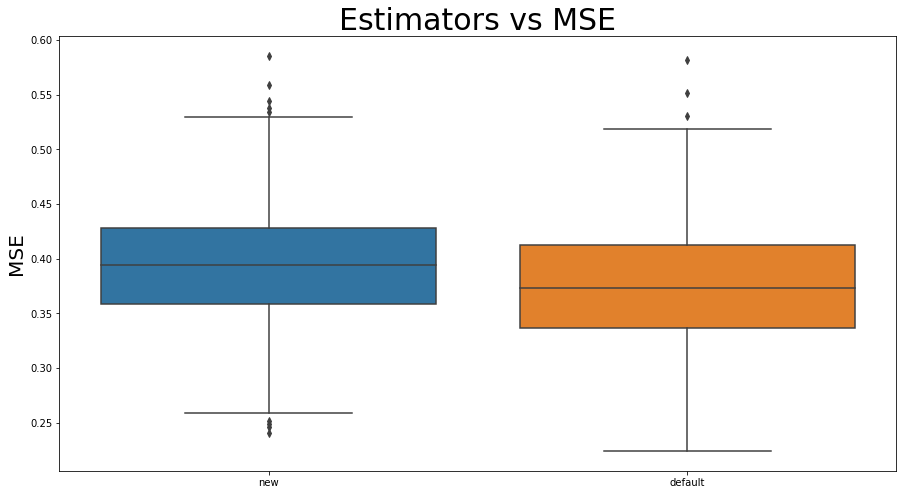

In [ ]:
#Compare default RandomForest vs optimised RandomForest
RF_params = RF_res.best_params

models_RF = {}

models_RF['new'] = RandomForestRegressor(**RF_params, n_estimators = 100)
models_RF['default'] = RandomForestRegressor()

results_RF = train_and_test_regressor(models_RF, X_train, Y_train, X_test, Y_test)
plot_model_comparison(results_RF)

Fitting 10
Fitting 20
Fitting 30
Fitting 40
Fitting 50
Fitting 60
Fitting 70
Fitting 80
Fitting 90
Fitting 100
Fitting 110
Fitting 120
Fitting 130
Fitting 140
Fitting 150
Fitting 160
Fitting 170
Fitting 180
Fitting 190
Fitting 200
Calculating bootstrap score for 10
Calculating bootstrap score for 20
Calculating bootstrap score for 30
Calculating bootstrap score for 40
Calculating bootstrap score for 50
Calculating bootstrap score for 60
Calculating bootstrap score for 70
Calculating bootstrap score for 80
Calculating bootstrap score for 90
Calculating bootstrap score for 100
Calculating bootstrap score for 110
Calculating bootstrap score for 120
Calculating bootstrap score for 130
Calculating bootstrap score for 140
Calculating bootstrap score for 150
Calculating bootstrap score for 160
Calculating bootstrap score for 170
Calculating bootstrap score for 180
Calculating bootstrap score for 190
Calculating bootstrap score for 200


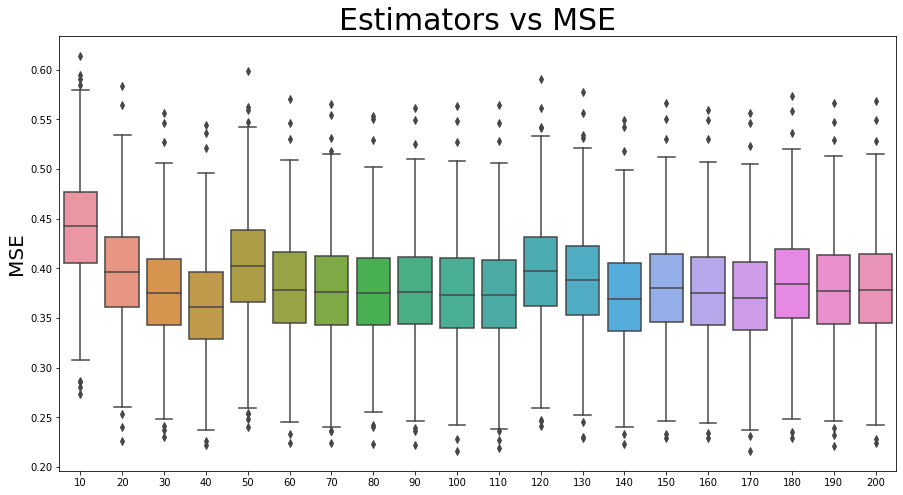

In [ ]:
#Visualising selection of n_estimators
model = {}
for i in range(10, 201, 10):
    model[f'{i}'] = RandomForestRegressor(**RF_params, n_estimators = i)

path = train_and_test_regressor(model, X_train, Y_train, X_test, Y_test)
plot_model_comparison(path)

In [ ]:
optuna.visualization.plot_param_importances(RF_res)

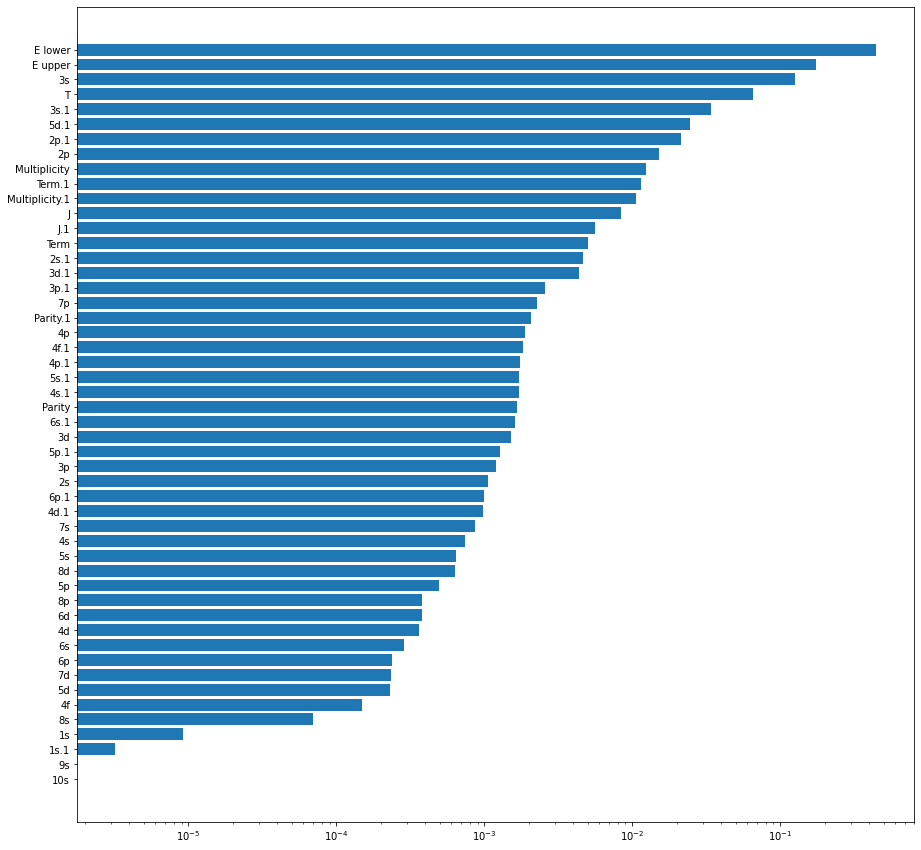

In [ ]:
#Visualising feature importances for the optimal RF model
feature_importance = models_RF['new'].feature_importances_
sorted = np.argsort(feature_importance)
pos = np.arange(sorted.shape[0]) + 0.5

plt.figure(figsize = (15, 15))
plt.barh(pos, feature_importance[sorted])
plt.yticks(pos, np.array(X_train.columns)[sorted])
plt.semilogx()
plt.show()

## Gradient Boosting

In [ ]:
GB_params = {
    'n_estimators' : 100,
    'max_depth' : [1, 50],
    'loss' : ['squared_error', 'absolute_error', 'quantile', 'huber'],
    'learning_rate' : [0.01, 0.1],
    'min_samples_leaf' : [1, 10],
    'nfold' : 5,
    'squared_metrics' : False,
    'n_jobs' : -1
    }

model_name = Gradient_Boosting

GB_res = main(X = X_train, y = Y_train, model_name = model_name, params = GB_params, n_trials = 500)

with open(f'GB_A+I_optimal_parameters', 'w') as fp:
    json.dump(GB_res.best_params, fp)

[I 2023-04-28 20:11:50,664] A new study created in memory with name: no-name-f4708d1d-5e92-452c-a1de-66fc3be3397c


Start hyperparameter optimization


C:\Users\Alex\AppData\Roaming\Python\Python310\site-packages\optuna\progress_bar.py:56: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/1000 [00:00<?, ?it/s]

{'n_estimators': 100, 'learning_rate': 0.04377877826841362, 'loss': 'absolute_error', 'max_depth': 38, 'min_samples_leaf': 4}
{'n_estimators': 100, 'learning_rate': 0.05155140550274367, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 10}
{'n_estimators': 100, 'learning_rate': 0.05562704192878205, 'loss': 'quantile', 'max_depth': 6, 'min_samples_leaf': 9}
{'n_estimators': 100, 'learning_rate': 0.06292698986983825, 'loss': 'absolute_error', 'max_depth': 3, 'min_samples_leaf': 2}
{'n_estimators': 100, 'learning_rate': 0.04101238874619775, 'loss': 'absolute_error', 'max_depth': 16, 'min_samples_leaf': 9}
{'n_estimators': 100, 'learning_rate': 0.020882679048607463, 'loss': 'quantile', 'max_depth': 20, 'min_samples_leaf': 5}
{'n_estimators': 100, 'learning_rate': 0.07963415137172575, 'loss': 'squared_error', 'max_depth': 41, 'min_samples_leaf': 8}
{'n_estimators': 100, 'learning_rate': 0.021843291800139282, 'loss': 'absolute_error', 'max_depth': 29, 'min_samples_leaf': 4}
{'n_e

[I 2023-04-28 20:21:38,111] Trial 21 finished with value: 2.794970322011332 and parameters: {'learning_rate': 0.07461874869593363, 'loss': 'huber', 'max_depth': 47, 'min_samples_leaf': 7}. Best is trial 12 with value: 2.4640216440936236.
{'n_estimators': 100, 'learning_rate': 0.0986132946575935, 'loss': 'huber', 'max_depth': 21, 'min_samples_leaf': 1}
[I 2023-04-28 20:22:48,992] Trial 15 finished with value: 2.7884892859645865 and parameters: {'learning_rate': 0.020456698196514758, 'loss': 'huber', 'max_depth': 19, 'min_samples_leaf': 4}. Best is trial 12 with value: 2.4640216440936236.
{'n_estimators': 100, 'learning_rate': 0.09479501875615223, 'loss': 'huber', 'max_depth': 23, 'min_samples_leaf': 1}
[I 2023-04-28 20:25:48,361] Trial 28 finished with value: 2.4951141131919523 and parameters: {'learning_rate': 0.09887243337360695, 'loss': 'huber', 'max_depth': 22, 'min_samples_leaf': 6}. Best is trial 12 with value: 2.4640216440936236.
{'n_estimators': 100, 'learning_rate': 0.089469308

[I 2023-04-28 20:36:55,229] Trial 7 finished with value: 1.9761392908173694 and parameters: {'learning_rate': 0.04620929502742601, 'loss': 'huber', 'max_depth': 25, 'min_samples_leaf': 2}. Best is trial 7 with value: 1.9761392908173694.
{'n_estimators': 100, 'learning_rate': 0.08018693654180871, 'loss': 'quantile', 'max_depth': 27, 'min_samples_leaf': 1}
[I 2023-04-28 20:40:36,260] Trial 50 finished with value: 2.3862256495139773 and parameters: {'learning_rate': 0.07926041693497879, 'loss': 'quantile', 'max_depth': 40, 'min_samples_leaf': 2}. Best is trial 7 with value: 1.9761392908173694.
{'n_estimators': 100, 'learning_rate': 0.09446537883715403, 'loss': 'absolute_error', 'max_depth': 26, 'min_samples_leaf': 1}
[I 2023-04-28 20:41:24,356] Trial 51 finished with value: 2.496757101961907 and parameters: {'learning_rate': 0.08040513246283598, 'loss': 'quantile', 'max_depth': 40, 'min_samples_leaf': 2}. Best is trial 7 with value: 1.9761392908173694.
{'n_estimators': 100, 'learning_rate

[I 2023-04-28 21:10:11,955] Trial 64 finished with value: 2.4541896319953223 and parameters: {'learning_rate': 0.09275172560508387, 'loss': 'absolute_error', 'max_depth': 15, 'min_samples_leaf': 5}. Best is trial 22 with value: 1.9569856205961689.
{'n_estimators': 100, 'learning_rate': 0.09113606959032176, 'loss': 'huber', 'max_depth': 19, 'min_samples_leaf': 2}
[I 2023-04-28 21:10:14,110] Trial 29 finished with value: 2.1045438682493574 and parameters: {'learning_rate': 0.09730035042395993, 'loss': 'huber', 'max_depth': 49, 'min_samples_leaf': 1}. Best is trial 22 with value: 1.9569856205961689.
{'n_estimators': 100, 'learning_rate': 0.09180410299781026, 'loss': 'huber', 'max_depth': 18, 'min_samples_leaf': 2}
[I 2023-04-28 21:10:31,970] Trial 60 finished with value: 2.1321589289609957 and parameters: {'learning_rate': 0.09394053405996264, 'loss': 'absolute_error', 'max_depth': 16, 'min_samples_leaf': 3}. Best is trial 22 with value: 1.9569856205961689.
{'n_estimators': 100, 'learning

[I 2023-04-28 21:23:47,196] Trial 91 finished with value: 1.9312993357073651 and parameters: {'learning_rate': 0.0890446652410599, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 3}. Best is trial 79 with value: 1.6574240022582973.
{'n_estimators': 100, 'learning_rate': 0.08589019376110753, 'loss': 'huber', 'max_depth': 7, 'min_samples_leaf': 3}
[I 2023-04-28 21:23:54,133] Trial 73 finished with value: 1.7466711223556648 and parameters: {'learning_rate': 0.09274144747397524, 'loss': 'huber', 'max_depth': 18, 'min_samples_leaf': 2}. Best is trial 79 with value: 1.6574240022582973.
{'n_estimators': 100, 'learning_rate': 0.08578773524996453, 'loss': 'huber', 'max_depth': 6, 'min_samples_leaf': 3}
[I 2023-04-28 21:24:01,982] Trial 95 finished with value: 2.2526313798729616 and parameters: {'learning_rate': 0.08737792528110522, 'loss': 'huber', 'max_depth': 8, 'min_samples_leaf': 3}. Best is trial 79 with value: 1.6574240022582973.
{'n_estimators': 100, 'learning_rate': 0.085715397413

[I 2023-04-28 21:31:27,436] Trial 119 finished with value: 2.550873531466397 and parameters: {'learning_rate': 0.09985317086521123, 'loss': 'quantile', 'max_depth': 13, 'min_samples_leaf': 2}. Best is trial 88 with value: 1.639135770138838.
{'n_estimators': 100, 'learning_rate': 0.08144597135916873, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}
[I 2023-04-28 21:32:39,880] Trial 107 finished with value: 1.6777293848058086 and parameters: {'learning_rate': 0.09671302453812448, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 88 with value: 1.639135770138838.
{'n_estimators': 100, 'learning_rate': 0.09855847661202334, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}
[I 2023-04-28 21:32:50,419] Trial 110 finished with value: 1.7776505438853978 and parameters: {'learning_rate': 0.0997004101671943, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 88 with value: 1.639135770138838.
{'n_estimators': 100, 'learning_rate': 0.0981853

[I 2023-04-28 21:40:56,041] Trial 132 finished with value: 1.7690051032533678 and parameters: {'learning_rate': 0.09838912868275845, 'loss': 'huber', 'max_depth': 9, 'min_samples_leaf': 2}. Best is trial 118 with value: 1.5793063670791383.
{'n_estimators': 100, 'learning_rate': 0.08414755953203537, 'loss': 'quantile', 'max_depth': 16, 'min_samples_leaf': 2}
[I 2023-04-28 21:41:04,665] Trial 126 finished with value: 1.6916686289057281 and parameters: {'learning_rate': 0.09823076360908123, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 2}. Best is trial 118 with value: 1.5793063670791383.
{'n_estimators': 100, 'learning_rate': 0.09988821281180865, 'loss': 'quantile', 'max_depth': 16, 'min_samples_leaf': 2}
[I 2023-04-28 21:41:52,893] Trial 125 finished with value: 1.7897816981410877 and parameters: {'learning_rate': 0.08203557253033106, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 2}. Best is trial 118 with value: 1.5793063670791383.
{'n_estimators': 100, 'learning_rate':

{'n_estimators': 100, 'learning_rate': 0.09684099557761726, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}
[I 2023-04-28 21:52:48,536] Trial 158 finished with value: 2.2718935827758893 and parameters: {'learning_rate': 0.09420482494396433, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 3}. Best is trial 118 with value: 1.5793063670791383.
{'n_estimators': 100, 'learning_rate': 0.09686588426380349, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}
[I 2023-04-28 21:53:31,016] Trial 153 finished with value: 1.9381917099935468 and parameters: {'learning_rate': 0.09362230967269927, 'loss': 'huber', 'max_depth': 17, 'min_samples_leaf': 3}. Best is trial 118 with value: 1.5793063670791383.
{'n_estimators': 100, 'learning_rate': 0.09714761293510217, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}
[I 2023-04-28 21:54:14,913] Trial 146 finished with value: 2.216214302368722 and parameters: {'learning_rate': 0.09982826336448249, 'loss': 'huber', 'max_depth': 14, '

[I 2023-04-28 22:06:10,956] Trial 174 finished with value: 1.6422677524919844 and parameters: {'learning_rate': 0.09591922118357635, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 118 with value: 1.5793063670791383.
{'n_estimators': 100, 'learning_rate': 0.09165707931585061, 'loss': 'huber', 'max_depth': 9, 'min_samples_leaf': 2}
[I 2023-04-28 22:06:41,497] Trial 177 finished with value: 1.656048626715189 and parameters: {'learning_rate': 0.09206109616088226, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 2}. Best is trial 118 with value: 1.5793063670791383.
{'n_estimators': 100, 'learning_rate': 0.09146926113007423, 'loss': 'huber', 'max_depth': 9, 'min_samples_leaf': 2}
[I 2023-04-28 22:07:12,490] Trial 178 finished with value: 1.718796077050681 and parameters: {'learning_rate': 0.09164936427093932, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 2}. Best is trial 118 with value: 1.5793063670791383.
{'n_estimators': 100, 'learning_rate': 0.091417

[I 2023-04-28 22:14:21,950] Trial 197 finished with value: 1.8590345887164073 and parameters: {'learning_rate': 0.08780514813122582, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 2}. Best is trial 118 with value: 1.5793063670791383.
{'n_estimators': 100, 'learning_rate': 0.09504594347362263, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}
[I 2023-04-28 22:14:44,615] Trial 199 finished with value: 1.8684339493296942 and parameters: {'learning_rate': 0.08745842089730081, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 2}. Best is trial 118 with value: 1.5793063670791383.
{'n_estimators': 100, 'learning_rate': 0.09494572981356353, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}
[I 2023-04-28 22:14:46,980] Trial 201 finished with value: 1.8965461936907377 and parameters: {'learning_rate': 0.08999619932808595, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 2}. Best is trial 118 with value: 1.5793063670791383.
{'n_estimators': 100, 'learning_rate': 0.09

{'n_estimators': 100, 'learning_rate': 0.05876619606778166, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 2}
[I 2023-04-28 22:24:23,564] Trial 220 finished with value: 1.7536178358895556 and parameters: {'learning_rate': 0.09813205289709923, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 118 with value: 1.5793063670791383.
{'n_estimators': 100, 'learning_rate': 0.09806138998744494, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 2}
[I 2023-04-28 22:24:34,985] Trial 221 finished with value: 1.7758806859305416 and parameters: {'learning_rate': 0.09808096667547683, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 118 with value: 1.5793063670791383.
{'n_estimators': 100, 'learning_rate': 0.055149808272897, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 2}
[I 2023-04-28 22:25:00,588] Trial 222 finished with value: 1.6670259221209824 and parameters: {'learning_rate': 0.09829314774687531, 'loss': 'huber', 'max_depth': 12, 'm

[I 2023-04-28 22:39:17,859] Trial 238 finished with value: 1.9053296979903895 and parameters: {'learning_rate': 0.07049840346568821, 'loss': 'huber', 'max_depth': 14, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.09597802066719144, 'loss': 'huber', 'max_depth': 15, 'min_samples_leaf': 2}
[I 2023-04-28 22:40:03,906] Trial 237 finished with value: 1.9083321493504024 and parameters: {'learning_rate': 0.05297281483678706, 'loss': 'huber', 'max_depth': 14, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.09621792924155732, 'loss': 'absolute_error', 'max_depth': 11, 'min_samples_leaf': 2}
[I 2023-04-28 22:40:51,606] Trial 245 finished with value: 1.8482791752625594 and parameters: {'learning_rate': 0.0929276941910582, 'loss': 'huber', 'max_depth': 14, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rat

[I 2023-04-28 22:51:24,320] Trial 265 finished with value: 1.9992745223194532 and parameters: {'learning_rate': 0.09942392861156084, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 1}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.09085380026264475, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 2}
[I 2023-04-28 22:51:30,659] Trial 273 finished with value: 2.117171985895074 and parameters: {'learning_rate': 0.06699604967379405, 'loss': 'huber', 'max_depth': 8, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.09067336523765525, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 2}
[I 2023-04-28 22:51:42,124] Trial 255 finished with value: 2.172933166203669 and parameters: {'learning_rate': 0.04226453008063977, 'loss': 'huber', 'max_depth': 15, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.09021

{'n_estimators': 100, 'learning_rate': 0.09464423589777604, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 2}
[I 2023-04-28 23:08:11,388] Trial 294 finished with value: 1.7204968741544853 and parameters: {'learning_rate': 0.09770743399225289, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.08046705409271318, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}
[I 2023-04-28 23:10:44,301] Trial 291 finished with value: 1.9698609151363506 and parameters: {'learning_rate': 0.09754862513866805, 'loss': 'huber', 'max_depth': 21, 'min_samples_leaf': 3}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.09452689688668879, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}
[I 2023-04-28 23:11:06,825] Trial 295 finished with value: 1.6543713946451166 and parameters: {'learning_rate': 0.09466028756633414, 'loss': 'huber', 'max_depth': 12, 

[I 2023-04-28 23:24:28,336] Trial 314 finished with value: 1.7875376353785353 and parameters: {'learning_rate': 0.09214946186767049, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.01384399513673324, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 2}
[I 2023-04-28 23:26:38,065] Trial 316 finished with value: 1.7496470535145434 and parameters: {'learning_rate': 0.09549323598936477, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.0836283635253603, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 2}
[I 2023-04-28 23:27:48,865] Trial 319 finished with value: 1.7414081036335927 and parameters: {'learning_rate': 0.09485976428899227, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.096

{'n_estimators': 100, 'learning_rate': 0.07649674125828697, 'loss': 'huber', 'max_depth': 7, 'min_samples_leaf': 2}
[I 2023-04-28 23:42:02,226] Trial 312 finished with value: 1.7782935488504372 and parameters: {'learning_rate': 0.0930037705439897, 'loss': 'huber', 'max_depth': 34, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.0631131712074204, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}
[I 2023-04-28 23:42:24,231] Trial 336 finished with value: 1.7383961244966073 and parameters: {'learning_rate': 0.07700962015226284, 'loss': 'huber', 'max_depth': 14, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.07593974917108122, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}
[I 2023-04-28 23:42:30,472] Trial 335 finished with value: 1.799155382295367 and parameters: {'learning_rate': 0.0752355375790309, 'loss': 'huber', 'max_depth': 14, 'min_

[I 2023-04-28 23:54:41,535] Trial 356 finished with value: 1.7418526988597745 and parameters: {'learning_rate': 0.07371016046268164, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.06422905706832066, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 3}
[I 2023-04-28 23:55:07,716] Trial 358 finished with value: 1.7618760838355065 and parameters: {'learning_rate': 0.08825218463828585, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.09833007880185952, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 3}
[I 2023-04-28 23:55:22,841] Trial 363 finished with value: 2.1847468931462437 and parameters: {'learning_rate': 0.0883090124975997, 'loss': 'huber', 'max_depth': 8, 'min_samples_leaf': 3}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.0982

{'n_estimators': 100, 'learning_rate': 0.08648147636957139, 'loss': 'huber', 'max_depth': 17, 'min_samples_leaf': 9}
[I 2023-04-29 00:08:36,678] Trial 374 finished with value: 2.0119072018408786 and parameters: {'learning_rate': 0.09830264099153263, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 1}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.09094981458821683, 'loss': 'huber', 'max_depth': 39, 'min_samples_leaf': 2}
[I 2023-04-29 00:08:40,372] Trial 380 finished with value: 1.7654711679138586 and parameters: {'learning_rate': 0.09417449408556088, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.09111469882852648, 'loss': 'huber', 'max_depth': 5, 'min_samples_leaf': 2}
[I 2023-04-29 00:08:51,990] Trial 375 finished with value: 2.1025479585950477 and parameters: {'learning_rate': 0.09820215928909513, 'loss': 'huber', 'max_depth': 13, '

[I 2023-04-29 00:19:43,923] Trial 406 finished with value: 1.6927947290454282 and parameters: {'learning_rate': 0.08508345606704515, 'loss': 'huber', 'max_depth': 9, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.08203684099377676, 'loss': 'huber', 'max_depth': 39, 'min_samples_leaf': 7}
[I 2023-04-29 00:20:01,740] Trial 408 finished with value: 1.794588538822684 and parameters: {'learning_rate': 0.09599638910587513, 'loss': 'huber', 'max_depth': 9, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.05353912893732678, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 2}
[I 2023-04-29 00:20:34,577] Trial 402 finished with value: 2.3676186521891824 and parameters: {'learning_rate': 0.08976797627064174, 'loss': 'quantile', 'max_depth': 39, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.07

[I 2023-04-29 00:39:25,915] Trial 428 finished with value: 1.7362989790759897 and parameters: {'learning_rate': 0.09661017915062545, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.09292382383395653, 'loss': 'huber', 'max_depth': 14, 'min_samples_leaf': 2}
[I 2023-04-29 00:39:59,158] Trial 426 finished with value: 1.7348565449362503 and parameters: {'learning_rate': 0.07879098917855579, 'loss': 'huber', 'max_depth': 14, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.09302131391761927, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}
[I 2023-04-29 00:40:06,402] Trial 433 finished with value: 1.9711380368728182 and parameters: {'learning_rate': 0.09296756448097841, 'loss': 'huber', 'max_depth': 8, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.062

{'n_estimators': 100, 'learning_rate': 0.06526040977872702, 'loss': 'huber', 'max_depth': 15, 'min_samples_leaf': 3}
[I 2023-04-29 01:00:38,856] Trial 451 finished with value: 2.3643627603957436 and parameters: {'learning_rate': 0.09474909860953094, 'loss': 'huber', 'max_depth': 16, 'min_samples_leaf': 5}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.0921250539430812, 'loss': 'squared_error', 'max_depth': 13, 'min_samples_leaf': 3}
[I 2023-04-29 01:01:02,750] Trial 458 finished with value: 2.605560424778135 and parameters: {'learning_rate': 0.0921250539430812, 'loss': 'squared_error', 'max_depth': 13, 'min_samples_leaf': 3}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.09750720231148637, 'loss': 'huber', 'max_depth': 15, 'min_samples_leaf': 2}
[I 2023-04-29 01:01:20,320] Trial 452 finished with value: 2.3022912795972177 and parameters: {'learning_rate': 0.09506617527233943, 'loss': 'huber', 'max

[I 2023-04-29 01:19:43,255] Trial 471 finished with value: 2.0642561691597736 and parameters: {'learning_rate': 0.09807053389795625, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 1}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.09953096772624077, 'loss': 'huber', 'max_depth': 30, 'min_samples_leaf': 2}
[I 2023-04-29 01:20:10,516] Trial 468 finished with value: 1.88565989162237 and parameters: {'learning_rate': 0.05676885917965157, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.05165651519171295, 'loss': 'squared_error', 'max_depth': 35, 'min_samples_leaf': 2}
[I 2023-04-29 01:20:45,386] Trial 481 finished with value: 2.3984156035363315 and parameters: {'learning_rate': 0.05165651519171295, 'loss': 'squared_error', 'max_depth': 35, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learni

{'n_estimators': 100, 'learning_rate': 0.08169366794214389, 'loss': 'huber', 'max_depth': 14, 'min_samples_leaf': 2}
[I 2023-04-29 01:38:35,735] Trial 498 finished with value: 2.8265677461838647 and parameters: {'learning_rate': 0.0922120817426269, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 8}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.0825947766506571, 'loss': 'huber', 'max_depth': 14, 'min_samples_leaf': 2}
[I 2023-04-29 01:39:06,317] Trial 494 finished with value: 1.910812853653009 and parameters: {'learning_rate': 0.07151649030077599, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.09058591602218194, 'loss': 'huber', 'max_depth': 14, 'min_samples_leaf': 2}
[I 2023-04-29 01:42:25,865] Trial 480 finished with value: 1.730961993724673 and parameters: {'learning_rate': 0.09953096772624077, 'loss': 'huber', 'max_depth': 30, 'min

[I 2023-04-29 02:04:54,398] Trial 517 finished with value: 1.9536259895273438 and parameters: {'learning_rate': 0.043188464360981206, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 1}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.08878164245000408, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 3}
[I 2023-04-29 02:04:57,768] Trial 521 finished with value: 1.9041523485010408 and parameters: {'learning_rate': 0.09382982238032475, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 3}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.036742866804302235, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}
[I 2023-04-29 02:05:10,716] Trial 512 finished with value: 1.8564684010163561 and parameters: {'learning_rate': 0.09590065681008715, 'loss': 'huber', 'max_depth': 19, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.

[I 2023-04-29 02:15:38,734] Trial 537 finished with value: 1.7889600975646893 and parameters: {'learning_rate': 0.07865975173960998, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.09379766750095198, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 2}
[I 2023-04-29 02:16:03,568] Trial 535 finished with value: 2.555641327996152 and parameters: {'learning_rate': 0.020147856801692836, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.09354380763224132, 'loss': 'absolute_error', 'max_depth': 10, 'min_samples_leaf': 2}
[I 2023-04-29 02:16:27,577] Trial 536 finished with value: 2.2626208827596184 and parameters: {'learning_rate': 0.02933110390360467, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_ra

{'n_estimators': 100, 'learning_rate': 0.043065190153347976, 'loss': 'huber', 'max_depth': 37, 'min_samples_leaf': 2}
[I 2023-04-29 02:29:25,484] Trial 556 finished with value: 1.8225353261610742 and parameters: {'learning_rate': 0.09089497376749062, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.07471517010760481, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 2}
[I 2023-04-29 02:29:28,853] Trial 555 finished with value: 1.6911570406214966 and parameters: {'learning_rate': 0.06827409381751622, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.09139645606494544, 'loss': 'huber', 'max_depth': 17, 'min_samples_leaf': 2}
[I 2023-04-29 02:29:58,328] Trial 563 finished with value: 1.9614879116918171 and parameters: {'learning_rate': 0.06071215613060228, 'loss': 'huber', 'max_depth': 11,

[I 2023-04-29 02:40:38,447] Trial 577 finished with value: 1.9275178246929 and parameters: {'learning_rate': 0.0918061211798548, 'loss': 'huber', 'max_depth': 16, 'min_samples_leaf': 3}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.09507643094050595, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}
[I 2023-04-29 02:41:43,986] Trial 571 finished with value: 1.7773850366921244 and parameters: {'learning_rate': 0.09139645606494544, 'loss': 'huber', 'max_depth': 17, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.09534135202882382, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}
[I 2023-04-29 02:42:07,762] Trial 586 finished with value: 2.7373108917970352 and parameters: {'learning_rate': 0.07852632846759428, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 7}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.095385

{'n_estimators': 100, 'learning_rate': 0.0970629454464202, 'loss': 'huber', 'max_depth': 14, 'min_samples_leaf': 1}
[I 2023-04-29 02:53:35,475] Trial 597 finished with value: 1.5912342141836517 and parameters: {'learning_rate': 0.09532090456011402, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.09759905185464207, 'loss': 'huber', 'max_depth': 14, 'min_samples_leaf': 1}
[I 2023-04-29 02:53:59,001] Trial 569 finished with value: 2.266719065152863 and parameters: {'learning_rate': 0.043065190153347976, 'loss': 'huber', 'max_depth': 37, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.059238725183409315, 'loss': 'huber', 'max_depth': 14, 'min_samples_leaf': 1}
[I 2023-04-29 02:54:11,052] Trial 598 finished with value: 1.748688855372297 and parameters: {'learning_rate': 0.09676357415788109, 'loss': 'huber', 'max_depth': 12, '

{'n_estimators': 100, 'learning_rate': 0.03450729162822606, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 2}
[I 2023-04-29 03:13:23,255] Trial 633 finished with value: 1.8982793686478714 and parameters: {'learning_rate': 0.09991221200979881, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.08330940012000307, 'loss': 'huber', 'max_depth': 16, 'min_samples_leaf': 2}
[I 2023-04-29 03:14:09,379] Trial 634 finished with value: 1.8079094909921412 and parameters: {'learning_rate': 0.0948350696377394, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.08420566028599524, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 2}
[I 2023-04-29 03:15:31,450] Trial 626 finished with value: 1.8137510187937433 and parameters: {'learning_rate': 0.09614983593507051, 'loss': 'huber', 'max_depth': 15, '

[I 2023-04-29 03:29:33,371] Trial 645 finished with value: 2.258684205055475 and parameters: {'learning_rate': 0.03477004433003303, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.08986379129074544, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 2}
[I 2023-04-29 03:30:32,950] Trial 655 finished with value: 2.019138189707023 and parameters: {'learning_rate': 0.09473894105537009, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 3}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.07711588505334274, 'loss': 'quantile', 'max_depth': 12, 'min_samples_leaf': 2}
[I 2023-04-29 03:30:40,714] Trial 650 finished with value: 2.4399242002978316 and parameters: {'learning_rate': 0.029037819095308972, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 3}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.

{'n_estimators': 100, 'learning_rate': 0.09299140127601893, 'loss': 'huber', 'max_depth': 8, 'min_samples_leaf': 2}
[I 2023-04-29 03:40:55,651] Trial 665 finished with value: 1.7229263534750747 and parameters: {'learning_rate': 0.0586871864981349, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.06356124645216314, 'loss': 'huber', 'max_depth': 8, 'min_samples_leaf': 2}
[I 2023-04-29 03:42:20,061] Trial 674 finished with value: 2.0128546785342527 and parameters: {'learning_rate': 0.05836677848801184, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.04220563585945868, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 2}
[I 2023-04-29 03:42:40,162] Trial 683 finished with value: 2.34676250385393 and parameters: {'learning_rate': 0.04220563585945868, 'loss': 'squared_error', 'max_de

[I 2023-04-29 03:58:45,942] Trial 695 finished with value: 2.023214041471992 and parameters: {'learning_rate': 0.039027453251102885, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.09846070148095573, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 2}
[I 2023-04-29 03:58:47,796] Trial 699 finished with value: 1.7012705162229511 and parameters: {'learning_rate': 0.09600976628817187, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.09865852890760339, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 2}
[I 2023-04-29 03:58:55,622] Trial 668 finished with value: 2.1505101485129408 and parameters: {'learning_rate': 0.0423297236100194, 'loss': 'huber', 'max_depth': 32, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.098

{'n_estimators': 100, 'learning_rate': 0.0911422913478509, 'loss': 'huber', 'max_depth': 14, 'min_samples_leaf': 2}
[I 2023-04-29 04:19:21,995] Trial 698 finished with value: 1.7810619150248688 and parameters: {'learning_rate': 0.07056649473490188, 'loss': 'huber', 'max_depth': 32, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.08232250316806802, 'loss': 'huber', 'max_depth': 24, 'min_samples_leaf': 3}
[I 2023-04-29 04:20:03,725] Trial 722 finished with value: 1.8261216564575549 and parameters: {'learning_rate': 0.09271442055008387, 'loss': 'huber', 'max_depth': 9, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.09046586865631008, 'loss': 'huber', 'max_depth': 14, 'min_samples_leaf': 3}
[I 2023-04-29 04:20:12,889] Trial 720 finished with value: 1.820700320467895 and parameters: {'learning_rate': 0.07306273839879722, 'loss': 'huber', 'max_depth': 9, 'min

[I 2023-04-29 04:34:12,805] Trial 740 finished with value: 1.7212580305695764 and parameters: {'learning_rate': 0.09491511786163415, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.09694852216147429, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 1}
[I 2023-04-29 04:34:24,261] Trial 733 finished with value: 1.991767114056465 and parameters: {'learning_rate': 0.04961979522172126, 'loss': 'huber', 'max_depth': 14, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.09496166874329885, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 2}
[I 2023-04-29 04:35:25,039] Trial 741 finished with value: 1.7958659214553339 and parameters: {'learning_rate': 0.09430145071732274, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.096

[I 2023-04-29 04:43:58,776] Trial 754 finished with value: 2.1989703841002393 and parameters: {'learning_rate': 0.04627185176844302, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.09267806866280302, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 2}
[I 2023-04-29 04:44:09,433] Trial 763 finished with value: 2.2704659861714336 and parameters: {'learning_rate': 0.097353522975188, 'loss': 'absolute_error', 'max_depth': 13, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.05353866421954849, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 2}
[I 2023-04-29 04:44:25,018] Trial 761 finished with value: 2.3547101456435877 and parameters: {'learning_rate': 0.0881156868302731, 'loss': 'absolute_error', 'max_depth': 13, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learn

[I 2023-04-29 05:00:08,055] Trial 785 finished with value: 1.7954786318485578 and parameters: {'learning_rate': 0.08750941486638357, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.08974754956932596, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 6}
[I 2023-04-29 05:00:16,647] Trial 786 finished with value: 3.077583935945713 and parameters: {'learning_rate': 0.09029417283250701, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 10}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.08968611394702639, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 2}
[I 2023-04-29 05:00:21,762] Trial 783 finished with value: 2.1264665338334434 and parameters: {'learning_rate': 0.032649364888640994, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.0

{'n_estimators': 100, 'learning_rate': 0.01914574989082439, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}
[I 2023-04-29 05:10:51,946] Trial 812 finished with value: 2.7426972080089027 and parameters: {'learning_rate': 0.044209693854324536, 'loss': 'squared_error', 'max_depth': 50, 'min_samples_leaf': 3}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.0797062478979386, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}
[I 2023-04-29 05:11:01,844] Trial 807 finished with value: 2.908946060243858 and parameters: {'learning_rate': 0.07414332907280126, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 9}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.016691407499315247, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}
[I 2023-04-29 05:15:51,366] Trial 779 finished with value: 2.011139419914759 and parameters: {'learning_rate': 0.0520513880528061, 'loss': 'huber', 'max_depth'

[I 2023-04-29 05:30:29,331] Trial 801 finished with value: 1.7981049279417707 and parameters: {'learning_rate': 0.0848231618859318, 'loss': 'huber', 'max_depth': 50, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.0957710720519749, 'loss': 'huber', 'max_depth': 8, 'min_samples_leaf': 1}
[I 2023-04-29 05:31:33,860] Trial 824 finished with value: 1.8622382415976593 and parameters: {'learning_rate': 0.041888008901673, 'loss': 'huber', 'max_depth': 15, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.09572086369044563, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 1}
[I 2023-04-29 05:31:48,355] Trial 834 finished with value: 2.3848994227148874 and parameters: {'learning_rate': 0.09558000679852695, 'loss': 'huber', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.08121828

{'n_estimators': 100, 'learning_rate': 0.018497566244872837, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 3}
[I 2023-04-29 05:43:18,696] Trial 847 finished with value: 1.7538973393725203 and parameters: {'learning_rate': 0.0677207943320316, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.03703736763548382, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 2}
[I 2023-04-29 05:44:42,586] Trial 833 finished with value: 2.0506256833251326 and parameters: {'learning_rate': 0.09525668757145322, 'loss': 'huber', 'max_depth': 15, 'min_samples_leaf': 1}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.09846048106570393, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 2}
[I 2023-04-29 05:47:56,855] Trial 850 finished with value: 1.903588836043804 and parameters: {'learning_rate': 0.09991936957049255, 'loss': 'huber', 'max_depth': 13, '

[I 2023-04-29 05:55:51,521] Trial 881 finished with value: 2.3875519007906645 and parameters: {'learning_rate': 0.056987059470425414, 'loss': 'squared_error', 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
[I 2023-04-29 05:55:51,871] Trial 864 finished with value: 2.2521283053208747 and parameters: {'learning_rate': 0.04102590537857439, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 3}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.0967222606020706, 'loss': 'quantile', 'max_depth': 11, 'min_samples_leaf': 2}
{'n_estimators': 100, 'learning_rate': 0.09682635930802491, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 2}
[I 2023-04-29 05:57:05,051] Trial 866 finished with value: 1.7151007156388733 and parameters: {'learning_rate': 0.07066490659824086, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_

[I 2023-04-29 06:09:38,934] Trial 900 finished with value: 2.0405934410669255 and parameters: {'learning_rate': 0.09034471446926727, 'loss': 'huber', 'max_depth': 14, 'min_samples_leaf': 3}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.05522216991592843, 'loss': 'huber', 'max_depth': 14, 'min_samples_leaf': 1}
[I 2023-04-29 06:09:56,011] Trial 896 finished with value: 1.8003860112889427 and parameters: {'learning_rate': 0.09009548134844753, 'loss': 'huber', 'max_depth': 14, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.0868034466299838, 'loss': 'huber', 'max_depth': 7, 'min_samples_leaf': 6}
[I 2023-04-29 06:10:50,476] Trial 895 finished with value: 1.7891081789098144 and parameters: {'learning_rate': 0.05908661653067227, 'loss': 'huber', 'max_depth': 14, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.0385

{'n_estimators': 100, 'learning_rate': 0.09994548294753139, 'loss': 'absolute_error', 'max_depth': 12, 'min_samples_leaf': 2}
[I 2023-04-29 06:23:35,529] Trial 919 finished with value: 2.3429640003216554 and parameters: {'learning_rate': 0.0793813481559977, 'loss': 'absolute_error', 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.09829901616989309, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}
[I 2023-04-29 06:23:39,959] Trial 916 finished with value: 1.72061271007768 and parameters: {'learning_rate': 0.07613714677156785, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.09842370816498414, 'loss': 'huber', 'max_depth': 17, 'min_samples_leaf': 2}
[I 2023-04-29 06:24:16,457] Trial 920 finished with value: 2.1418291380040255 and parameters: {'learning_rate': 0.09439021792104614, 'loss': 'absolute_e

{'n_estimators': 100, 'learning_rate': 0.09811513941702697, 'loss': 'huber', 'max_depth': 17, 'min_samples_leaf': 2}
[I 2023-04-29 06:36:03,644] Trial 929 finished with value: 1.7699644683298839 and parameters: {'learning_rate': 0.09842370816498414, 'loss': 'huber', 'max_depth': 17, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.09786222955482503, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 2}
[I 2023-04-29 06:39:10,582] Trial 943 finished with value: 1.6651533269533494 and parameters: {'learning_rate': 0.09788331031133918, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.09609228403760287, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 2}
[I 2023-04-29 06:40:45,601] Trial 946 finished with value: 1.836441369413901 and parameters: {'learning_rate': 0.09832753537806062, 'loss': 'huber', 'max_depth': 13, '

[I 2023-04-29 06:54:01,521] Trial 963 finished with value: 1.5699633471302152 and parameters: {'learning_rate': 0.09448031528977677, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.0938636788149614, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 2}
[I 2023-04-29 06:55:28,620] Trial 964 finished with value: 1.6237564516937701 and parameters: {'learning_rate': 0.09390334989175417, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.09999533197238239, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 2}
[I 2023-04-29 06:55:58,034] Trial 965 finished with value: 1.7980646581372983 and parameters: {'learning_rate': 0.0936436050160744, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.0997

{'n_estimators': 100, 'learning_rate': 0.06999385628188023, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 3}
[I 2023-04-29 07:04:32,104] Trial 984 finished with value: 2.033494215668084 and parameters: {'learning_rate': 0.0966992041375475, 'loss': 'huber', 'max_depth': 9, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.06206962659930435, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 3}
[I 2023-04-29 07:07:00,320] Trial 985 finished with value: 1.8227591889294428 and parameters: {'learning_rate': 0.09669880857198068, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.09208226833005898, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 3}
[I 2023-04-29 07:07:41,009] Trial 988 finished with value: 3.1902555886959933 and parameters: {'learning_rate': 0.012336333901925373, 'loss': 'huber', 'max_depth': 11, 'm

Fitting new
Fitting default
Calculating bootstrap score for new
Calculating bootstrap score for default


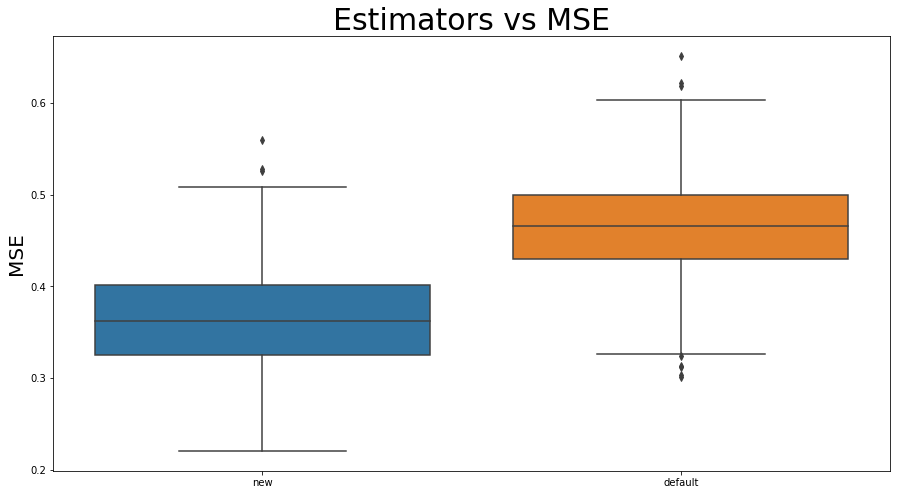

In [ ]:
#Compare default GradientBoosting vs optimised GradientBoosting
GB_params = GB_res.best_params

models_GB = {}

models_GB['new'] = GradientBoostingRegressor(**GB_params, n_estimators = 500)
models_GB['default'] = GradientBoostingRegressor()

results_GB = train_and_test_regressor(models_GB, X_train, Y_train, X_test, Y_test)
plot_model_comparison(results_GB)

In [ ]:
#Visualising importance of GB model parameters
optuna.visualization.plot_param_importances(GB_res)

/usr/local/lib/python3.9/dist-packages/sklearn/utils/deprecation.py:101: FutureWarning:

Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.



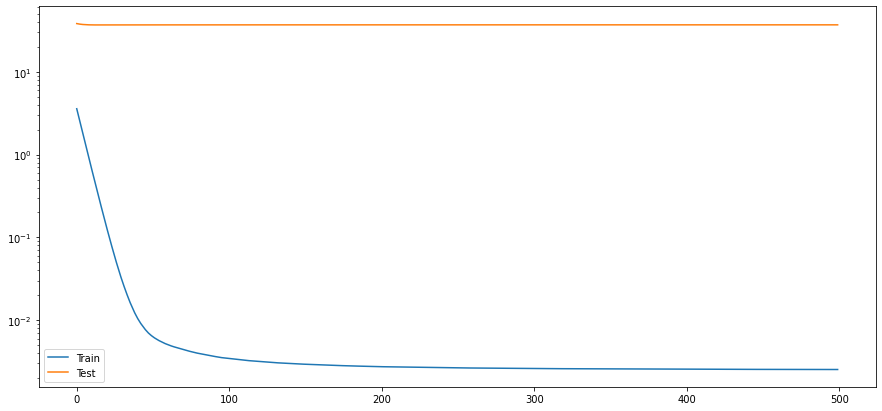

In [ ]:
#Visualising selection of n_estimators and potential overfitting
test_score = np.zeros((500))
for i, y_pred in enumerate(models_GB['new'].staged_predict(XS_test)):
    test_score[i] = models_GB['new'].loss_(YS_test, y_pred)
plt.figure(figsize = (15, 7))
plt.plot(models_GB['new'].train_score_, label = 'Train')
plt.plot(test_score, label = 'Test')
plt.semilogy()
plt.legend()
plt.show()

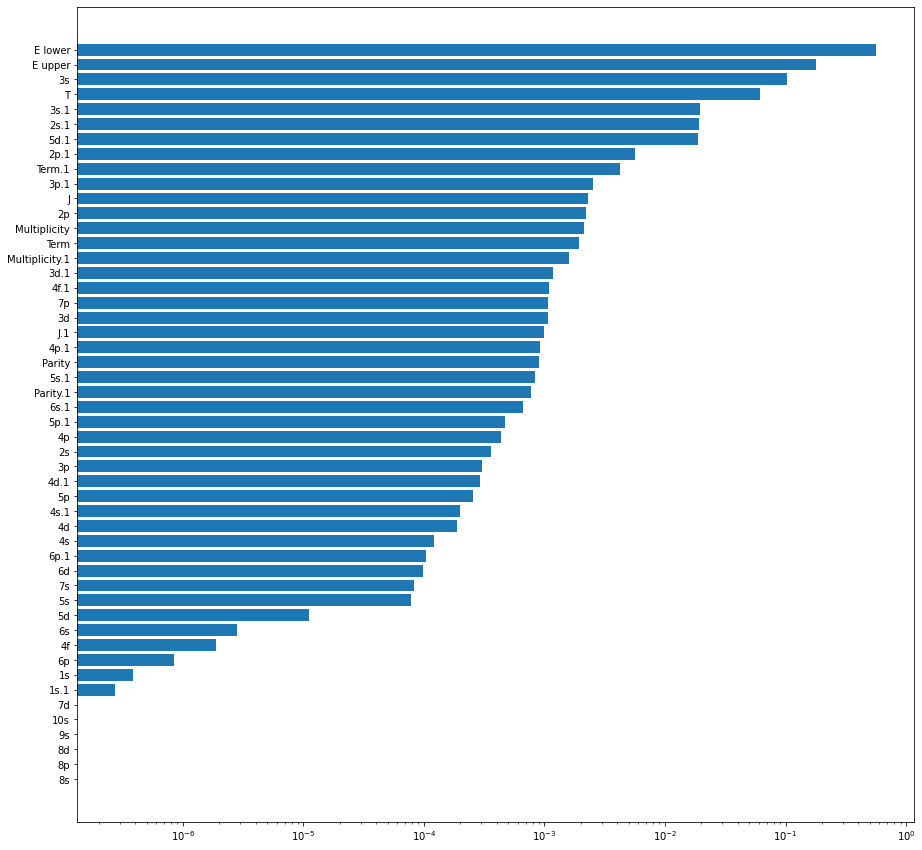

In [ ]:
#Visualising feature importances for the optimal RF model
feature_importance = models_GB['new'].feature_importances_
sorted = np.argsort(feature_importance)
pos = np.arange(sorted.shape[0]) + 0.5

plt.figure(figsize = (15, 15))
plt.barh(pos, feature_importance[sorted])
plt.yticks(pos, np.array(XS_train.columns)[sorted])
plt.semilogx()
plt.show()

## XGBoost

In [ ]:
XGB_params = {
    'n_estimators' : 500,
    'learning_rate' : [0.01, 0.5],
    'max_depth' : [1, 20],
    'min_child_weight' : [1, 15],
    'reg_alpha' : [1e-8, 10],
    'reg_lambda' : [1e-8, 10],
    'nfold' : 5,
    'squared_metrics' : False,
    'n_jobs' : -1
    }

model_name = XGBoost

if apply_scaler:
    XGB_res = main(X = pd.DataFrame(scaler.transform(X_train)), y = Y_train, model_name = model_name, params = XGB_params, n_trials = 500)
else:
    XGB_res = main(X = X_train, y = Y_train, model_name = model_name, params = XGB_params, n_trials = 500)

with open(f'XGB_A+I_StandardScaler_Scaled_optimal_parameters', 'w') as fp:
    json.dump(XGB_res.best_params, fp)

[I 2023-05-03 00:33:37,313] A new study created in memory with name: no-name-2000ff61-986c-4495-ba8a-5eaac683f495


Start hyperparameter optimization


C:\Users\Alex\AppData\Roaming\Python\Python310\site-packages\optuna\progress_bar.py:56: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/500 [00:00<?, ?it/s]

{'n_estimators': 500, 'max_depth': 20, 'learning_rate': 0.29388023450758155, 'min_child_weight': 15, 'reg_alpha': 0.2646982329561202, 'reg_lambda': 3.9930114662587014e-05}
{'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.3677906981329149, 'min_child_weight': 8, 'reg_alpha': 0.0038664345260137727, 'reg_lambda': 1.956254570372456e-05}
{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.42566556982491177, 'min_child_weight': 15, 'reg_alpha': 5.45909963803959e-08, 'reg_lambda': 2.6557873886863674e-06}
{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.4047897189578473, 'min_child_weight': 4, 'reg_alpha': 0.30991922182500725, 'reg_lambda': 8.081832350804885e-08}
{'n_estimators': 500, 'max_depth': 11, 'learning_rate': 0.37120464168876843, 'min_child_weight': 6, 'reg_alpha': 0.00016469007245107484, 'reg_lambda': 0.03341637448019458}
{'n_estimators': 500, 'max_depth': 17, 'learning_rate': 0.3882706722011116, 'min_child_weight': 2, 'reg_alpha': 9.046856751772835e-07, 'reg_la

[I 2023-05-03 00:35:16,529] Trial 20 finished with value: 0.43119363526277504 and parameters: {'max_depth': 3, 'learning_rate': 0.05639058263248767, 'min_child_weight': 15, 'reg_alpha': 1.6931383933689865e-08, 'reg_lambda': 0.018378697594926306}. Best is trial 14 with value: 0.35407982239821295.
{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.141571674189109, 'min_child_weight': 11, 'reg_alpha': 7.359846363266504e-06, 'reg_lambda': 0.6547036097205774}
[I 2023-05-03 00:35:19,422] Trial 10 finished with value: 0.3751469906265986 and parameters: {'max_depth': 20, 'learning_rate': 0.36870995575946786, 'min_child_weight': 7, 'reg_alpha': 7.286450545674252e-08, 'reg_lambda': 0.00046551329111690323}. Best is trial 14 with value: 0.35407982239821295.
{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.14261961785708416, 'min_child_weight': 11, 'reg_alpha': 7.200570655864835e-06, 'reg_lambda': 0.26959503220565373}
[I 2023-05-03 00:35:24,273] Trial 17 finished with value: 0.3845350

[I 2023-05-03 00:36:53,883] Trial 34 finished with value: 0.34667655102280415 and parameters: {'max_depth': 7, 'learning_rate': 0.15122446096551728, 'min_child_weight': 10, 'reg_alpha': 1.6482696723581037e-08, 'reg_lambda': 1.5874632087123093}. Best is trial 31 with value: 0.3458066102654495.
{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.21631746722208822, 'min_child_weight': 9, 'reg_alpha': 2.8338628043492336e-07, 'reg_lambda': 8.1729428660673}
[I 2023-05-03 00:36:53,937] Trial 33 finished with value: 0.35063164349670767 and parameters: {'max_depth': 7, 'learning_rate': 0.1370454098050862, 'min_child_weight': 10, 'reg_alpha': 1.0016904153214774e-08, 'reg_lambda': 2.5169308093942697}. Best is trial 31 with value: 0.3458066102654495.
{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.20213913633425945, 'min_child_weight': 9, 'reg_alpha': 7.719745010004199e-07, 'reg_lambda': 9.750822521766908}
[I 2023-05-03 00:36:55,101] Trial 13 finished with value: 0.3569261094104226 a

[I 2023-05-03 00:39:13,363] Trial 50 finished with value: 0.3592822708578905 and parameters: {'max_depth': 12, 'learning_rate': 0.20541235068338537, 'min_child_weight': 7, 'reg_alpha': 1.8363396226602286e-07, 'reg_lambda': 1.0754253733445174}. Best is trial 45 with value: 0.34327325209840953.
{'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.1055322062860683, 'min_child_weight': 7, 'reg_alpha': 4.25080162634963e-08, 'reg_lambda': 0.44243317075151706}
[I 2023-05-03 00:39:14,156] Trial 51 finished with value: 0.35845316523478676 and parameters: {'max_depth': 11, 'learning_rate': 0.20514165334664614, 'min_child_weight': 7, 'reg_alpha': 1.1789036448302503e-07, 'reg_lambda': 0.8262438596315301}. Best is trial 45 with value: 0.34327325209840953.
{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.10816308037752939, 'min_child_weight': 12, 'reg_alpha': 3.641475856816333e-08, 'reg_lambda': 0.5166951138515637}
[I 2023-05-03 00:39:16,984] Trial 53 finished with value: 0.345793068732

[I 2023-05-03 00:41:08,646] Trial 66 finished with value: 0.35513426590447394 and parameters: {'max_depth': 13, 'learning_rate': 0.11631087761348881, 'min_child_weight': 12, 'reg_alpha': 3.428489395149832e-08, 'reg_lambda': 0.05560604456520655}. Best is trial 45 with value: 0.34327325209840953.
{'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.08397183157314277, 'min_child_weight': 10, 'reg_alpha': 1.5421900846520994e-06, 'reg_lambda': 1.8019646857030762}
[I 2023-05-03 00:41:10,927] Trial 64 finished with value: 0.35105451110413444 and parameters: {'max_depth': 13, 'learning_rate': 0.11057586807484138, 'min_child_weight': 12, 'reg_alpha': 3.206166591622149e-08, 'reg_lambda': 0.5289008795343512}. Best is trial 45 with value: 0.34327325209840953.
{'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.08991762033997547, 'min_child_weight': 10, 'reg_alpha': 1.5707806411416667e-06, 'reg_lambda': 1.8877990430820784}
[I 2023-05-03 00:41:24,661] Trial 67 finished with value: 0.3588209

[I 2023-05-03 00:43:07,377] Trial 85 finished with value: 0.34610797930522513 and parameters: {'max_depth': 7, 'learning_rate': 0.15579179271564345, 'min_child_weight': 10, 'reg_alpha': 1.5673250301326107e-05, 'reg_lambda': 1.3661083813853128}. Best is trial 82 with value: 0.3431446154524346.
{'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.06669809371411267, 'min_child_weight': 8, 'reg_alpha': 3.978382617928598e-06, 'reg_lambda': 4.597341429660397}
[I 2023-05-03 00:43:15,644] Trial 86 finished with value: 0.3461644474350619 and parameters: {'max_depth': 7, 'learning_rate': 0.15552605021814372, 'min_child_weight': 10, 'reg_alpha': 1.917867066668869e-08, 'reg_lambda': 1.8891138572057002}. Best is trial 82 with value: 0.3431446154524346.
{'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.06470372650753957, 'min_child_weight': 8, 'reg_alpha': 3.5792189491898984e-06, 'reg_lambda': 4.911358021849947}
[I 2023-05-03 00:43:32,238] Trial 87 finished with value: 0.3461079333583378 

[I 2023-05-03 00:45:20,303] Trial 103 finished with value: 0.34174159441733293 and parameters: {'max_depth': 10, 'learning_rate': 0.07018259886572902, 'min_child_weight': 8, 'reg_alpha': 6.819442861740484e-07, 'reg_lambda': 4.8851252580344875}. Best is trial 92 with value: 0.33842989073345237.
{'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.04792148314328104, 'min_child_weight': 8, 'reg_alpha': 8.424568893313597e-07, 'reg_lambda': 3.187474980223771}
[I 2023-05-03 00:45:20,780] Trial 104 finished with value: 0.34336983083350986 and parameters: {'max_depth': 10, 'learning_rate': 0.06948614202357677, 'min_child_weight': 8, 'reg_alpha': 5.270554434747149e-07, 'reg_lambda': 5.07072050227873}. Best is trial 92 with value: 0.33842989073345237.
{'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.04883023868381002, 'min_child_weight': 8, 'reg_alpha': 8.439044073752069e-07, 'reg_lambda': 3.066228667723409}
[I 2023-05-03 00:45:22,275] Trial 105 finished with value: 0.3434674905200

[I 2023-05-03 00:47:11,337] Trial 121 finished with value: 0.3468297052554156 and parameters: {'max_depth': 10, 'learning_rate': 0.0370291646056535, 'min_child_weight': 6, 'reg_alpha': 2.515768436680058e-06, 'reg_lambda': 3.1641043709483094}. Best is trial 92 with value: 0.33842989073345237.
{'n_estimators': 500, 'max_depth': 11, 'learning_rate': 0.023951883351273767, 'min_child_weight': 2, 'reg_alpha': 2.919412404836259e-07, 'reg_lambda': 9.89477585057661}
[I 2023-05-03 00:47:24,993] Trial 122 finished with value: 0.34424139993016245 and parameters: {'max_depth': 11, 'learning_rate': 0.03280889616121023, 'min_child_weight': 6, 'reg_alpha': 2.5811157853065176e-06, 'reg_lambda': 2.6817460409555225}. Best is trial 92 with value: 0.33842989073345237.
{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.07253236247600936, 'min_child_weight': 2, 'reg_alpha': 2.480529019439052e-07, 'reg_lambda': 1.1673068928407164}
[I 2023-05-03 00:47:39,297] Trial 123 finished with value: 0.347070782814

[I 2023-05-03 00:49:22,003] Trial 140 finished with value: 0.3410291245161429 and parameters: {'max_depth': 9, 'learning_rate': 0.07116538154138952, 'min_child_weight': 7, 'reg_alpha': 3.777845337280057e-07, 'reg_lambda': 8.175765052056171}. Best is trial 92 with value: 0.33842989073345237.
{'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.07591515127446263, 'min_child_weight': 4, 'reg_alpha': 3.5465906338668273e-07, 'reg_lambda': 6.694577578892403}
[I 2023-05-03 00:49:24,498] Trial 141 finished with value: 0.34512887220407806 and parameters: {'max_depth': 9, 'learning_rate': 0.07261994068464962, 'min_child_weight': 5, 'reg_alpha': 2.85204185955799e-07, 'reg_lambda': 9.37703728749469}. Best is trial 92 with value: 0.33842989073345237.
{'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.0614551441739369, 'min_child_weight': 7, 'reg_alpha': 4.4185605215692655e-07, 'reg_lambda': 6.576173457087423}
[I 2023-05-03 00:49:26,818] Trial 138 finished with value: 0.34745758124971615 a

[I 2023-05-03 00:51:00,592] Trial 157 finished with value: 0.34336140230886086 and parameters: {'max_depth': 8, 'learning_rate': 0.09927634125720575, 'min_child_weight': 4, 'reg_alpha': 4.1876025137213385e-07, 'reg_lambda': 6.971100353165844}. Best is trial 92 with value: 0.33842989073345237.
{'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.05753804505890937, 'min_child_weight': 7, 'reg_alpha': 1.1191411429921625e-06, 'reg_lambda': 2.0711583830223654}
[I 2023-05-03 00:51:04,271] Trial 159 finished with value: 0.3430915821192336 and parameters: {'max_depth': 8, 'learning_rate': 0.0951009141689331, 'min_child_weight': 7, 'reg_alpha': 4.6329868276660834e-07, 'reg_lambda': 0.6113561716769076}. Best is trial 92 with value: 0.33842989073345237.
{'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.059461939764527, 'min_child_weight': 7, 'reg_alpha': 1.6882812330208763e-07, 'reg_lambda': 1.9624671917450738}
[I 2023-05-03 00:51:06,004] Trial 158 finished with value: 0.343968006408

[I 2023-05-03 00:52:55,259] Trial 180 finished with value: 0.3459047666493876 and parameters: {'max_depth': 7, 'learning_rate': 0.08470751098255759, 'min_child_weight': 7, 'reg_alpha': 1.0338427939879598e-07, 'reg_lambda': 3.754066407881286}. Best is trial 164 with value: 0.33725588616585084.
{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.07854735970366039, 'min_child_weight': 9, 'reg_alpha': 6.243320981527049e-08, 'reg_lambda': 0.3491205038096604}
[I 2023-05-03 00:52:55,904] Trial 177 finished with value: 0.34279404979351263 and parameters: {'max_depth': 8, 'learning_rate': 0.08194059190297429, 'min_child_weight': 7, 'reg_alpha': 7.757555989887577e-08, 'reg_lambda': 1.661844375246694}. Best is trial 164 with value: 0.33725588616585084.
{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.08385759312973397, 'min_child_weight': 9, 'reg_alpha': 5.5909794916354954e-08, 'reg_lambda': 0.32724252557792444}
[I 2023-05-03 00:53:01,158] Trial 174 finished with value: 0.34424237382

[I 2023-05-03 00:54:43,824] Trial 193 finished with value: 0.3446839285878113 and parameters: {'max_depth': 9, 'learning_rate': 0.049682003494632664, 'min_child_weight': 8, 'reg_alpha': 2.101225449413589e-07, 'reg_lambda': 0.32160810123797684}. Best is trial 164 with value: 0.33725588616585084.
{'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.06382488219831733, 'min_child_weight': 8, 'reg_alpha': 1.2454177182434488e-06, 'reg_lambda': 2.4621573589740544}
[I 2023-05-03 00:54:48,713] Trial 195 finished with value: 0.35048511742669913 and parameters: {'max_depth': 9, 'learning_rate': 0.13190393344999302, 'min_child_weight': 9, 'reg_alpha': 2.1536455595740756e-07, 'reg_lambda': 0.1456094883794449}. Best is trial 164 with value: 0.33725588616585084.
{'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.05884996157464885, 'min_child_weight': 8, 'reg_alpha': 1.279829699028966e-07, 'reg_lambda': 3.310716803976892}
[I 2023-05-03 00:54:53,386] Trial 181 finished with value: 0.347448504

[I 2023-05-03 00:56:37,885] Trial 212 finished with value: 0.34921963140407153 and parameters: {'max_depth': 10, 'learning_rate': 0.06331869694470421, 'min_child_weight': 6, 'reg_alpha': 1.379224675685856e-06, 'reg_lambda': 2.56959629614542}. Best is trial 164 with value: 0.33725588616585084.
{'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.040739481270179956, 'min_child_weight': 7, 'reg_alpha': 5.978817197281453e-07, 'reg_lambda': 0.00019833473087248923}
[I 2023-05-03 00:56:40,851] Trial 213 finished with value: 0.3463577191600242 and parameters: {'max_depth': 10, 'learning_rate': 0.06177521452351051, 'min_child_weight': 6, 'reg_alpha': 6.570935804914119e-07, 'reg_lambda': 2.5937176789452243}. Best is trial 164 with value: 0.33725588616585084.
{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.041784368513609046, 'min_child_weight': 7, 'reg_alpha': 2.8655834003932974e-08, 'reg_lambda': 5.200102593549201}
[I 2023-05-03 00:56:42,032] Trial 203 finished with value: 0.34862

[I 2023-05-03 00:58:40,712] Trial 230 finished with value: 0.343838010478917 and parameters: {'max_depth': 8, 'learning_rate': 0.07415314218296297, 'min_child_weight': 7, 'reg_alpha': 7.73175271887281e-06, 'reg_lambda': 4.8201917710742945}. Best is trial 164 with value: 0.33725588616585084.
{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.10266982454649679, 'min_child_weight': 7, 'reg_alpha': 2.938309992991509e-07, 'reg_lambda': 9.726793406178503}
[I 2023-05-03 00:58:42,498] Trial 231 finished with value: 0.3448750412974651 and parameters: {'max_depth': 8, 'learning_rate': 0.07611646466193998, 'min_child_weight': 7, 'reg_alpha': 9.23179621006674e-06, 'reg_lambda': 4.534962835792075}. Best is trial 164 with value: 0.33725588616585084.
{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.09353178412007568, 'min_child_weight': 7, 'reg_alpha': 2.788300457852622e-07, 'reg_lambda': 1.2685575842232477}
[I 2023-05-03 00:58:51,474] Trial 236 finished with value: 0.3419493275130919 a

[I 2023-05-03 01:00:04,452] Trial 247 finished with value: 0.3434030007315046 and parameters: {'max_depth': 9, 'learning_rate': 0.10495854492291597, 'min_child_weight': 7, 'reg_alpha': 1.554694748180504e-05, 'reg_lambda': 1.2860210671820984}. Best is trial 164 with value: 0.33725588616585084.
{'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.09000848483464895, 'min_child_weight': 6, 'reg_alpha': 1.2750212769882022e-05, 'reg_lambda': 1.0695987806226013}
[I 2023-05-03 01:00:08,562] Trial 251 finished with value: 0.34472108298919035 and parameters: {'max_depth': 7, 'learning_rate': 0.10310831512114255, 'min_child_weight': 7, 'reg_alpha': 1.5487652595277076e-05, 'reg_lambda': 1.3608062782399966}. Best is trial 164 with value: 0.33725588616585084.
{'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.09072336401601351, 'min_child_weight': 6, 'reg_alpha': 1.2509346508105183e-05, 'reg_lambda': 0.030756580220542184}
[I 2023-05-03 01:00:08,726] Trial 250 finished with value: 0.3444077

[I 2023-05-03 01:01:51,001] Trial 268 finished with value: 0.3494748850127281 and parameters: {'max_depth': 7, 'learning_rate': 0.11919665878983152, 'min_child_weight': 6, 'reg_alpha': 8.384351957035425e-06, 'reg_lambda': 0.08173074207167218}. Best is trial 164 with value: 0.33725588616585084.
{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.07823619962001882, 'min_child_weight': 7, 'reg_alpha': 2.35639562618908e-05, 'reg_lambda': 0.6456634481642126}
[I 2023-05-03 01:01:52,018] Trial 265 finished with value: 0.3470124979724396 and parameters: {'max_depth': 8, 'learning_rate': 0.11635662032348089, 'min_child_weight': 6, 'reg_alpha': 1.960564904747265e-05, 'reg_lambda': 0.7902639922525998}. Best is trial 164 with value: 0.33725588616585084.
{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.07570107444002284, 'min_child_weight': 7, 'reg_alpha': 2.7870933641259847e-05, 'reg_lambda': 2.056403693484378}
[I 2023-05-03 01:01:56,827] Trial 270 finished with value: 0.3498916055669

[I 2023-05-03 01:03:08,534] Trial 284 finished with value: 0.34877478677627805 and parameters: {'max_depth': 8, 'learning_rate': 0.07868344256297272, 'min_child_weight': 7, 'reg_alpha': 3.95638565964103e-06, 'reg_lambda': 7.883374721443904e-07}. Best is trial 164 with value: 0.33725588616585084.
[I 2023-05-03 01:03:08,578] Trial 287 finished with value: 0.34256678437038196 and parameters: {'max_depth': 6, 'learning_rate': 0.07704856310673278, 'min_child_weight': 7, 'reg_alpha': 4.938902940666761e-06, 'reg_lambda': 1.975822887858616}. Best is trial 164 with value: 0.33725588616585084.
{'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.14033508853488916, 'min_child_weight': 9, 'reg_alpha': 5.737738931291175e-06, 'reg_lambda': 3.4094238987444054}
{'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.48734528053857595, 'min_child_weight': 9, 'reg_alpha': 3.5593107980873388e-06, 'reg_lambda': 6.624463466697183}
[I 2023-05-03 01:03:19,953] Trial 288 finished with value: 0.3437590397

[I 2023-05-03 01:05:03,258] Trial 302 finished with value: 0.34481112785228796 and parameters: {'max_depth': 9, 'learning_rate': 0.10492320224112693, 'min_child_weight': 8, 'reg_alpha': 1.1388987595091236e-07, 'reg_lambda': 3.7379942237534185}. Best is trial 164 with value: 0.33725588616585084.
{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.23015934077829225, 'min_child_weight': 8, 'reg_alpha': 3.905673950751545e-08, 'reg_lambda': 0.4757063476886044}
[I 2023-05-03 01:05:20,377] Trial 304 finished with value: 0.34733035052387584 and parameters: {'max_depth': 9, 'learning_rate': 0.10375615881637526, 'min_child_weight': 8, 'reg_alpha': 1.1213313863815213e-07, 'reg_lambda': 3.603996477622989}. Best is trial 164 with value: 0.33725588616585084.
{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.06699849786430927, 'min_child_weight': 7, 'reg_alpha': 1.1882049743290203e-05, 'reg_lambda': 0.5465070014082758}
[I 2023-05-03 01:05:22,125] Trial 305 finished with value: 0.343146747

[I 2023-05-03 01:07:01,822] Trial 319 finished with value: 0.345310857828865 and parameters: {'max_depth': 11, 'learning_rate': 0.021606034289562245, 'min_child_weight': 7, 'reg_alpha': 1.0135137381046462e-05, 'reg_lambda': 0.4902524388625207}. Best is trial 164 with value: 0.33725588616585084.
{'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.05041460276945622, 'min_child_weight': 7, 'reg_alpha': 2.096082754725935e-07, 'reg_lambda': 0.24663996780541725}
[I 2023-05-03 01:07:06,135] Trial 327 finished with value: 0.3445553976783611 and parameters: {'max_depth': 7, 'learning_rate': 0.05211623015805959, 'min_child_weight': 7, 'reg_alpha': 2.072266103670336e-06, 'reg_lambda': 1.4240855515780888}. Best is trial 164 with value: 0.33725588616585084.
{'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.15074648367606575, 'min_child_weight': 7, 'reg_alpha': 2.0620968285324218e-07, 'reg_lambda': 2.5324406788150187}
[I 2023-05-03 01:07:11,329] Trial 323 finished with value: 0.34401437

[I 2023-05-03 01:09:08,442] Trial 341 finished with value: 0.34379371629816513 and parameters: {'max_depth': 10, 'learning_rate': 0.08739205417163268, 'min_child_weight': 9, 'reg_alpha': 2.250734827524178e-07, 'reg_lambda': 2.230834661495402}. Best is trial 164 with value: 0.33725588616585084.
{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.43069867371636916, 'min_child_weight': 6, 'reg_alpha': 5.110982602341296e-08, 'reg_lambda': 6.122849174183109}
[I 2023-05-03 01:09:12,639] Trial 345 finished with value: 0.34162755773244663 and parameters: {'max_depth': 10, 'learning_rate': 0.08911118618960932, 'min_child_weight': 9, 'reg_alpha': 1.9831812507135807e-07, 'reg_lambda': 2.4056824239944903}. Best is trial 164 with value: 0.33725588616585084.
{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.03671176518318452, 'min_child_weight': 6, 'reg_alpha': 6.37279740075219e-06, 'reg_lambda': 6.991045789879671}
[I 2023-05-03 01:09:14,330] Trial 340 finished with value: 0.357159769701

[I 2023-05-03 01:10:22,338] Trial 354 finished with value: 0.35017332902465476 and parameters: {'max_depth': 8, 'learning_rate': 0.17964053438027355, 'min_child_weight': 6, 'reg_alpha': 4.7904876341959646e-08, 'reg_lambda': 5.545080328142846}. Best is trial 164 with value: 0.33725588616585084.
{'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.06902392674811607, 'min_child_weight': 8, 'reg_alpha': 4.70510909201987e-05, 'reg_lambda': 3.7995711566762362}
[I 2023-05-03 01:10:39,728] Trial 349 finished with value: 0.3524752328097501 and parameters: {'max_depth': 10, 'learning_rate': 0.08774277692433324, 'min_child_weight': 1, 'reg_alpha': 6.314568888060848e-06, 'reg_lambda': 5.097676225240764}. Best is trial 164 with value: 0.33725588616585084.
{'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.06996356271151342, 'min_child_weight': 8, 'reg_alpha': 1.1408403633665209e-08, 'reg_lambda': 0.014909147262835855}
[I 2023-05-03 01:10:40,510] Trial 360 finished with value: 0.3487107027

[I 2023-05-03 01:12:30,821] Trial 380 finished with value: 0.3413022544799806 and parameters: {'max_depth': 7, 'learning_rate': 0.12976979288308244, 'min_child_weight': 7, 'reg_alpha': 1.4017914999247843e-05, 'reg_lambda': 1.5311930650869159}. Best is trial 164 with value: 0.33725588616585084.
{'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.12715616785333975, 'min_child_weight': 7, 'reg_alpha': 1.3413278675483843e-05, 'reg_lambda': 1.108225672245302}
[I 2023-05-03 01:12:31,949] Trial 376 finished with value: 0.3534810633400135 and parameters: {'max_depth': 9, 'learning_rate': 0.10979861838467996, 'min_child_weight': 7, 'reg_alpha': 1.9716239791393866e-05, 'reg_lambda': 0.026395457231089395}. Best is trial 164 with value: 0.33725588616585084.
{'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.10642210853488776, 'min_child_weight': 7, 'reg_alpha': 3.396870864519727e-05, 'reg_lambda': 0.0006152102959069953}
[I 2023-05-03 01:12:32,087] Trial 381 finished with value: 0.351266

[I 2023-05-03 01:13:43,246] Trial 392 finished with value: 0.34195280713692283 and parameters: {'max_depth': 7, 'learning_rate': 0.05873493938959892, 'min_child_weight': 7, 'reg_alpha': 7.660411361626234e-08, 'reg_lambda': 1.2898441120906232}. Best is trial 164 with value: 0.33725588616585084.
{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.09569107030185103, 'min_child_weight': 5, 'reg_alpha': 2.0163121144407278e-08, 'reg_lambda': 2.270259061775499}
[I 2023-05-03 01:13:57,513] Trial 396 finished with value: 0.3466581391295937 and parameters: {'max_depth': 5, 'learning_rate': 0.09809175910772792, 'min_child_weight': 7, 'reg_alpha': 1.7690828006704473e-06, 'reg_lambda': 0.8391808625425536}. Best is trial 164 with value: 0.33725588616585084.
{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.08022410542742023, 'min_child_weight': 9, 'reg_alpha': 2.1226639578334733e-08, 'reg_lambda': 2.541563579275555e-05}
[I 2023-05-03 01:14:03,417] Trial 398 finished with value: 0.3451318

[I 2023-05-03 01:14:57,525] Trial 412 finished with value: 0.3473086331901266 and parameters: {'max_depth': 6, 'learning_rate': 0.14633586487656958, 'min_child_weight': 9, 'reg_alpha': 1.0439181167861554e-06, 'reg_lambda': 2.2316948919435986}. Best is trial 164 with value: 0.33725588616585084.
{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.11857381152151715, 'min_child_weight': 6, 'reg_alpha': 1.4365392146964115e-07, 'reg_lambda': 1.0138596268202444e-08}
[I 2023-05-03 01:15:00,566] Trial 413 finished with value: 0.3455020815172413 and parameters: {'max_depth': 6, 'learning_rate': 0.08128578266556545, 'min_child_weight': 9, 'reg_alpha': 8.893712021181944e-07, 'reg_lambda': 0.003419545900023282}. Best is trial 164 with value: 0.33725588616585084.
{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.11310329496377083, 'min_child_weight': 6, 'reg_alpha': 1.6201237391486923e-07, 'reg_lambda': 0.0021774037348787404}
[I 2023-05-03 01:15:02,768] Trial 415 finished with value: 0.3

[I 2023-05-03 01:16:28,262] Trial 430 finished with value: 0.3528182382218973 and parameters: {'max_depth': 8, 'learning_rate': 0.11079595892881113, 'min_child_weight': 6, 'reg_alpha': 0.001764363950202051, 'reg_lambda': 0.7003891585756277}. Best is trial 164 with value: 0.33725588616585084.
{'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.05869635561395683, 'min_child_weight': 8, 'reg_alpha': 3.141866443523416e-07, 'reg_lambda': 0.03819580727161246}
[I 2023-05-03 01:16:29,037] Trial 431 finished with value: 0.3494381654669804 and parameters: {'max_depth': 8, 'learning_rate': 0.11215231156630641, 'min_child_weight': 6, 'reg_alpha': 0.0005647342020253623, 'reg_lambda': 0.312838170656995}. Best is trial 164 with value: 0.33725588616585084.
{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.05896584316449669, 'min_child_weight': 8, 'reg_alpha': 3.30426003336504e-08, 'reg_lambda': 1.9156646404901393e-08}
[I 2023-05-03 01:16:37,834] Trial 438 finished with value: 0.37502408563

[I 2023-05-03 01:17:56,908] Trial 448 finished with value: 0.34822406269932543 and parameters: {'max_depth': 7, 'learning_rate': 0.05884086967464806, 'min_child_weight': 7, 'reg_alpha': 3.341298516614603e-08, 'reg_lambda': 3.2752717711799733}. Best is trial 164 with value: 0.33725588616585084.
{'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.44107592973678533, 'min_child_weight': 7, 'reg_alpha': 2.891835742769057e-06, 'reg_lambda': 0.006049864079227417}
[I 2023-05-03 01:17:57,943] Trial 449 finished with value: 0.3467154265633744 and parameters: {'max_depth': 7, 'learning_rate': 0.059510056116582895, 'min_child_weight': 7, 'reg_alpha': 2.3927132223172356e-05, 'reg_lambda': 3.292300602513672}. Best is trial 164 with value: 0.33725588616585084.
{'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.31544049459422047, 'min_child_weight': 7, 'reg_alpha': 3.3491674476659663e-06, 'reg_lambda': 1.3508127388853288}
[I 2023-05-03 01:18:07,555] Trial 450 finished with value: 0.34984027

[I 2023-05-03 01:19:47,274] Trial 467 finished with value: 0.35439470236324067 and parameters: {'max_depth': 9, 'learning_rate': 0.1621797588497375, 'min_child_weight': 7, 'reg_alpha': 2.9366813609136016e-06, 'reg_lambda': 1.2475357457521468}. Best is trial 164 with value: 0.33725588616585084.
{'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.336314552383124, 'min_child_weight': 7, 'reg_alpha': 7.770680144433219e-08, 'reg_lambda': 0.06380700112567637}
[I 2023-05-03 01:20:02,098] Trial 468 finished with value: 0.34178311809807227 and parameters: {'max_depth': 9, 'learning_rate': 0.07637053059147908, 'min_child_weight': 10, 'reg_alpha': 0.00027389777386357234, 'reg_lambda': 1.4568131773001802}. Best is trial 164 with value: 0.33725588616585084.
{'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.41987982038540284, 'min_child_weight': 7, 'reg_alpha': 7.264901466642557e-08, 'reg_lambda': 5.597667565524651e-05}
[I 2023-05-03 01:20:08,003] Trial 469 finished with value: 0.34774

[I 2023-05-03 01:21:51,887] Trial 485 finished with value: 0.36376924326775845 and parameters: {'max_depth': 8, 'learning_rate': 0.27254285382125043, 'min_child_weight': 8, 'reg_alpha': 1.4737808482969545e-06, 'reg_lambda': 6.55861870357678e-05}. Best is trial 164 with value: 0.33725588616585084.
{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.1342473448884142, 'min_child_weight': 8, 'reg_alpha': 6.683498328188716e-07, 'reg_lambda': 1.7514968608413228}
[I 2023-05-03 01:21:54,958] Trial 482 finished with value: 0.36654370886788773 and parameters: {'max_depth': 10, 'learning_rate': 0.4055417869260053, 'min_child_weight': 7, 'reg_alpha': 0.00016543700455020924, 'reg_lambda': 6.105089802019466}. Best is trial 164 with value: 0.33725588616585084.
{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.36020622467987773, 'min_child_weight': 14, 'reg_alpha': 6.984127705499751e-05, 'reg_lambda': 1.8743740978284165}
[I 2023-05-03 01:22:08,064] Trial 484 finished with value: 0.34826196

Fitting new
Fitting default
Calculating bootstrap score for new
Calculating bootstrap score for default


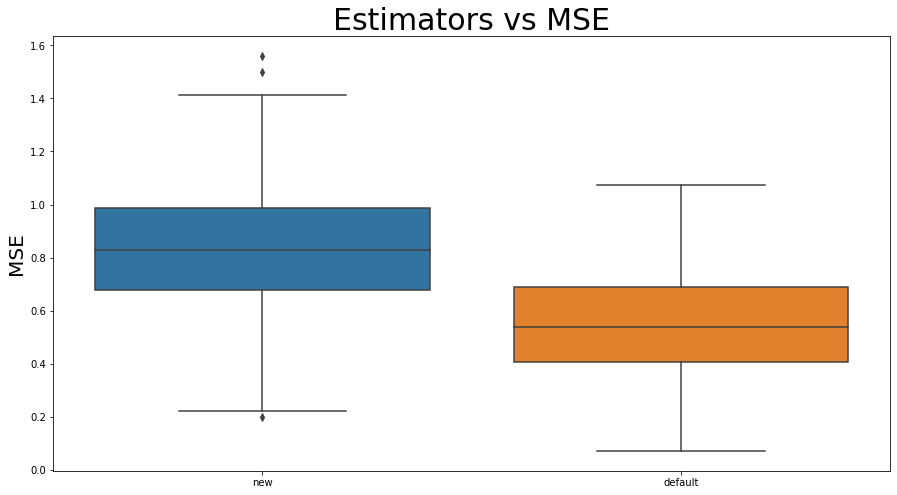

In [ ]:
#Compare default XGB vs optimised XGB
XGB_params = XGB_res.best_params

models_XGB = {}

models_XGB['new'] = xgboost.XGBRegressor(**XGB_params, n_estimators = 500)
models_XGB['default'] = xgboost.XGBRegressor()

results_XGB = train_and_test_regressor(models_XGB, XS_train, YS_train, XS_test, YS_test)
plot_model_comparison(results_XGB)

In [ ]:
#Visualising importance of GB model parameters
optuna.visualization.plot_param_importances(XGB_res)

Fitting 10
Fitting 30
Fitting 50
Fitting 70
Fitting 90
Fitting 110
Fitting 130
Fitting 150
Fitting 170
Fitting 190
Fitting 210
Fitting 230
Fitting 250
Fitting 270
Fitting 290
Fitting 310
Fitting 330
Fitting 350
Fitting 370
Fitting 390
Fitting 410
Fitting 430
Fitting 450
Fitting 470
Fitting 490
Calculating bootstrap score for 10
Calculating bootstrap score for 30
Calculating bootstrap score for 50
Calculating bootstrap score for 70
Calculating bootstrap score for 90
Calculating bootstrap score for 110
Calculating bootstrap score for 130
Calculating bootstrap score for 150
Calculating bootstrap score for 170
Calculating bootstrap score for 190
Calculating bootstrap score for 210
Calculating bootstrap score for 230
Calculating bootstrap score for 250
Calculating bootstrap score for 270
Calculating bootstrap score for 290
Calculating bootstrap score for 310
Calculating bootstrap score for 330
Calculating bootstrap score for 350
Calculating bootstrap score for 370
Calculating bootstrap scor

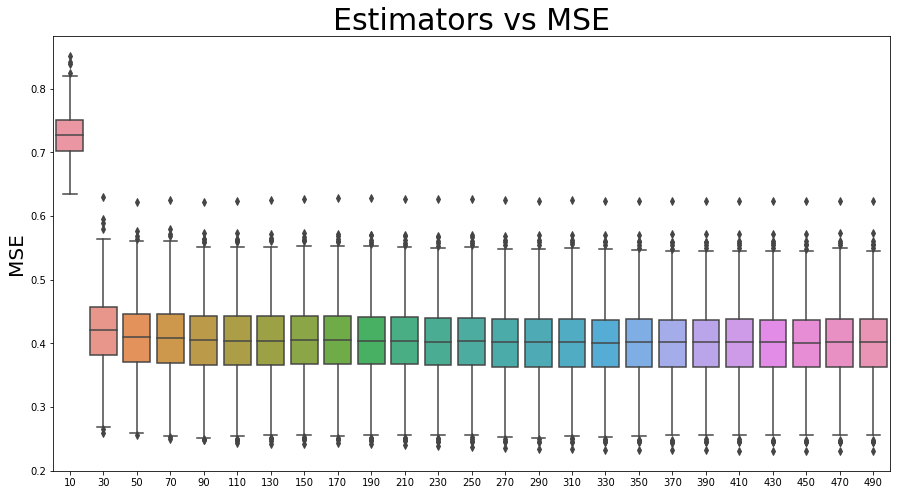

In [ ]:
#Visualising selection of n_estimators
model = {}
for i in range(10, 501, 20):
    model[f'{i}'] = xgboost.XGBRegressor(**XGB_params, n_estimators = i)

path = train_and_test_regressor(model, X_train, Y_train, X_test, Y_test)
plot_model_comparison(path)

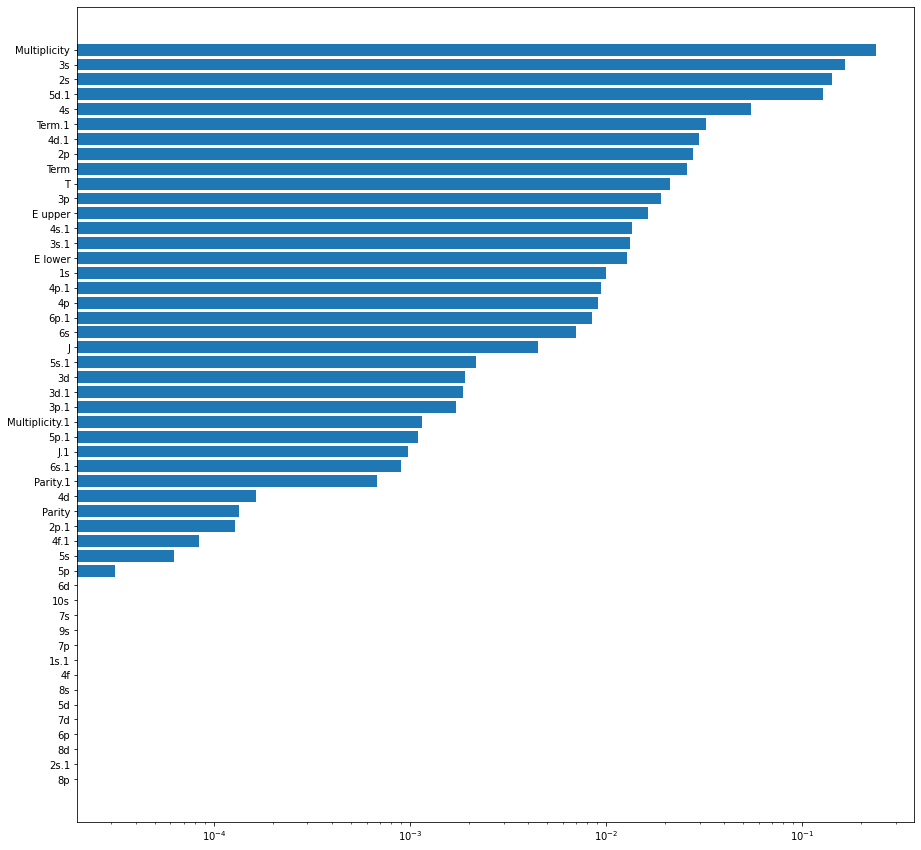

In [ ]:
#Visualising feature importances for the optimal XGB model
feature_importance = models_XGB['new'].feature_importances_
sorted = np.argsort(feature_importance)
pos = np.arange(sorted.shape[0]) + 0.5

plt.figure(figsize = (15, 15))
plt.barh(pos, feature_importance[sorted])
plt.yticks(pos, np.array(X_train.columns)[sorted])
plt.semilogx()
plt.show()

## LightGBM

In [ ]:
LightGBM_params = {
    'n_estimators' : 500,
    'learning_rate' : [0.01, 0.5],
    'num_leaves' : [2, 512],
    'reg_alpha' : [1e-8, 10],
    'reg_lambda' : [1e-8, 10],
    'nfold' : 5,
    'squared_metrics' : False,
    'n_jobs' : -1
    }

model_name = LightGBM

if apply_scaler:
    LightGBM_res = main(X = pd.DataFrame(scaler.transform(X_train)), y = Y_train, model_name = model_name, params = LightGBM_params, n_trials = 500)
else:
    LightGBM_res = main(X = X_train, y = Y_train, model_name = model_name, params = LightGBM_params, n_trials = 500)

with open(f'LightGBM_A+I_optimal_parameters', 'w') as fp:
    json.dump(LightGBM_res.best_params, fp)

[I 2023-05-02 23:32:32,721] A new study created in memory with name: no-name-c52d2092-a4bc-49d0-b9e3-38a40fe154d8


Start hyperparameter optimization


C:\Users\Alex\AppData\Roaming\Python\Python310\site-packages\optuna\progress_bar.py:56: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/500 [00:00<?, ?it/s]

{'n_estimators': 500, 'learning_rate': 0.01630480189529424, 'num_leaves': 107, 'reg_alpha': 3.067895318951963, 'reg_lambda': 2.9898731414098308e-06}
{'n_estimators': 500, 'learning_rate': 0.03629969388608796, 'num_leaves': 43, 'reg_alpha': 0.6808951459769368, 'reg_lambda': 0.0008667701150281691}
{'n_estimators': 500, 'learning_rate': 0.0251848767697648, 'num_leaves': 128, 'reg_alpha': 1.2077944222983961e-05, 'reg_lambda': 0.009899237364308434}
{'n_estimators': 500, 'learning_rate': 0.3168401404184243, 'num_leaves': 446, 'reg_alpha': 0.004631070156653588, 'reg_lambda': 0.004209509336131906}
{'n_estimators': 500, 'learning_rate': 0.032065719463783324, 'num_leaves': 146, 'reg_alpha': 0.004079952926326345, 'reg_lambda': 5.802742957535029e-06}
{'n_estimators': 500, 'learning_rate': 0.04760248795606544, 'num_leaves': 291, 'reg_alpha': 0.17503807671880497, 'reg_lambda': 0.004799884929416406}
{'n_estimators': 500, 'learning_rate': 0.01832911833840109, 'num_leaves': 163, 'reg_alpha': 0.03512255

[I 2023-05-02 23:33:34,405] Trial 16 finished with value: 2.8500892616620948 and parameters: {'learning_rate': 0.04164465174461513, 'num_leaves': 15, 'reg_alpha': 9.044774414950266e-05, 'reg_lambda': 1.700977377109976e-07}. Best is trial 13 with value: 2.3187643868836574.
{'n_estimators': 500, 'learning_rate': 0.22906104230329738, 'num_leaves': 304, 'reg_alpha': 0.0004918573542103778, 'reg_lambda': 7.658984342354172e-07}
[I 2023-05-02 23:33:38,565] Trial 12 finished with value: 2.3415626596075483 and parameters: {'learning_rate': 0.1391958874316499, 'num_leaves': 244, 'reg_alpha': 2.302978079873871e-08, 'reg_lambda': 2.0149794675900914}. Best is trial 13 with value: 2.3187643868836574.
{'n_estimators': 500, 'learning_rate': 0.22711825401659372, 'num_leaves': 350, 'reg_alpha': 7.070827871970785, 'reg_lambda': 6.017913819990941e-07}
[I 2023-05-02 23:33:42,783] Trial 15 finished with value: 3.21387414589199 and parameters: {'learning_rate': 0.023565307480383015, 'num_leaves': 258, 'reg_al

[I 2023-05-02 23:34:32,777] Trial 36 finished with value: 2.124412978630438 and parameters: {'learning_rate': 0.1827734483625059, 'num_leaves': 498, 'reg_alpha': 8.467145687106633, 'reg_lambda': 9.004973209781699e-08}. Best is trial 30 with value: 2.0846015698702707.
{'n_estimators': 500, 'learning_rate': 0.292353693932622, 'num_leaves': 394, 'reg_alpha': 2.8312517322716704, 'reg_lambda': 3.000963355902383e-06}
[I 2023-05-02 23:34:35,039] Trial 38 finished with value: 2.131908124100886 and parameters: {'learning_rate': 0.3073325037873693, 'num_leaves': 395, 'reg_alpha': 9.871581992139143, 'reg_lambda': 1.6459606887011255e-06}. Best is trial 30 with value: 2.0846015698702707.
{'n_estimators': 500, 'learning_rate': 0.33675495190716986, 'num_leaves': 405, 'reg_alpha': 1.821940076540584, 'reg_lambda': 1.8955254227976475e-06}
[I 2023-05-02 23:34:35,670] Trial 27 finished with value: 2.356434231227726 and parameters: {'learning_rate': 0.22906104230329738, 'num_leaves': 304, 'reg_alpha': 0.00

[I 2023-05-02 23:35:14,246] Trial 50 finished with value: 2.3836126765326777 and parameters: {'learning_rate': 0.3650868487980252, 'num_leaves': 427, 'reg_alpha': 0.46177280313289476, 'reg_lambda': 4.2271757502452705e-06}. Best is trial 37 with value: 2.0663863285781643.
{'n_estimators': 500, 'learning_rate': 0.16091272457369157, 'num_leaves': 332, 'reg_alpha': 0.887642305948818, 'reg_lambda': 7.730460246517577e-08}
[I 2023-05-02 23:35:21,396] Trial 54 finished with value: 2.349478961889611 and parameters: {'learning_rate': 0.1615967177442042, 'num_leaves': 439, 'reg_alpha': 0.38629825946370416, 'reg_lambda': 7.890366968763962e-08}. Best is trial 37 with value: 2.0663863285781643.
{'n_estimators': 500, 'learning_rate': 0.1125855163196111, 'num_leaves': 329, 'reg_alpha': 0.833821426687488, 'reg_lambda': 1.8737349473337218e-07}
[I 2023-05-02 23:35:29,178] Trial 55 finished with value: 2.439385443169202 and parameters: {'learning_rate': 0.3853560183790194, 'num_leaves': 440, 'reg_alpha': 

[I 2023-05-02 23:36:07,621] Trial 73 finished with value: 2.1663528893630946 and parameters: {'learning_rate': 0.24440810131394164, 'num_leaves': 372, 'reg_alpha': 4.595702305559643, 'reg_lambda': 2.4060258764974006e-07}. Best is trial 37 with value: 2.0663863285781643.
{'n_estimators': 500, 'learning_rate': 0.25911008646173894, 'num_leaves': 300, 'reg_alpha': 7.153467293844883, 'reg_lambda': 9.307899979285512e-07}
[I 2023-05-02 23:36:08,942] Trial 76 finished with value: 2.1196716743159745 and parameters: {'learning_rate': 0.24024711985166033, 'num_leaves': 366, 'reg_alpha': 4.785436920004975, 'reg_lambda': 3.249855986711307e-07}. Best is trial 37 with value: 2.0663863285781643.
{'n_estimators': 500, 'learning_rate': 0.21706891407857407, 'num_leaves': 304, 'reg_alpha': 9.125177779330853, 'reg_lambda': 9.73752802964428e-07}
[I 2023-05-02 23:36:09,409] Trial 77 finished with value: 2.1534151600621727 and parameters: {'learning_rate': 0.24223356966057116, 'num_leaves': 379, 'reg_alpha': 

[I 2023-05-02 23:36:32,689] Trial 94 finished with value: 2.095465118087694 and parameters: {'learning_rate': 0.2063459723738209, 'num_leaves': 350, 'reg_alpha': 8.156836975473102, 'reg_lambda': 1.1107003177738186e-06}. Best is trial 37 with value: 2.0663863285781643.
{'n_estimators': 500, 'learning_rate': 0.18142509971857265, 'num_leaves': 267, 'reg_alpha': 1.4983861217841357, 'reg_lambda': 5.359646223861e-07}
[I 2023-05-02 23:36:33,104] Trial 95 finished with value: 2.1269088199018054 and parameters: {'learning_rate': 0.19584417251336764, 'num_leaves': 304, 'reg_alpha': 8.023004346535693, 'reg_lambda': 1.2648814858653412e-06}. Best is trial 37 with value: 2.0663863285781643.
{'n_estimators': 500, 'learning_rate': 0.1777289888001765, 'num_leaves': 273, 'reg_alpha': 1.4345258457401215, 'reg_lambda': 5.239285697661348e-07}
[I 2023-05-02 23:36:39,649] Trial 87 finished with value: 2.317152377048921 and parameters: {'learning_rate': 0.262223137433837, 'num_leaves': 306, 'reg_alpha': 1.148

[I 2023-05-02 23:37:12,485] Trial 112 finished with value: 2.2483312229644623 and parameters: {'learning_rate': 0.26599757114561856, 'num_leaves': 286, 'reg_alpha': 2.625427154219797, 'reg_lambda': 8.186535760473652e-06}. Best is trial 37 with value: 2.0663863285781643.
{'n_estimators': 500, 'learning_rate': 0.3224537348425136, 'num_leaves': 235, 'reg_alpha': 6.5250895432234, 'reg_lambda': 1.4302130036073783e-07}
[I 2023-05-02 23:37:13,496] Trial 109 finished with value: 2.284547690915348 and parameters: {'learning_rate': 0.17471798038957825, 'num_leaves': 283, 'reg_alpha': 2.1199149388761858, 'reg_lambda': 9.347162515527225e-06}. Best is trial 37 with value: 2.0663863285781643.
{'n_estimators': 500, 'learning_rate': 0.13680939314333404, 'num_leaves': 384, 'reg_alpha': 6.696086650531777, 'reg_lambda': 1.5545626577158938e-07}
[I 2023-05-02 23:37:14,198] Trial 110 finished with value: 2.2411918077663104 and parameters: {'learning_rate': 0.18010036793909465, 'num_leaves': 278, 'reg_alpha'

[I 2023-05-02 23:37:34,883] Trial 132 finished with value: 2.144905826894198 and parameters: {'learning_rate': 0.32926009089467667, 'num_leaves': 317, 'reg_alpha': 6.022341914719165, 'reg_lambda': 2.641591024104264e-06}. Best is trial 37 with value: 2.0663863285781643.
{'n_estimators': 500, 'learning_rate': 0.22356774159310766, 'num_leaves': 353, 'reg_alpha': 8.867123699972955, 'reg_lambda': 3.5873124568710593e-07}
[I 2023-05-02 23:37:35,453] Trial 129 finished with value: 2.114368985409764 and parameters: {'learning_rate': 0.2180632853734243, 'num_leaves': 387, 'reg_alpha': 6.5983175163644265, 'reg_lambda': 2.8547193109294902e-06}. Best is trial 37 with value: 2.0663863285781643.
[I 2023-05-02 23:37:35,457] Trial 121 finished with value: 2.339716821691971 and parameters: {'learning_rate': 0.13824751203941696, 'num_leaves': 246, 'reg_alpha': 2.780167910501825, 'reg_lambda': 5.080022489683783e-06}. Best is trial 37 with value: 2.0663863285781643.
{'n_estimators': 500, 'learning_rate': 0

[I 2023-05-02 23:37:58,631] Trial 149 finished with value: 2.169657192700531 and parameters: {'learning_rate': 0.23227442623538827, 'num_leaves': 213, 'reg_alpha': 4.360833914755058, 'reg_lambda': 2.2883222651417589e-07}. Best is trial 37 with value: 2.0663863285781643.
{'n_estimators': 500, 'learning_rate': 0.20020587113801452, 'num_leaves': 152, 'reg_alpha': 9.939114768244785, 'reg_lambda': 7.882766324324659e-07}
[I 2023-05-02 23:38:02,762] Trial 151 finished with value: 2.182713446329096 and parameters: {'learning_rate': 0.2299334965405393, 'num_leaves': 149, 'reg_alpha': 3.8957578103583264, 'reg_lambda': 2.0004384645979303e-08}. Best is trial 37 with value: 2.0663863285781643.
{'n_estimators': 500, 'learning_rate': 0.2017866760052595, 'num_leaves': 117, 'reg_alpha': 9.981216115159352, 'reg_lambda': 6.515664904017391e-07}
[I 2023-05-02 23:38:02,838] Trial 152 finished with value: 2.1367146508250654 and parameters: {'learning_rate': 0.24743673312054448, 'num_leaves': 130, 'reg_alpha'

[I 2023-05-02 23:38:16,592] Trial 172 finished with value: 2.1107565707121334 and parameters: {'learning_rate': 0.2992029912451147, 'num_leaves': 175, 'reg_alpha': 9.887175589862649, 'reg_lambda': 1.2557211279704306e-06}. Best is trial 37 with value: 2.0663863285781643.
{'n_estimators': 500, 'learning_rate': 0.2586361288881937, 'num_leaves': 420, 'reg_alpha': 0.0012502132658220623, 'reg_lambda': 5.30634072048174e-07}
[I 2023-05-02 23:38:17,004] Trial 165 finished with value: 2.1133519399089264 and parameters: {'learning_rate': 0.20256291332786336, 'num_leaves': 104, 'reg_alpha': 8.617461287537106, 'reg_lambda': 8.52935436319268e-07}. Best is trial 37 with value: 2.0663863285781643.
{'n_estimators': 500, 'learning_rate': 0.2501556282673162, 'num_leaves': 337, 'reg_alpha': 0.01969695981564678, 'reg_lambda': 5.107024417040422e-07}
[I 2023-05-02 23:38:17,061] Trial 166 finished with value: 2.1187604477564568 and parameters: {'learning_rate': 0.2019891187969735, 'num_leaves': 415, 'reg_alph

[I 2023-05-02 23:39:14,228] Trial 189 finished with value: 2.115430111025602 and parameters: {'learning_rate': 0.2478468669052875, 'num_leaves': 337, 'reg_alpha': 5.539300529079484, 'reg_lambda': 7.751189838670106e-05}. Best is trial 37 with value: 2.0663863285781643.
{'n_estimators': 500, 'learning_rate': 0.17163609382929362, 'num_leaves': 312, 'reg_alpha': 5.564389481694377, 'reg_lambda': 1.2406934163990028e-06}
[I 2023-05-02 23:39:17,299] Trial 190 finished with value: 2.1289972418789698 and parameters: {'learning_rate': 0.24498322414574453, 'num_leaves': 379, 'reg_alpha': 5.568478923650151, 'reg_lambda': 5.7900688162474257e-08}. Best is trial 37 with value: 2.0663863285781643.
{'n_estimators': 500, 'learning_rate': 0.16735601872966102, 'num_leaves': 295, 'reg_alpha': 2.618333065107284, 'reg_lambda': 0.0009914664321358827}
[I 2023-05-02 23:39:18,253] Trial 191 finished with value: 2.1030789709984097 and parameters: {'learning_rate': 0.24513227007784494, 'num_leaves': 295, 'reg_alpha

[I 2023-05-02 23:39:45,668] Trial 205 finished with value: 2.2647867554554404 and parameters: {'learning_rate': 0.21656762158747175, 'num_leaves': 312, 'reg_alpha': 2.433123322711064, 'reg_lambda': 5.933125384846293e-08}. Best is trial 37 with value: 2.0663863285781643.
{'n_estimators': 500, 'learning_rate': 0.23318272804375922, 'num_leaves': 361, 'reg_alpha': 0.9169141636566717, 'reg_lambda': 3.3300450106539534e-07}
[I 2023-05-02 23:39:47,336] Trial 210 finished with value: 2.2504134625965584 and parameters: {'learning_rate': 0.21549782078784546, 'num_leaves': 361, 'reg_alpha': 2.484979892412735, 'reg_lambda': 4.443517994648445e-06}. Best is trial 37 with value: 2.0663863285781643.
{'n_estimators': 500, 'learning_rate': 0.23257453283764262, 'num_leaves': 325, 'reg_alpha': 0.8796455541423801, 'reg_lambda': 2.0505098619584946e-06}
[I 2023-05-02 23:39:47,944] Trial 187 finished with value: 2.3477115962311332 and parameters: {'learning_rate': 0.2520596720960936, 'num_leaves': 296, 'reg_al

[I 2023-05-02 23:40:17,611] Trial 218 finished with value: 2.306193766559686 and parameters: {'learning_rate': 0.18649058936600407, 'num_leaves': 359, 'reg_alpha': 0.9583641037635082, 'reg_lambda': 3.2220479747066757e-07}. Best is trial 37 with value: 2.0663863285781643.
{'n_estimators': 500, 'learning_rate': 0.27360120418606365, 'num_leaves': 234, 'reg_alpha': 9.944519591648026, 'reg_lambda': 1.7375204371959945e-06}
[I 2023-05-02 23:40:18,849] Trial 233 finished with value: 2.074442610024573 and parameters: {'learning_rate': 0.2726910578029705, 'num_leaves': 255, 'reg_alpha': 7.3014144204019225, 'reg_lambda': 7.078712203322287e-07}. Best is trial 37 with value: 2.0663863285781643.
{'n_estimators': 500, 'learning_rate': 0.2829805422736013, 'num_leaves': 325, 'reg_alpha': 0.00010523444627269457, 'reg_lambda': 6.920322507353509e-07}
[I 2023-05-02 23:40:19,471] Trial 221 finished with value: 2.3303712782314046 and parameters: {'learning_rate': 0.23257453283764262, 'num_leaves': 325, 'reg_

[I 2023-05-02 23:40:42,701] Trial 253 finished with value: 2.11674442328323 and parameters: {'learning_rate': 0.31310542826933874, 'num_leaves': 228, 'reg_alpha': 9.913001631266326, 'reg_lambda': 1.0027163654676385e-06}. Best is trial 37 with value: 2.0663863285781643.
{'n_estimators': 500, 'learning_rate': 0.2460357222706158, 'num_leaves': 245, 'reg_alpha': 0.1758453248995534, 'reg_lambda': 2.0062009837729174e-06}
[I 2023-05-02 23:40:43,192] Trial 254 finished with value: 2.075907973722602 and parameters: {'learning_rate': 0.3649792897954365, 'num_leaves': 232, 'reg_alpha': 9.637317515938102, 'reg_lambda': 1.738919820661351e-06}. Best is trial 37 with value: 2.0663863285781643.
{'n_estimators': 500, 'learning_rate': 0.38049743069791914, 'num_leaves': 249, 'reg_alpha': 1.5120118041355268e-05, 'reg_lambda': 1.8716088400732447e-06}
[I 2023-05-02 23:40:43,801] Trial 247 finished with value: 2.1560828508882657 and parameters: {'learning_rate': 0.27434091510538156, 'num_leaves': 233, 'reg_a

[I 2023-05-02 23:41:39,026] Trial 262 finished with value: 2.4063621521891143 and parameters: {'learning_rate': 0.3763973031880728, 'num_leaves': 248, 'reg_alpha': 2.2905039571207244e-07, 'reg_lambda': 1.8162395200035182e-06}. Best is trial 37 with value: 2.0663863285781643.
{'n_estimators': 500, 'learning_rate': 0.103449090311354, 'num_leaves': 343, 'reg_alpha': 6.427383130950568, 'reg_lambda': 4.6490639173065436e-07}
[I 2023-05-02 23:41:42,533] Trial 272 finished with value: 2.1617798842439027 and parameters: {'learning_rate': 0.3639760396618612, 'num_leaves': 264, 'reg_alpha': 6.124884789069731, 'reg_lambda': 2.9233633634439706e-06}. Best is trial 37 with value: 2.0663863285781643.
{'n_estimators': 500, 'learning_rate': 0.4342073919953725, 'num_leaves': 217, 'reg_alpha': 6.4518008330272085, 'reg_lambda': 9.227701901848139e-08}
[I 2023-05-02 23:41:43,047] Trial 273 finished with value: 2.200386121120853 and parameters: {'learning_rate': 0.35906383444990725, 'num_leaves': 217, 'reg_al

[I 2023-05-02 23:42:10,410] Trial 292 finished with value: 2.1197163822379683 and parameters: {'learning_rate': 0.30150241371218955, 'num_leaves': 228, 'reg_alpha': 9.939119160537011, 'reg_lambda': 0.0001328045871330829}. Best is trial 37 with value: 2.0663863285781643.
{'n_estimators': 500, 'learning_rate': 0.43942790932079717, 'num_leaves': 226, 'reg_alpha': 9.996059743732765, 'reg_lambda': 4.5957906869983625e-07}
[I 2023-05-02 23:42:12,145] Trial 289 finished with value: 2.9203584129902476 and parameters: {'learning_rate': 0.03948806233481236, 'num_leaves': 194, 'reg_alpha': 9.801169767584751, 'reg_lambda': 2.3761057978390934e-08}. Best is trial 37 with value: 2.0663863285781643.
{'n_estimators': 500, 'learning_rate': 0.45083957491710114, 'num_leaves': 166, 'reg_alpha': 1.5113409050780326, 'reg_lambda': 0.0030777157771376402}
[I 2023-05-02 23:42:14,027] Trial 294 finished with value: 2.117597840403637 and parameters: {'learning_rate': 0.4821644671583686, 'num_leaves': 166, 'reg_alph

[I 2023-05-02 23:42:59,232] Trial 308 finished with value: 3.076713255078212 and parameters: {'learning_rate': 0.029269393201952904, 'num_leaves': 233, 'reg_alpha': 3.9093846502670804, 'reg_lambda': 0.15765263071966545}. Best is trial 37 with value: 2.0663863285781643.
{'n_estimators': 500, 'learning_rate': 0.2970607752120616, 'num_leaves': 149, 'reg_alpha': 7.059752214064801, 'reg_lambda': 3.375002683634164e-07}
[I 2023-05-02 23:43:01,561] Trial 296 finished with value: 2.94086395656552 and parameters: {'learning_rate': 0.03459410711467516, 'num_leaves': 161, 'reg_alpha': 0.00044357078192179674, 'reg_lambda': 0.008995741582242976}. Best is trial 37 with value: 2.0663863285781643.
{'n_estimators': 500, 'learning_rate': 0.26691843159387485, 'num_leaves': 273, 'reg_alpha': 0.00047840763523964493, 'reg_lambda': 4.272215679977843e-07}
[I 2023-05-02 23:43:03,287] Trial 295 finished with value: 2.4815677688615057 and parameters: {'learning_rate': 0.48433368315188646, 'num_leaves': 168, 'reg_

[I 2023-05-02 23:43:29,546] Trial 325 finished with value: 3.3075022087157784 and parameters: {'learning_rate': 0.021699911005962292, 'num_leaves': 238, 'reg_alpha': 9.871140670442388, 'reg_lambda': 0.0004178537994768056}. Best is trial 37 with value: 2.0663863285781643.
{'n_estimators': 500, 'learning_rate': 0.26303081768022896, 'num_leaves': 36, 'reg_alpha': 0.14250610623983453, 'reg_lambda': 1.4133567508392293}
[I 2023-05-02 23:43:30,677] Trial 328 finished with value: 2.1129115735195656 and parameters: {'learning_rate': 0.2638422620377661, 'num_leaves': 369, 'reg_alpha': 6.036155765176878, 'reg_lambda': 1.091925723776878e-06}. Best is trial 37 with value: 2.0663863285781643.
{'n_estimators': 500, 'learning_rate': 0.26824386333690337, 'num_leaves': 26, 'reg_alpha': 0.6142082939275222, 'reg_lambda': 1.1892903978316637e-06}
[I 2023-05-02 23:43:31,106] Trial 329 finished with value: 2.1341138877435695 and parameters: {'learning_rate': 0.2665178658040607, 'num_leaves': 371, 'reg_alpha':

[I 2023-05-02 23:44:12,814] Trial 330 finished with value: 2.35836039116638 and parameters: {'learning_rate': 0.2670608985929707, 'num_leaves': 366, 'reg_alpha': 0.08962021859300229, 'reg_lambda': 1.0318960286204834e-06}. Best is trial 37 with value: 2.0663863285781643.
{'n_estimators': 500, 'learning_rate': 0.40376331434415486, 'num_leaves': 261, 'reg_alpha': 6.083898300473574, 'reg_lambda': 4.475666070560082e-08}
[I 2023-05-02 23:44:15,158] Trial 344 finished with value: 2.31980097209766 and parameters: {'learning_rate': 0.20751256536574267, 'num_leaves': 196, 'reg_alpha': 1.954427938924107, 'reg_lambda': 1.570774987808236e-08}. Best is trial 37 with value: 2.0663863285781643.
{'n_estimators': 500, 'learning_rate': 0.1314369689778428, 'num_leaves': 267, 'reg_alpha': 6.012851257095581, 'reg_lambda': 1.5272393102111126e-07}
[I 2023-05-02 23:44:15,738] Trial 350 finished with value: 2.0913021173769324 and parameters: {'learning_rate': 0.24004826858519857, 'num_leaves': 198, 'reg_alpha':

[I 2023-05-02 23:44:59,663] Trial 367 finished with value: 2.151191746043557 and parameters: {'learning_rate': 0.23053698392980734, 'num_leaves': 490, 'reg_alpha': 4.849789763558534, 'reg_lambda': 3.270531910225401e-05}. Best is trial 37 with value: 2.0663863285781643.
{'n_estimators': 500, 'learning_rate': 0.3421726901107796, 'num_leaves': 185, 'reg_alpha': 1.9974216220551544e-08, 'reg_lambda': 0.00014159799673983233}
[I 2023-05-02 23:45:00,371] Trial 359 finished with value: 2.3413171665697488 and parameters: {'learning_rate': 0.24230505472694788, 'num_leaves': 455, 'reg_alpha': 0.2566635264660818, 'reg_lambda': 1.8581629371243293e-07}. Best is trial 37 with value: 2.0663863285781643.
{'n_estimators': 500, 'learning_rate': 0.20393875569204656, 'num_leaves': 472, 'reg_alpha': 4.980508627143629, 'reg_lambda': 0.00024524355753912063}
[I 2023-05-02 23:45:00,818] Trial 360 finished with value: 2.411600204025673 and parameters: {'learning_rate': 0.34639418855815435, 'num_leaves': 199, 'reg

[I 2023-05-02 23:45:43,641] Trial 378 finished with value: 2.3386804162657215 and parameters: {'learning_rate': 0.20345334792933578, 'num_leaves': 222, 'reg_alpha': 0.8859904183880464, 'reg_lambda': 0.04192903617634211}. Best is trial 37 with value: 2.0663863285781643.
{'n_estimators': 500, 'learning_rate': 0.18788077236749437, 'num_leaves': 248, 'reg_alpha': 3.5849007852067877e-07, 'reg_lambda': 0.002821622939218513}
[I 2023-05-02 23:45:48,860] Trial 387 finished with value: 2.0839478753796774 and parameters: {'learning_rate': 0.1863752625972121, 'num_leaves': 240, 'reg_alpha': 7.114801572078922, 'reg_lambda': 0.0007623446889595269}. Best is trial 37 with value: 2.0663863285781643.
{'n_estimators': 500, 'learning_rate': 0.19363627216800106, 'num_leaves': 245, 'reg_alpha': 1.3934292310890333e-07, 'reg_lambda': 0.003592500356805726}
[I 2023-05-02 23:45:52,476] Trial 372 finished with value: 2.403977414602552 and parameters: {'learning_rate': 0.3427165695815681, 'num_leaves': 496, 'reg_a

[I 2023-05-02 23:46:33,994] Trial 408 finished with value: 2.201248163699307 and parameters: {'learning_rate': 0.1744932440969748, 'num_leaves': 232, 'reg_alpha': 4.910662799879361, 'reg_lambda': 0.003167306749714964}. Best is trial 37 with value: 2.0663863285781643.
[I 2023-05-02 23:46:34,006] Trial 389 finished with value: 2.3459736170794585 and parameters: {'learning_rate': 0.19101877901852138, 'num_leaves': 220, 'reg_alpha': 7.024529603340566e-08, 'reg_lambda': 0.009641754976270426}. Best is trial 37 with value: 2.0663863285781643.
{'n_estimators': 500, 'learning_rate': 0.4204235289977801, 'num_leaves': 209, 'reg_alpha': 0.015484840703559957, 'reg_lambda': 1.246914809216314e-07}
{'n_estimators': 500, 'learning_rate': 0.28470679259214615, 'num_leaves': 211, 'reg_alpha': 1.126496148252715, 'reg_lambda': 0.00553924987942423}
[I 2023-05-02 23:46:35,898] Trial 393 finished with value: 2.3545497087176743 and parameters: {'learning_rate': 0.19363627216800106, 'num_leaves': 245, 'reg_alpha

[I 2023-05-02 23:47:29,816] Trial 414 finished with value: 2.4765651406358917 and parameters: {'learning_rate': 0.4235296402750838, 'num_leaves': 211, 'reg_alpha': 0.0008836189825775095, 'reg_lambda': 2.4963483544226927e-06}. Best is trial 37 with value: 2.0663863285781643.
{'n_estimators': 500, 'learning_rate': 0.03221922693466978, 'num_leaves': 366, 'reg_alpha': 4.614879091997666, 'reg_lambda': 1.808556997705907e-07}
[I 2023-05-02 23:47:32,323] Trial 415 finished with value: 2.3425645406010918 and parameters: {'learning_rate': 0.28586126405477985, 'num_leaves': 212, 'reg_alpha': 1.2355432130797106e-05, 'reg_lambda': 2.2319833897648455e-06}. Best is trial 37 with value: 2.0663863285781643.
{'n_estimators': 500, 'learning_rate': 0.022956321591445752, 'num_leaves': 379, 'reg_alpha': 4.707929635016569, 'reg_lambda': 2.3126858079805744e-07}
[I 2023-05-02 23:47:35,200] Trial 416 finished with value: 2.8336934193634393 and parameters: {'learning_rate': 0.0429081912961355, 'num_leaves': 211,

[I 2023-05-02 23:48:16,644] Trial 442 finished with value: 2.0953289603961434 and parameters: {'learning_rate': 0.2131544283053796, 'num_leaves': 156, 'reg_alpha': 7.1367717399142325, 'reg_lambda': 4.383671470783241e-06}. Best is trial 37 with value: 2.0663863285781643.
{'n_estimators': 500, 'learning_rate': 0.21039500507762576, 'num_leaves': 139, 'reg_alpha': 0.46241322006350827, 'reg_lambda': 1.4674385566585692e-06}
[I 2023-05-02 23:48:19,828] Trial 429 finished with value: 2.35856533706917 and parameters: {'learning_rate': 0.2486984720844959, 'num_leaves': 367, 'reg_alpha': 1.3646506363956151e-06, 'reg_lambda': 2.404872592301376e-07}. Best is trial 37 with value: 2.0663863285781643.
{'n_estimators': 500, 'learning_rate': 0.20927962487767746, 'num_leaves': 153, 'reg_alpha': 0.006000208732468674, 'reg_lambda': 0.11348287963473162}
[I 2023-05-02 23:48:35,733] Trial 448 finished with value: 2.2315136506082185 and parameters: {'learning_rate': 0.2181487933625731, 'num_leaves': 225, 'reg_

[I 2023-05-02 23:49:26,842] Trial 464 finished with value: 2.165985709452446 and parameters: {'learning_rate': 0.2896223393397938, 'num_leaves': 173, 'reg_alpha': 4.286435628172554, 'reg_lambda': 6.556737911056825e-07}. Best is trial 37 with value: 2.0663863285781643.
{'n_estimators': 500, 'learning_rate': 0.28384990769223467, 'num_leaves': 251, 'reg_alpha': 9.836924873328428, 'reg_lambda': 6.18740570464085e-07}
[I 2023-05-02 23:49:26,975] Trial 452 finished with value: 2.4158837817559564 and parameters: {'learning_rate': 0.10837728751380159, 'num_leaves': 164, 'reg_alpha': 0.14740090902805333, 'reg_lambda': 4.87549668290599e-06}. Best is trial 37 with value: 2.0663863285781643.
{'n_estimators': 500, 'learning_rate': 0.2634626879121575, 'num_leaves': 253, 'reg_alpha': 9.87823881889635, 'reg_lambda': 7.131448705550208e-07}
[I 2023-05-02 23:49:27,456] Trial 460 finished with value: 2.317683958864096 and parameters: {'learning_rate': 0.29906188278337714, 'num_leaves': 163, 'reg_alpha': 0.

[I 2023-05-02 23:50:00,708] Trial 481 finished with value: 2.150809306540755 and parameters: {'learning_rate': 0.2809821395622603, 'num_leaves': 280, 'reg_alpha': 9.805341960253628, 'reg_lambda': 5.974491734102422e-07}. Best is trial 37 with value: 2.0663863285781643.
{'n_estimators': 500, 'learning_rate': 0.3016241843651291, 'num_leaves': 286, 'reg_alpha': 6.399803547104731, 'reg_lambda': 0.0005086233490376708}
[I 2023-05-02 23:50:01,273] Trial 482 finished with value: 2.100721068244769 and parameters: {'learning_rate': 0.28888965948354706, 'num_leaves': 276, 'reg_alpha': 9.566968747597235, 'reg_lambda': 5.538989849011508e-07}. Best is trial 37 with value: 2.0663863285781643.
{'n_estimators': 500, 'learning_rate': 0.29186069765405587, 'num_leaves': 269, 'reg_alpha': 5.887476467036754, 'reg_lambda': 7.729485209545523e-07}
[I 2023-05-02 23:50:01,363] Trial 476 finished with value: 3.4853300894802723 and parameters: {'learning_rate': 0.015458995859896558, 'num_leaves': 250, 'reg_alpha': 

[I 2023-05-02 23:50:44,004] Trial 495 finished with value: 2.381458174084309 and parameters: {'learning_rate': 0.26197428495949093, 'num_leaves': 264, 'reg_alpha': 0.00024670538408313753, 'reg_lambda': 1.2901992449333839e-06}. Best is trial 37 with value: 2.0663863285781643.
[I 2023-05-02 23:50:45,832] Trial 498 finished with value: 2.3341898335696083 and parameters: {'learning_rate': 0.26260564897677563, 'num_leaves': 256, 'reg_alpha': 0.001009871158510501, 'reg_lambda': 8.91519106624268e-05}. Best is trial 37 with value: 2.0663863285781643.
Best parameters: {'learning_rate': 0.18671748205471794, 'num_leaves': 366, 'reg_alpha': 7.493453497151838, 'reg_lambda': 2.4487307315958357e-06}


Fitting new
Fitting default
Calculating bootstrap score for new
Calculating bootstrap score for default


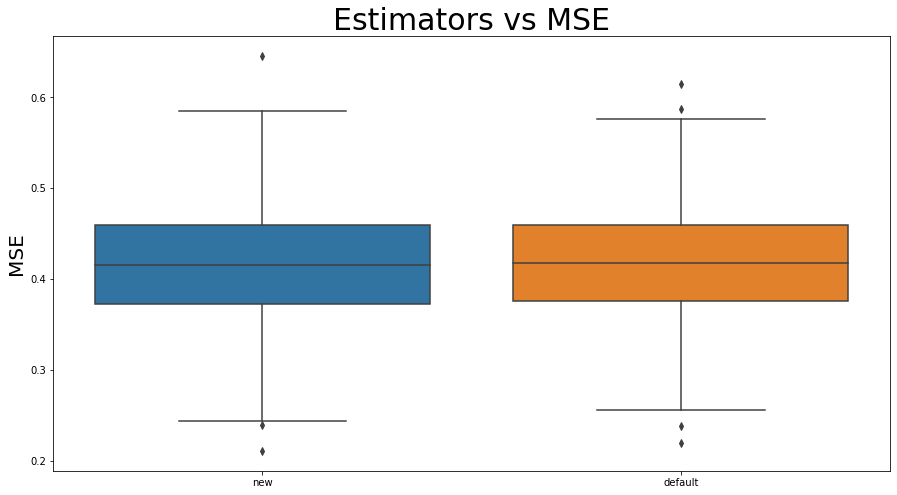

In [ ]:
#Compare default LightGBM vs optimised LightGBM
LightGBM_params = LightGBM_res.best_params

models_LightGBM = {}

models_LightGBM['new'] = lightgbm.LGBMRegressor(**LightGBM_params, n_estimators = 500)
models_LightGBM['default'] = lightgbm.LGBMRegressor()

results_LightGBM = train_and_test_regressor(models_LightGBM, X_train, Y_train, X_test, Y_test)
plot_model_comparison(results_LightGBM)

In [ ]:
#Visualising importance of GB model parameters
optuna.visualization.plot_param_importances(LightGBM_res)

Fitting 10
Fitting 30
Fitting 50
Fitting 70
Fitting 90
Fitting 110
Fitting 130
Fitting 150
Fitting 170
Fitting 190
Fitting 210
Fitting 230
Fitting 250
Fitting 270
Fitting 290
Fitting 310
Fitting 330
Fitting 350
Fitting 370
Fitting 390
Fitting 410
Fitting 430
Fitting 450
Fitting 470
Fitting 490
Calculating bootstrap score for 10
Calculating bootstrap score for 30
Calculating bootstrap score for 50
Calculating bootstrap score for 70
Calculating bootstrap score for 90
Calculating bootstrap score for 110
Calculating bootstrap score for 130
Calculating bootstrap score for 150
Calculating bootstrap score for 170
Calculating bootstrap score for 190
Calculating bootstrap score for 210
Calculating bootstrap score for 230
Calculating bootstrap score for 250
Calculating bootstrap score for 270
Calculating bootstrap score for 290
Calculating bootstrap score for 310
Calculating bootstrap score for 330
Calculating bootstrap score for 350
Calculating bootstrap score for 370
Calculating bootstrap scor

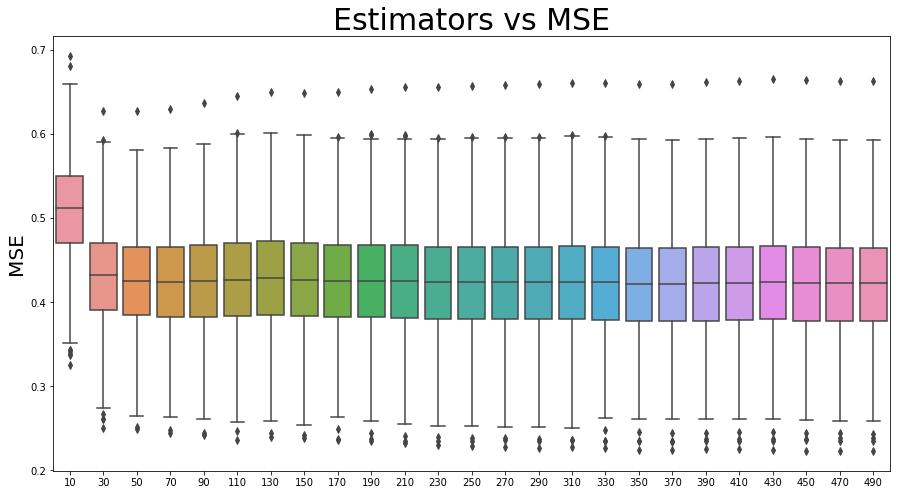

In [ ]:
#Visualising selection of n_estimators
model = {}
for i in range(10, 501, 20):
    model[f'{i}'] = lightgbm.LGBMRegressor(**XGB_params, n_estimators = i)

path = train_and_test_regressor(model, X_train, Y_train, X_test, Y_test)
plot_model_comparison(path)

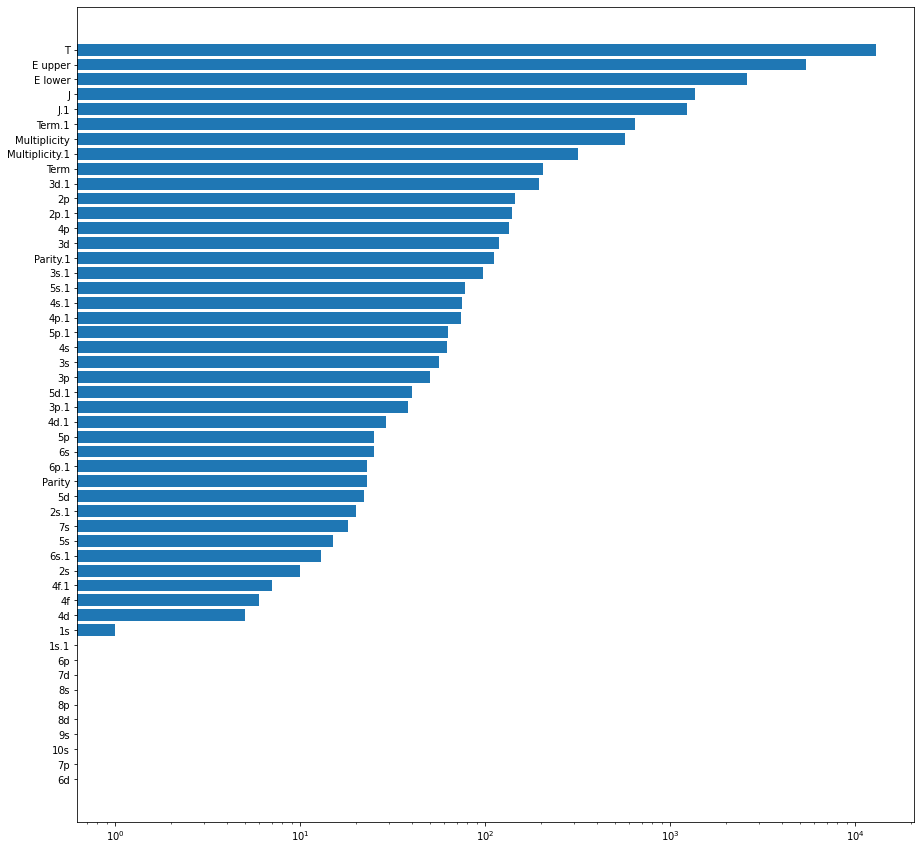

In [ ]:
feature_importance = models_LightGBM['new'].feature_importances_
sorted = np.argsort(feature_importance)
pos = np.arange(sorted.shape[0]) + 0.5

plt.figure(figsize = (15, 15))
plt.barh(pos, feature_importance[sorted])
plt.yticks(pos, np.array(XW_train.columns)[sorted])
plt.semilogx()
plt.show()

## TabNet

In [ ]:
torch.cuda.is_available()

True

In [ ]:
TabNet_params = {
    'n_d' : [1, 64],
    'n_steps' : [1, 25],
    'gamma' : [1., 2.],
    'n_independent' : [1, 20],
    'n_shared' : [1, 20],
    'momentum' : [1e-3, 0.4],
    'mask_type' : ['sparsemax', 'entmax'],
    'nfold' : 5,
    'squared_metrics' : False,
    'device_name' : 'cuda',
    'n_jobs' : 1
    }

model_name = TabNet

TabNet_res = main(X = X_train, y = Y_train, model_name = model_name, params = TabNet_params, n_trials = 1000)

with open(f'TabNet_A+I_optimal_parameters', 'w') as fp:
    json.dump(TabNet_res.best_params, fp)

[I 2023-04-29 14:42:25,476] A new study created in memory with name: no-name-6d1f81d7-da99-4458-8900-9a2cb4dbd772
C:\Users\Alex\AppData\Roaming\Python\Python310\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


Start hyperparameter optimization


  0%|          | 0/1000 [00:00<?, ?it/s]

{'device_name': 'cuda', 'n_d': 10, 'n_steps': 8, 'gamma': 1.062036414714562, 'n_independent': 10, 'n_shared': 17, 'momentum': 0.2582866324854284, 'mask_type': 'entmax'}

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 74.54875


C:\Users\Alex\AppData\Roaming\Python\Python310\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 69.61563


C:\Users\Alex\AppData\Roaming\Python\Python310\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 29.53709


C:\Users\Alex\AppData\Roaming\Python\Python310\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 30.19352


C:\Users\Alex\AppData\Roaming\Python\Python310\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 22.23656


C:\Users\Alex\AppData\Roaming\Python\Python310\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Best trial: 0. Best value: 6.5246:   0%|          | 1/1000 [06:21<105:57:44, 381.85s/it]

[I 2023-04-29 14:48:47,322] Trial 0 finished with value: 6.524598399825075 and parameters: {'n_d': 10, 'n_steps': 8, 'gamma': 1.062036414714562, 'n_independent': 10, 'n_shared': 17, 'momentum': 0.2582866324854284, 'mask_type': 'entmax'}. Best is trial 0 with value: 6.524598399825075.
{'device_name': 'cuda', 'n_d': 18, 'n_steps': 17, 'gamma': 1.0933732568292283, 'n_independent': 2, 'n_shared': 12, 'momentum': 0.0078233485195872, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 88 with best_epoch = 68 and best_eval_mse = 50.37204


C:\Users\Alex\AppData\Roaming\Python\Python310\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
%debug

> c:\users\alex\.conda\envs\cudaenv\lib\site-packages\torch\random.py(42)manual_seed()
     40         torch.cuda.manual_seed_all(seed)
     41 
---> 42     return default_generator.manual_seed(seed)
     43 
     44 

ipdb> torch.cuda._is_in_bad_fork()
False


Fitting TabNet_new

Early stopping occurred at epoch 173 with best_epoch = 153 and best_eval_mse = 0.28204
Fitting TabNet_default


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 184 with best_epoch = 164 and best_eval_mse = 0.21485
Calculating bootstrap score for TabNet_new


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Calculating bootstrap score for TabNet_default


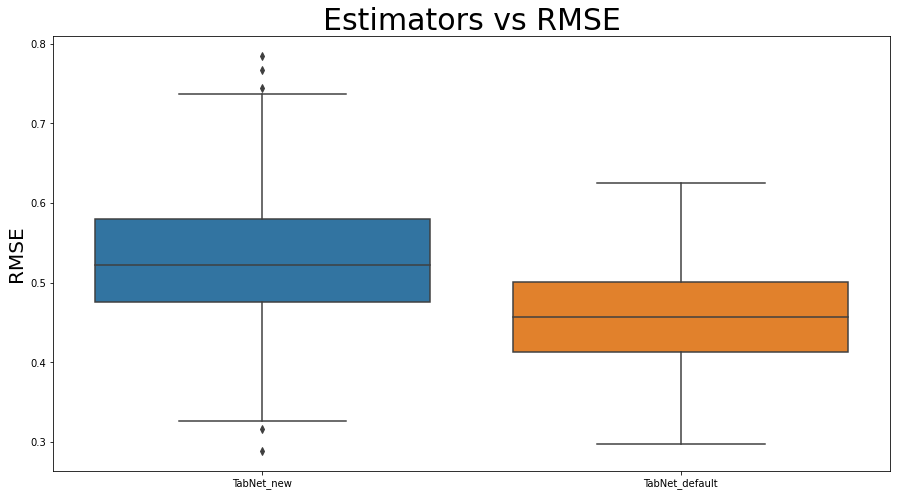

In [ ]:
TabNet_params = TabNet_res.best_params
TabNet_params['device_name'] = 'cuda'

models_TabNet = {}

models_TabNet['TabNet_new'] = TabNet(TabNet_params)
models_TabNet['TabNet_default'] = TabNet({'device_name' : 'cuda',
                                   'n_d' : 8})

results_TabNet = train_and_test_regressor(models_TabNet, X_train, Y_train, X_test, Y_test, max_epochs = 100)
plot_model_comparison(results_TabNet)

In [ ]:
optuna.visualization.plot_param_importances(TabNet_res)

In [ ]:
optuna.visualization.plot_contour(TabNet_res)

# Comparison

## Width

In [ ]:
data_width_elements[data_width_elements['Charge'] == 0]

Element  Wavelength  Z number  Charge  1s  2s  2p  3s  3p  3d  ...  8d  \
2        Mg   518.36043        12       0   2   2   6   1   1   0  ...   0   
3        Mg   517.26844        12       0   2   2   6   1   1   0  ...   0   
4        Mg   516.73213        12       0   2   2   6   1   1   0  ...   0   
5        Mn   403.07530        25       0   2   2   6   2   6   5  ...   0   
6        Mn   403.30620        25       0   2   2   6   2   6   5  ...   0   
7        Mn   403.44830        25       0   2   2   6   2   6   5  ...   0   
8        Mn   279.48170        25       0   2   2   6   2   6   5  ...   0   
9        Mn   279.82690        25       0   2   2   6   2   6   5  ...   0   
10       Mn   280.10810        25       0   2   2   6   2   6   5  ...   0   
11       Mn   404.13550        25       0   2   2   6   2   6   6  ...   0   
12       Mn   404.87430        25       0   2   2   6   2   6   6  ...   0   
13       Mn   405.55440        25       0   2   2   6   2   6   6  ...   0   
14       Mn   357.78680        25       0   2   2   6   2   6   6  ...   0   
15       Mn   478.34270        25       0   2   2   6   2   6   5  ...   0   
16       Mn   482.35240        25       0   2   2   6   2   6   5  ...   0   
587       S   469.41130        16       0   2   2   6   2   3   0  ...   0   
588       S   469.41130        16       0   2   2   6   2   3   0  ...   0   
589       S   469.54430        16       0   2   2   6   2   3   0  ...   0   
590       S   469.54430        16       0   2   2   6   2   3   0  ...   0   
591       S   469.62520        16       0   2   2   6   2   3   0  ...   0   
592       S   469.62520        16       0   2   2   6   2   3   0  ...   0   
593       S   527.81280        16       0   2   2   6   2   3   0  ...   0   
594       S   527.81280        16       0   2   2   6   2   3   0  ...   0   
595       S   527.87000        16       0   2   2   6   2   3   0  ...   0   
596       S   527.87000        16       0   2   2   6   2   3   0  ...   0   
597       S   527.89930        16       0   2   2   6   2   3   0  ...   0   
598       S   527.89930        16       0   2   2   6   2   3   0  ...   0   
730      Mg   552.84100        12       0   2   2   6   1   1   0  ...   0   
731      Mg   470.29900        12       0   2   2   6   1   1   0  ...   0   
732      Mg   470.29900        12       0   2   2   6   1   1   0  ...   0   
733      Mg   291.54500        12       0   2   2   6   1   0   1  ...   0   
734      Mg   291.54500        12       0   2   2   6   1   0   1  ...   0   
735      Mg   285.21300        12       0   2   2   6   2   0   0  ...   0   
736      Mg   285.21300        12       0   2   2   6   2   0   0  ...   0   

     9s  10s  11s  Multiplicity.1  Term.1  Parity.1  J.1    E upper      T  
2     0    0    0               3       0         1  1.0  41197.403  49500  
3     0    0    0               3       0         1  1.0  41197.403  49500  
4     0    0    0               3       0         1  1.0  41197.403  49500  
5     0    0    0               6       1         0  3.5  24802.250  47000  
6     0    0    0               6       1         0  2.5  24788.050  47000  
7     0    0    0               6       1         0  1.5  24779.320  47000  
8     0    0    0               6       1         0  3.5  35769.970  47000  
9     0    0    0               6       1         0  2.5  35725.850  47000  
10    0    0    0               6       1         0  1.5  35689.980  47000  
11    0    0    0               6       2         0  4.5  41789.480  47000  
12    0    0    0               6       2         0  1.5  42143.570  47000  
13    0    0    0               6       2         0  3.5  41932.640  47000  
14    0    0    0               6       1         0  3.5  44993.920  47000  
15    0    0    0               8       0         1  3.5  39431.310  47000  
16    0    0    0               8       0         1  3.5  39431.310  47000  
587   0    0    0               5       1

Getting KNN_A+I predictions
Getting RF_A+I predictions
Plotting KNN_A+I predictions
Plotting RF_A+I predictions


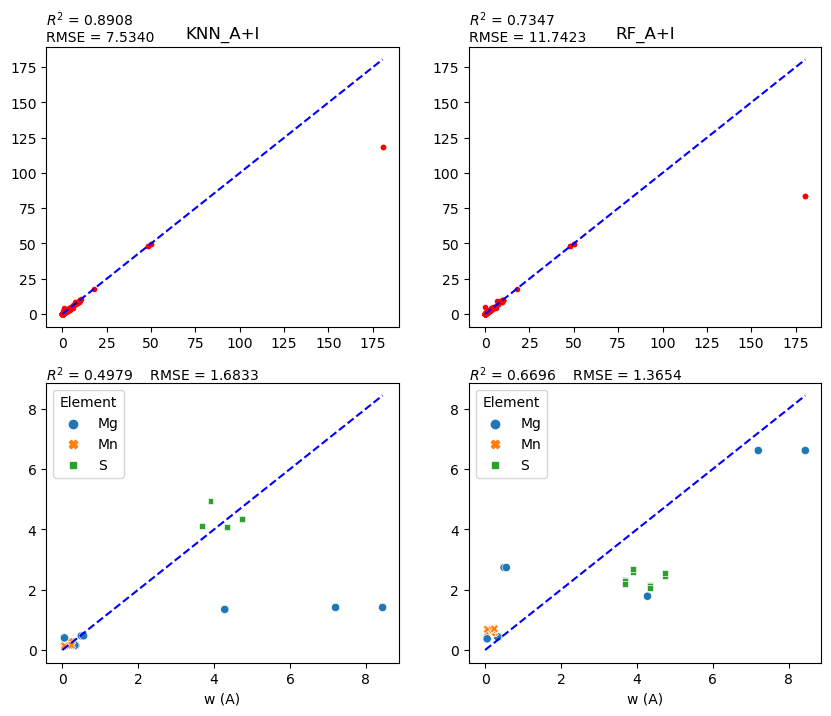

In [ ]:
models = ['KNN_A+I', 'RF_A+I']

models_d = create_models_dict(models)

preds, preds_elem, fix, ax = plot_model_prediction(models_d,
                                                    data_width_train.drop(columns=['Element', 'Wavelength', 'Z number']).sample(frac = 1, random_state = 777), target_width_train.sample(frac = 1, random_state = 777),
                                                    data_width_test[data_width_test['Charge'] == 0].drop(columns=['Element', 'Wavelength', 'Z number']), target_width_test.loc[data_width_test[data_width_test['Charge'] == 0].index],
                                                    data_width_elements[data_width_elements['Charge'] == 0].drop(columns=['Element', 'Wavelength', 'Z number']),
                                                   target_width_elements.loc[data_width_elements[data_width_elements['Charge'] == 0].index],
                                                   label_width_elements.loc[data_width_elements[data_width_elements['Charge'] == 0].index])

Calculating bootstrap score for KNN
Calculating bootstrap score for RF
Calculating bootstrap score for GB
Calculating bootstrap score for XGB
Calculating bootstrap score for LightGBM
Calculating bootstrap score for TabNet


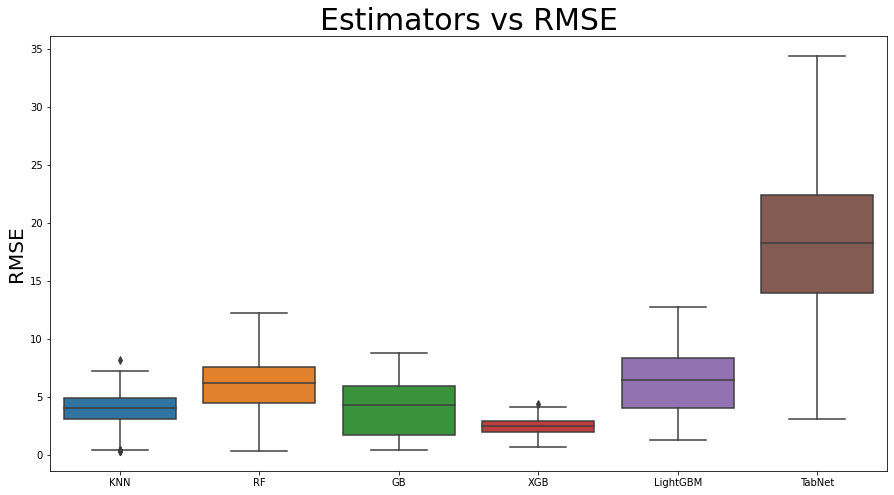

In [ ]:
results_original = train_and_test_regressor(models_d,
                                            data_width_train.drop(columns=['Element', 'Wavelength', 'Z number']).sample(frac = 1, random_state = 777), target_width_train.sample(frac = 1, random_state = 777),
                                            data_width_test.drop(columns=['Element', 'Wavelength', 'Z number']), target_width_test,
                                            train = False)
plot_model_comparison(results_original)

## Width. Scaled *targets*

Getting KNN_Scaled predictions
Getting RF_Scaled predictions
Getting GB_Scaled predictions
Getting XGB_Scaled predictions
Getting LightGBM_Scaled predictions
Getting TabNet_Scaled predictions

Early stopping occurred at epoch 177 with best_epoch = 157 and best_eval_mse = 0.31737
Plotting KNN_Scaled predictions
Plotting RF_Scaled predictions
Plotting GB_Scaled predictions
Plotting XGB_Scaled predictions
Plotting LightGBM_Scaled predictions
Plotting TabNet_Scaled predictions


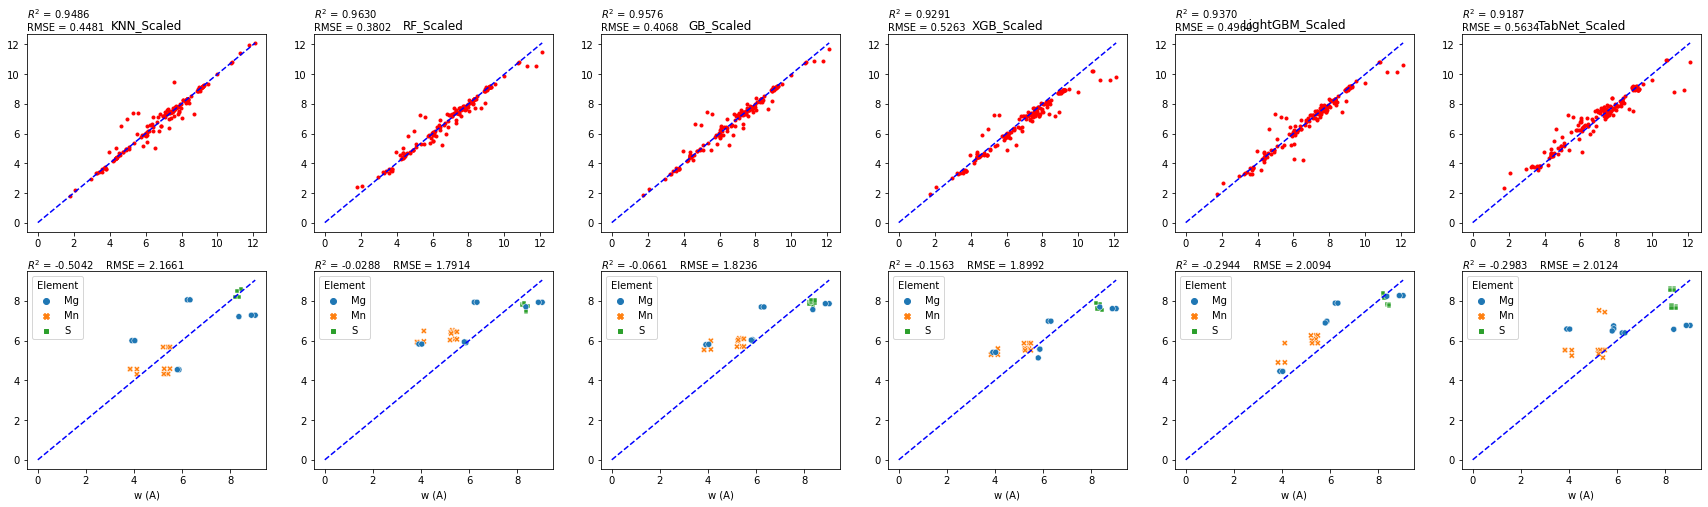

In [ ]:
models = ['KNN_Scaled', 'RF_Scaled', 'GB_Scaled', 'XGB_Scaled', 'LightGBM_Scaled', 'TabNet_Scaled']

models_d = create_models_dict(models)

preds, preds_elem, fix, ax = plot_model_prediction(models_d,
                                                    data_width_train.drop(columns=['Element', 'Wavelength', 'Z number']).sample(frac = 1, random_state = 777), np.log(1 + target_width_train.sample(frac = 1, random_state = 777) / epsilon),
                                                    data_width_test.drop(columns=['Element', 'Wavelength', 'Z number']), np.log(1 + target_width_test / epsilon),
                                                    data_width_elements.drop(columns=['Element', 'Wavelength', 'Z number']), np.log(1 + target_width_elements.sample(frac = 1, random_state = 777) / epsilon), label_width_elements)

In [ ]:
for name, values in preds.items():
    preds[name] = (np.exp(preds[name]) - 1) * epsilon
    preds_elem[name] = (np.exp(preds_elem[name]) -1) * epsilon

Plotting KNN_Scaled predictions
Plotting RF_Scaled predictions
Plotting GB_Scaled predictions
Plotting XGB_Scaled predictions
Plotting LightGBM_Scaled predictions
Plotting TabNet_Scaled predictions


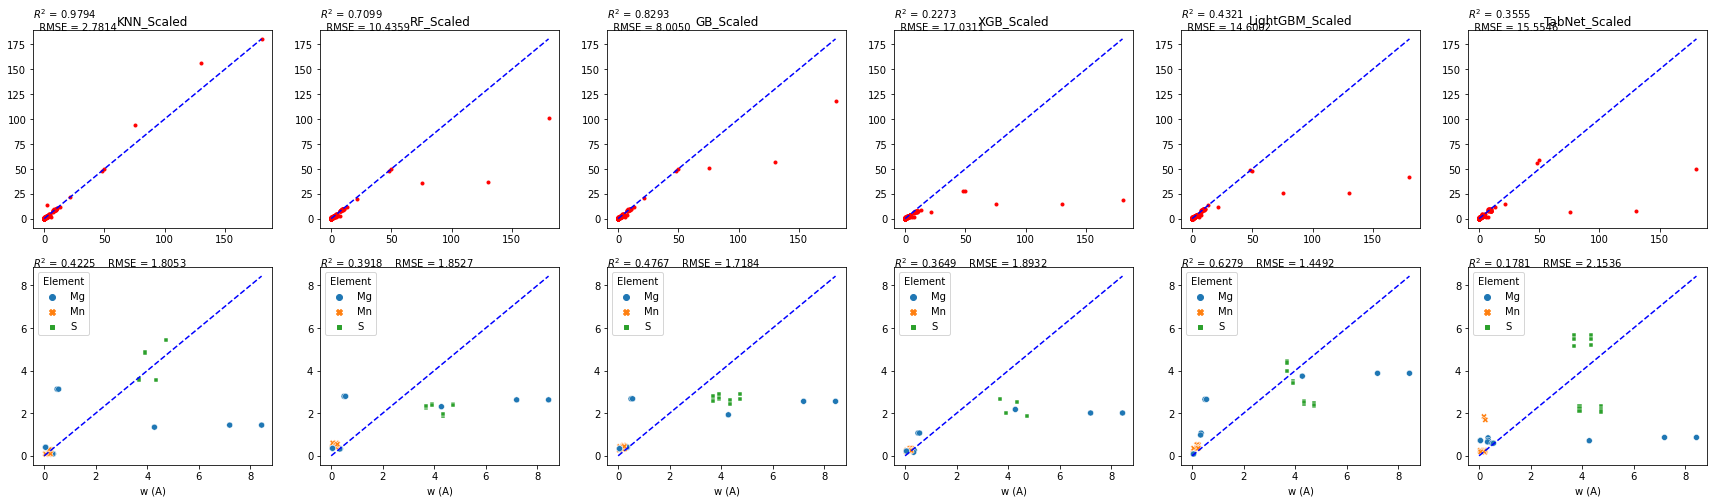

In [ ]:
predictions_elem = {}
R2 = {}
R2_elem = {}
RMSE = {}
RMSE_elem = {}
for name, model in models_d.items():
    y_pred = preds[name]
    R2[name] = r2_score(target_width_test, y_pred)
    RMSE[name] = mean_squared_error(target_width_test, y_pred, squared = False)

    y_pred = preds_elem[name]
    R2_elem[name] = r2_score(target_width_elements, y_pred)
    RMSE_elem[name] = mean_squared_error(target_width_elements, y_pred, squared = False)

    
i = 0
fig, ax = plt.subplots(2, len(models_d), figsize = (5*len(models_d), 4*2))
for name, model in models_d.items():
    print(f'Plotting {name} predictions')
    ax[0, i].plot(target_width_test, preds[name], 'r.')
    ax[0, i].plot([0, np.amax(target_width_test)], [0, np.amax(target_width_test)], color = 'b', ls = '--')
    ax[0, i].set_title(f'{name}')
    #ax[0, i].text(x = 0, y = 1, s = f'$R^2$ = {R2[name]:.4f}', transform = ax[0, i].transAxes)
    ax[0, i].text(x = 0, y = 1, s = f'$R^2$ = {R2[name]:.4f}  \n  RMSE = {RMSE[name]:.4f}',  transform = ax[0, i].transAxes)
    
    #ax[1, i].plot(y_elem, predictions_elem[name], 'r.')
    sns.scatterplot(x = target_width_elements, y = preds_elem[name], ax = ax[1, i], style = label_width_elements['Element'], hue = label_width_elements['Element'])
    ax[1, i].plot([0, np.amax(target_width_elements)], [0, np.amax(target_width_elements)], color = 'b', ls = '--')
    ax[1, i].text(x = 0, y = 1, s = f'$R^2$ = {R2_elem[name]:.4f}    RMSE = {RMSE_elem[name]:.4f}',  transform = ax[1, i].transAxes)
    i += 1
plt.show()

In [ ]:
def train_and_test_regressor_local(models, X_train, y_train, X_test, y_test, max_epochs = 200, patience = 20, train = True):
  predictions = {}
  for name, model in models.items():
    if train == True:
        print(f"Fitting {name}")
        if 'TabNet' in name:
            model.fit(X_train, y_train, X_test, y_test)
        else:
            model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions[name] = y_pred
      
  boot_scores = {}

  for name, y_pred in predictions.items():
      print(f"Calculating bootstrap score for {name}")
      boot_score = bootstrap_metric((np.exp(y_test - 1)) * epsilon, 
                                      (np.exp(y_pred - 1)) * epsilon, 
                                      metric_fn=lambda x, y: mean_squared_error(y_true=x,
                                                                                y_pred=y,
                                                                                squared = False))
      boot_scores[name] = boot_score
      
  
  results = pd.DataFrame(boot_scores)
  # cast to long format
  results = results.melt(value_vars=results.columns,
                      value_name="mse", 
                      var_name="model") 
  return results

Calculating bootstrap score for KNN_Scaled
Calculating bootstrap score for RF_Scaled
Calculating bootstrap score for GB_Scaled
Calculating bootstrap score for XGB_Scaled
Calculating bootstrap score for LightGBM_Scaled
Calculating bootstrap score for TabNet_Scaled


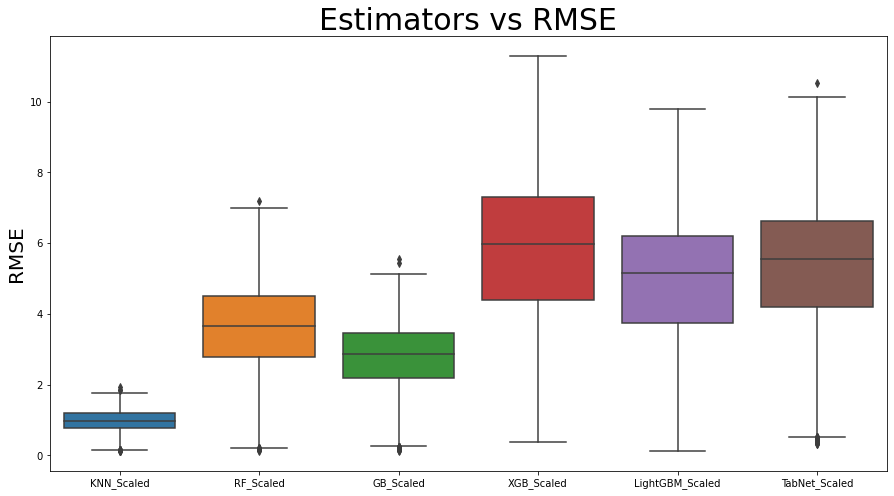

In [ ]:
results_scaled = train_and_test_regressor_local(models_d,
                                            data_width_train.drop(columns=['Element', 'Wavelength', 'Z number']).sample(frac = 1, random_state = 777), np.log(1 + target_width_train.sample(frac = 1, random_state = 777) / epsilon),
                                            data_width_test.drop(columns=['Element', 'Wavelength', 'Z number']), np.log(1 + target_width_test / epsilon),
                                            train = False)
plot_model_comparison(results_scaled)

## Width. Scaled and augmented

Getting KNN_Extended predictions
Getting RF_Extended predictions
Getting GB_Extended predictions
Getting XGB_Extended predictions
Getting LightGBM_Extended predictions
Getting TabNet_Extended predictions

Early stopping occurred at epoch 115 with best_epoch = 95 and best_eval_mse = 0.3114
Plotting KNN_Extended predictions
Plotting RF_Extended predictions
Plotting GB_Extended predictions
Plotting XGB_Extended predictions
Plotting LightGBM_Extended predictions
Plotting TabNet_Extended predictions


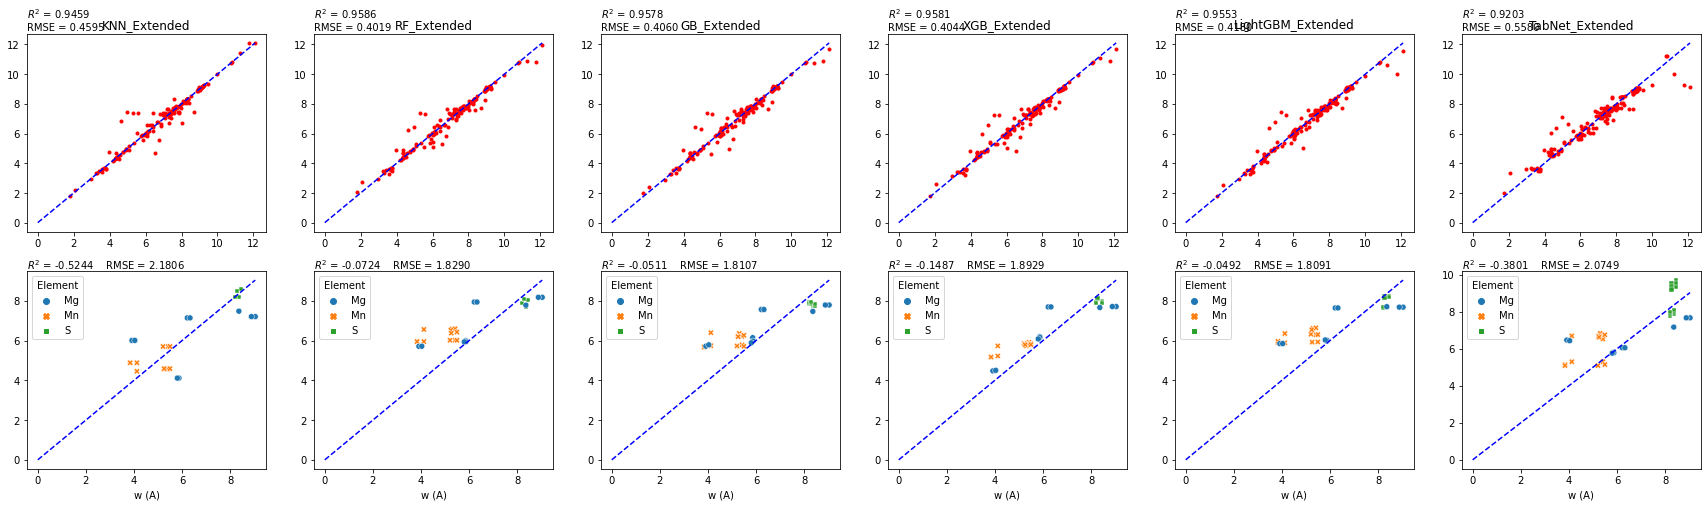

In [ ]:
models = ['KNN_Extended', 'RF_Extended', 'GB_Extended', 'XGB_Extended', 'LightGBM_Extended', 'TabNet_Extended']

models_d = create_models_dict(models)

preds, preds_elem, fix, ax = plot_model_prediction(models_d,
                                                    data_width_train_extended.drop(columns=['Element', 'Wavelength', 'Z number']).sample(frac = 1, random_state = 777), np.log(1 + target_width_train_extended.sample(frac = 1, random_state = 777) / epsilon),
                                                    data_width_test.drop(columns=['Element', 'Wavelength', 'Z number']), np.log(1 + target_width_test / epsilon),
                                                    data_width_elements.drop(columns=['Element', 'Wavelength', 'Z number']), np.log(1 + target_width_elements.sample(frac = 1, random_state = 777) / epsilon), label_width_elements)

In [ ]:
for name, values in preds.items():
    preds[name] = (np.exp(preds[name]) - 1) * epsilon
    preds_elem[name] = (np.exp(preds_elem[name]) -1) * epsilon

Plotting KNN_Extended predictions
Plotting RF_Extended predictions
Plotting GB_Extended predictions
Plotting XGB_Extended predictions
Plotting LightGBM_Extended predictions
Plotting TabNet_Extended predictions


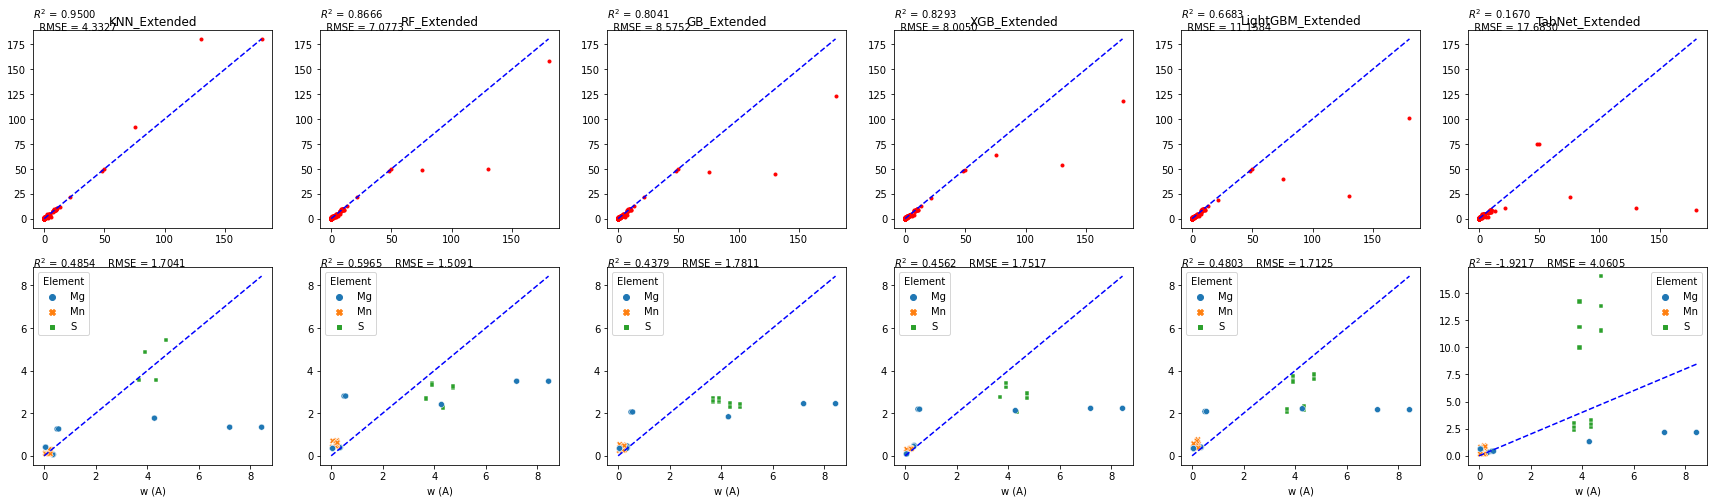

In [ ]:
predictions_elem = {}
R2 = {}
R2_elem = {}
RMSE = {}
RMSE_elem = {}
for name, model in models_d.items():
    y_pred = preds[name]
    R2[name] = r2_score(target_width_test, y_pred)
    RMSE[name] = mean_squared_error(target_width_test, y_pred, squared = False)

    y_pred = preds_elem[name]
    R2_elem[name] = r2_score(target_width_elements, y_pred)
    RMSE_elem[name] = mean_squared_error(target_width_elements, y_pred, squared = False)

    
i = 0
fig, ax = plt.subplots(2, len(models_d), figsize = (5*len(models_d), 4*2))
for name, model in models_d.items():
    print(f'Plotting {name} predictions')
    ax[0, i].plot(target_width_test, preds[name], 'r.')
    ax[0, i].plot([0, np.amax(target_width_test)], [0, np.amax(target_width_test)], color = 'b', ls = '--')
    ax[0, i].set_title(f'{name}')
    #ax[0, i].text(x = 0, y = 1, s = f'$R^2$ = {R2[name]:.4f}', transform = ax[0, i].transAxes)
    ax[0, i].text(x = 0, y = 1, s = f'$R^2$ = {R2[name]:.4f}  \n  RMSE = {RMSE[name]:.4f}',  transform = ax[0, i].transAxes)
    
    #ax[1, i].plot(y_elem, predictions_elem[name], 'r.')
    sns.scatterplot(x = target_width_elements, y = preds_elem[name], ax = ax[1, i], style = label_width_elements['Element'], hue = label_width_elements['Element'])
    ax[1, i].plot([0, np.amax(target_width_elements)], [0, np.amax(target_width_elements)], color = 'b', ls = '--')
    ax[1, i].text(x = 0, y = 1, s = f'$R^2$ = {R2_elem[name]:.4f}    RMSE = {RMSE_elem[name]:.4f}',  transform = ax[1, i].transAxes)
    i += 1
plt.show()

Calculating bootstrap score for KNN_Extended
Calculating bootstrap score for RF_Extended
Calculating bootstrap score for GB_Extended
Calculating bootstrap score for XGB_Extended
Calculating bootstrap score for LightGBM_Extended
Calculating bootstrap score for TabNet_Extended


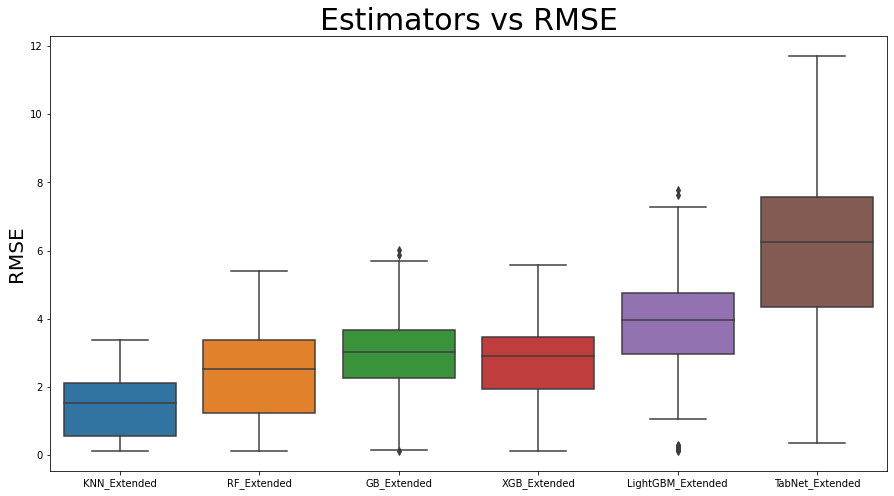

In [ ]:
results_augmented = train_and_test_regressor_local(models_d,
                                                data_width_train_extended.drop(columns=['Element', 'Wavelength', 'Z number']).sample(frac = 1, random_state = 777), np.log(1 + target_width_train_extended.sample(frac = 1, random_state = 777) / epsilon),
                                                data_width_test.drop(columns=['Element', 'Wavelength', 'Z number']), np.log(1 + target_width_test / epsilon),
                                                train = False)
plot_model_comparison(results_augmented)

## Shift

Getting KNN_SHIFT predictions
Getting RF_SHIFT predictions
Getting GB_SHIFT predictions
Getting XGB_SHIFT predictions
Getting LightGBM_SHIFT predictions
Getting TabNet_SHIFT predictions

Early stopping occurred at epoch 154 with best_epoch = 134 and best_eval_mse = 3.12011
Plotting KNN_SHIFT predictions
Plotting RF_SHIFT predictions
Plotting GB_SHIFT predictions
Plotting XGB_SHIFT predictions
Plotting LightGBM_SHIFT predictions
Plotting TabNet_SHIFT predictions


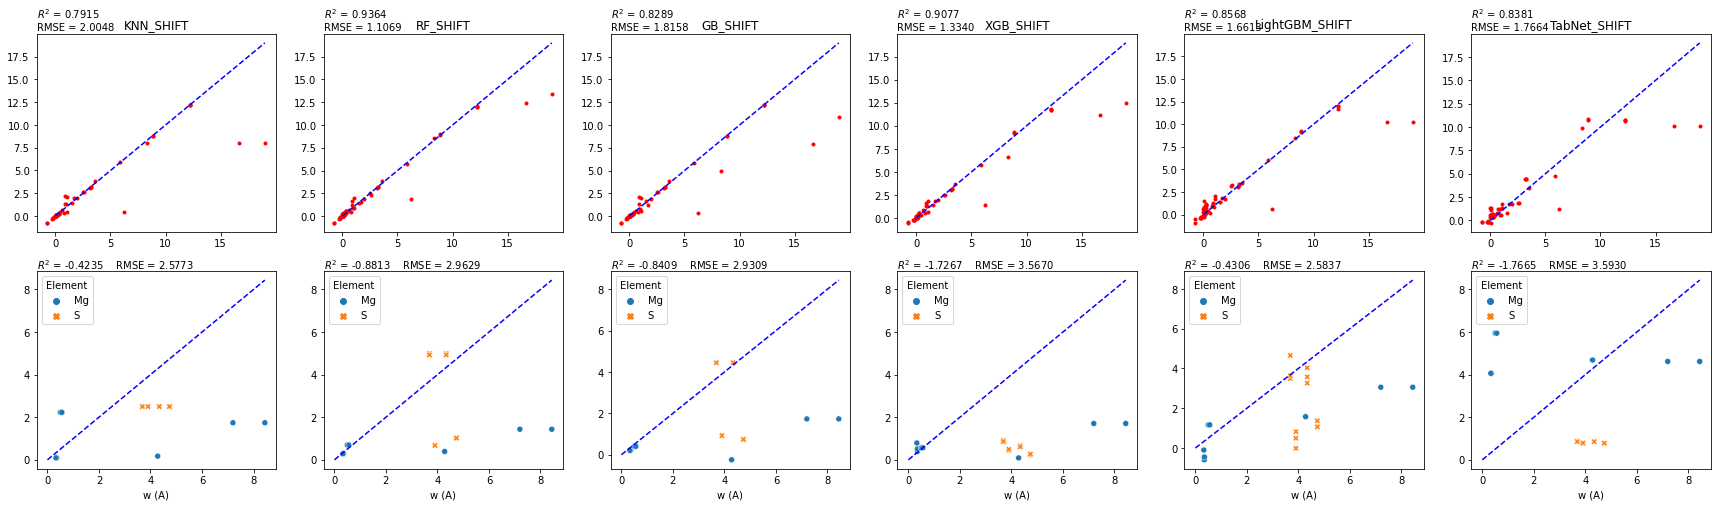

In [ ]:
models = ['KNN_SHIFT', 'RF_SHIFT', 'GB_SHIFT', 'XGB_SHIFT', 'LightGBM_SHIFT', 'TabNet_SHIFT']

models_d = create_models_dict(models)

preds, preds_elem, fix, ax = plot_model_prediction(models_d,
                                                    XS_train, YS_train,
                                                    XS_test, YS_test,
                                                    XS_elem, YS_elem, LS_elem)

Calculating bootstrap score for KNN_SHIFT
Calculating bootstrap score for RF_SHIFT
Calculating bootstrap score for GB_SHIFT
Calculating bootstrap score for XGB_SHIFT
Calculating bootstrap score for LightGBM_SHIFT
Calculating bootstrap score for TabNet_SHIFT


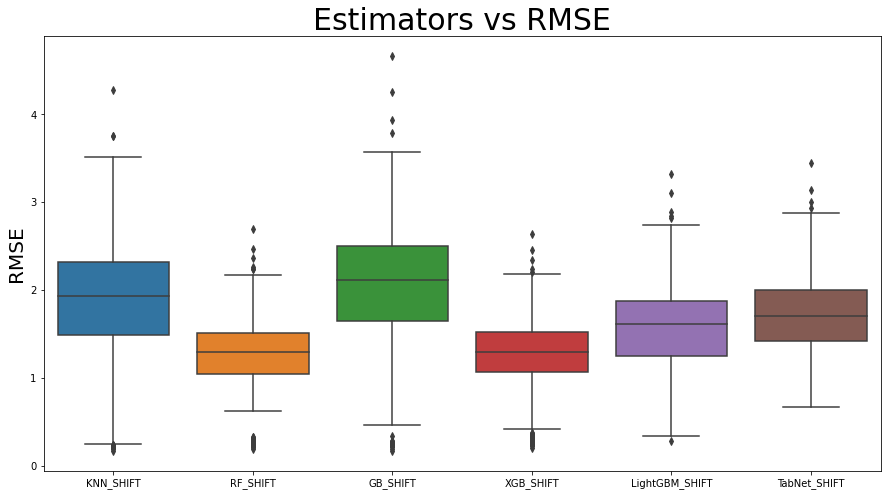

In [ ]:
results_shift = train_and_test_regressor(models_d,
                                        XS_train, YS_train,
                                        XS_test, YS_test,
                                         train = False)
plot_model_comparison(results_shift)

# Temperature dependence

In [ ]:
factor = 1.05                                          #For every item with temperature T in data add two more items with T*factor and T/factor
data_width_extended = data_width.copy()
target_width_extended = target_width
for index, row in data_width.iterrows():
    row['T'] = row['T']*factor
    data_width_extended = pd.concat([data_width_extended, row.to_frame().T], ignore_index=True)
    target_width_extended = pd.concat([target_width_extended, pd.Series(target_width.loc[index])], ignore_index=True)

    row['T'] = row['T']/factor**2
    data_width_extended = pd.concat([data_width_extended, row.to_frame().T], ignore_index=True)
    target_width_extended = pd.concat([target_width_extended, pd.Series(target_width.loc[index])], ignore_index=True)
data_width_extended = data_width_extended.astype(data_width.dtypes.to_dict())
data_width_extended = data_width_extended.drop(columns=['Element', 'Wavelength', 'Z number'])

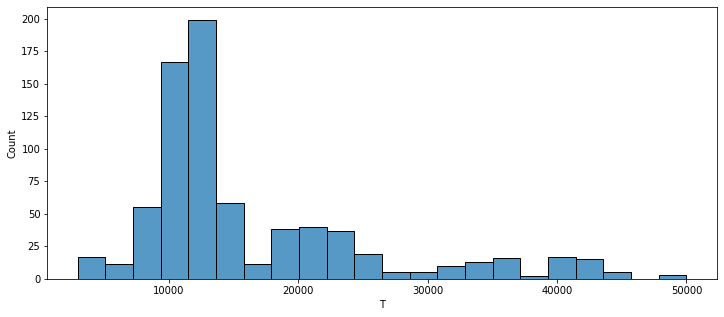

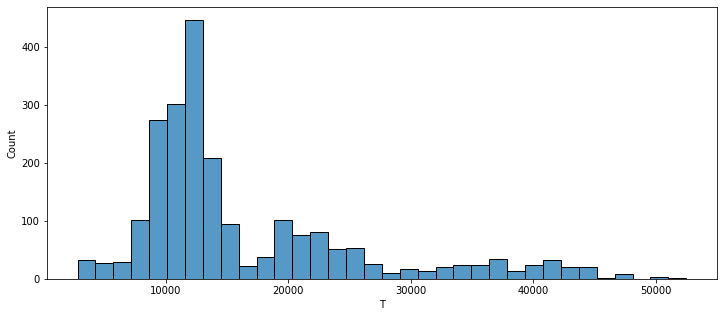

In [ ]:
#Visualise and confirm that augmentation doesn't change overall temperature distribution
fig, ax = plt.subplots(figsize = (12, 5))
sns.histplot(data = data_width_train, x = 'T')
plt.show()

fig, ax = plt.subplots(figsize = (12, 5))
sns.histplot(data = data_width_train_extended, x = 'T')
plt.show()

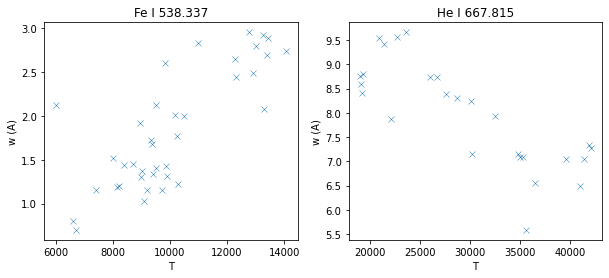

	Points plotted are only original data (without artificial points)


In [ ]:
#Select two lines with the highest number of entries in full dataset
Fe_wavelength = 538.3370
He_wavelength = 667.8150

fig, ax = plt.subplots(1, 2, figsize = (10, 4))
sns.scatterplot(x = data.loc[data['Wavelength'] == Fe_wavelength]['T'], y = data.loc[data['Wavelength'] == Fe_wavelength]['w (A)'], ax = ax[0], marker = 'x')
sns.scatterplot(x = data.loc[data['Wavelength'] == He_wavelength]['T'], y = data.loc[data['Wavelength'] == He_wavelength]['w (A)'], ax = ax[1], marker = 'x')

ax[0].set_title(f'Fe I {Fe_wavelength}')
ax[1].set_title(f'He I {He_wavelength}')

plt.show()

print(f'\tPoints plotted are only original data (without artificial points)')

In [ ]:
#Define temperature range in each case
Fe_low, Fe_high = data.loc[data['Wavelength'] == Fe_wavelength]['T'].describe()['min'], data.loc[data['Wavelength'] == Fe_wavelength]['T'].describe()['max']
He_low, He_high = data.loc[data['Wavelength'] == He_wavelength]['T'].describe()['min'], data.loc[data['Wavelength'] == He_wavelength]['T'].describe()['max']

npoints = 1000
Fe_temperatures = np.linspace(Fe_low, Fe_high, npoints)
He_temperatures = np.linspace(He_low, He_high, npoints)

#Fe_temperatures = np.linspace(5000, 15000, npoints)
#He_temperatures = np.linspace(15000, 45000, npoints)

Fe_unit = data_width.loc[data_width['Wavelength'] == Fe_wavelength][data_width['Wavelength'].duplicated() == False]
He_unit = data_width.loc[data_width['Wavelength'] == He_wavelength][data_width['Wavelength'].duplicated() == False]

for i in range(npoints):
    Fe_unit['T'] = Fe_temperatures[i]
    if i == 0:
        temperature_test_data = Fe_unit
    else:
        temperature_test_data = pd.concat([temperature_test_data, Fe_unit])

for i in range(npoints):
    He_unit['T'] = He_temperatures[i]
    temperature_test_data = pd.concat([temperature_test_data, He_unit])

temperature_test_data = temperature_test_data.drop(columns=['Element', 'Wavelength', 'Z number'])

In [ ]:
models = ['KNN', 'RF', 'XGB', 'LightGBM', 'TabNet']
models_d = create_models_dict(models)

for name, model in models_d.items():
    print(f"Training {name} model")
    if 'TabNet' in name:
        model.fit(data_width_extended, target_width_extended, data_width_test.drop(columns=['Element', 'Wavelength', 'Z number']), target_width_test)
    else:
        model.fit(data_width_extended, target_width_extended)

temperature_test_predictions = {}
for name, model in models_d.items():
    temperature_test_predictions[name] = model.predict(temperature_test_data)

Training KNN model
Training RF model
Training XGB model
Training LightGBM model
Training TabNet model

Early stopping occurred at epoch 21 with best_epoch = 1 and best_eval_mse = 347.26302


In [ ]:
models_extended = ['KNN_Extended', 'RF_Extended', 'XGB_Extended', 'LightGBM_Extended', 'TabNet_Extended']
models_d = create_models_dict(models_extended)

for name, model in models_d.items():
    print(f"Training {name} model")
    if 'TabNet' in name:
        model.fit(data_width_extended, np.log(1 + target_width_extended / epsilon), data_width_test.drop(columns=['Element', 'Wavelength', 'Z number']), np.log(1 + target_width_test / epsilon))
    else:
        model.fit(data_width_extended, np.log(1 + target_width_extended / epsilon))

temperature_test_predictions_extended = {}
for name, model in models_d.items():
    temperature_test_predictions_extended[name] = model.predict(temperature_test_data)

Training KNN_Extended model
Training RF_Extended model
Training XGB_Extended model
Training LightGBM_Extended model
Training TabNet_Extended model

Early stopping occurred at epoch 141 with best_epoch = 121 and best_eval_mse = 0.29094


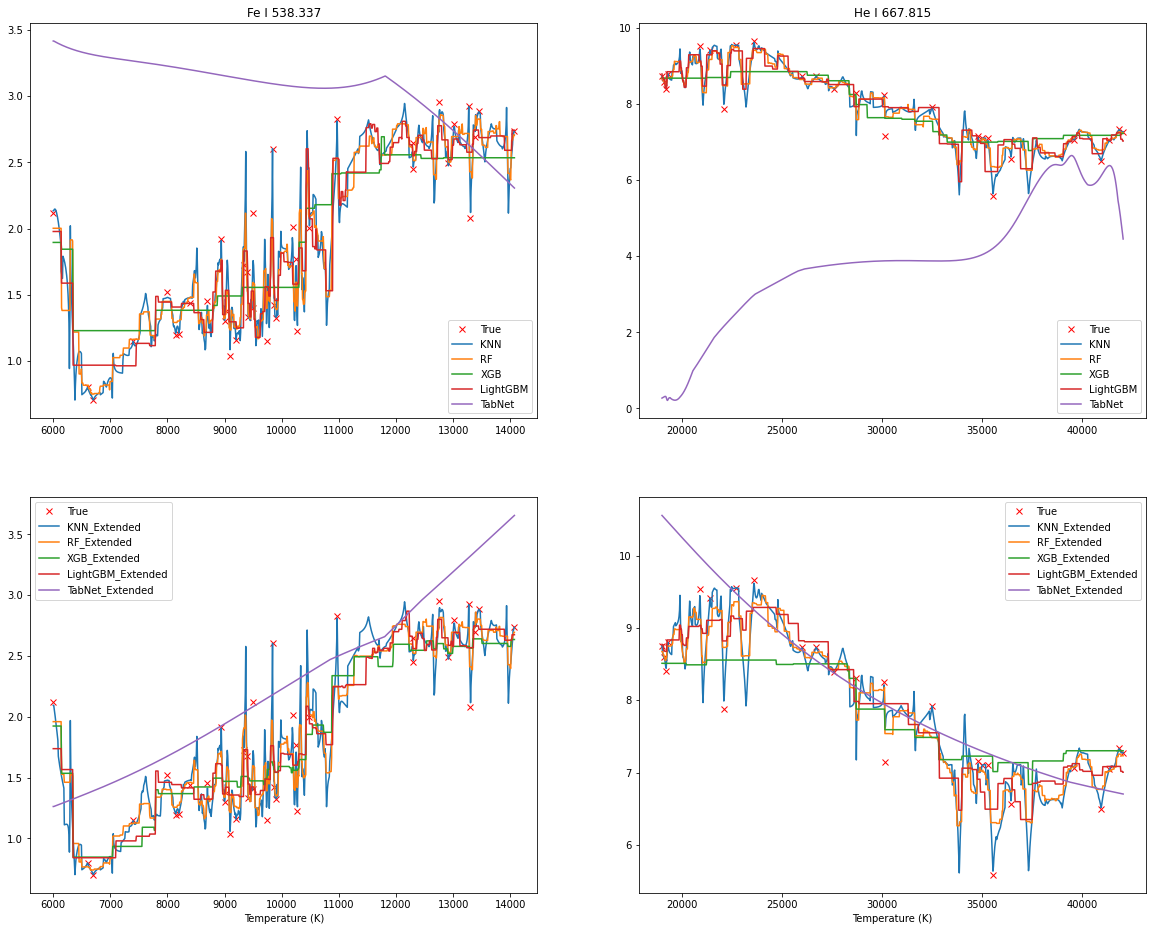

In [ ]:
fig, ax = plt.subplots(2, 2, figsize = (20, 16))
ax[0, 0].plot(data.loc[data['Wavelength'] == Fe_wavelength]['T'], data.loc[data['Wavelength'] == Fe_wavelength]['w (A)'], 'rx', label = 'True')
ax[0, 1].plot(data.loc[data['Wavelength'] == He_wavelength]['T'], data.loc[data['Wavelength'] == He_wavelength]['w (A)'], 'rx', label = 'True')
ax[1, 0].plot(data.loc[data['Wavelength'] == Fe_wavelength]['T'], data.loc[data['Wavelength'] == Fe_wavelength]['w (A)'], 'rx', label = 'True')
ax[1, 1].plot(data.loc[data['Wavelength'] == He_wavelength]['T'], data.loc[data['Wavelength'] == He_wavelength]['w (A)'], 'rx', label = 'True')

for i in range(len(models)):
    ax[0, 0].plot(Fe_temperatures, temperature_test_predictions[models[i]][:1000], label = f'{models[i]}')
    ax[0, 1].plot(He_temperatures, temperature_test_predictions[models[i]][1000:], label = f'{models[i]}')

    ax[1, 0].plot(Fe_temperatures, (np.exp(temperature_test_predictions_extended[models_extended[i]][:1000]) - 1) * epsilon, label = f'{models_extended[i]}')
    ax[1, 1].plot(He_temperatures, (np.exp(temperature_test_predictions_extended[models_extended[i]][1000:]) - 1) * epsilon, label = f'{models_extended[i]}')


ax[0, 0].set_title(f'Fe I {Fe_wavelength}')
ax[0, 1].set_title(f'He I {He_wavelength}')

ax[0, 0].legend()
ax[0, 1].legend()
ax[1, 0].legend()
ax[1, 1].legend()

ax[1, 0].set_xlabel('Temperature (K)')
ax[1, 1].set_xlabel('Temperature (K)')

plt.show()

# Pedicting Stark parameters

In [ ]:
factor = 1.05
data_width_extended = data_width
target_width_extended = target_width
for index, row in data_width.iterrows():
    row['T'] = row['T']*factor
    data_width_extended = data_width_extended.append(row, ignore_index=True, verify_integrity = True)
    target_width_extended = target_width_extended.append(pd.Series(target_width.loc[index]), ignore_index=True)

    row['T'] = row['T']/factor**2
    data_width_extended = data_width_extended.append(row, ignore_index=True, verify_integrity = True)
    target_width_extended = target_width_extended.append(pd.Series(target_width.loc[index]), ignore_index=True)

In [ ]:
models = ['KNN_Extended', 'XGB_Extended', 'TabNet_Extended']
models_d = create_models_dict(models)
epsilon = 1e-3

for name, model in models_d.items():
    print(f"Training {name} model")
    if 'TabNet' in name:
        model.fit(data_width_extended.drop(columns=['Element', 'Wavelength', 'Z number']), np.log(1 + target_width_extended / epsilon), XW_test, np.log(1 + YW_test / epsilon))
    else:
        model.fit(data_width_extended.drop(columns=['Element', 'Wavelength', 'Z number']), np.log(1 + target_width_extended / epsilon))

Training KNN_Extended model
Training XGB_Extended model
[10:57:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training TabNet_Extended model

Early stopping occurred at epoch 126 with best_epoch = 106 and best_eval_mse = 0.17635
Best weights from best epoch are automatically used!


In [ ]:
data_predictions = pd.read_excel('/content/Stark_ML/Source_files/Stark_data.xlsx',
                     sheet_name='Fe_diagnostics',
                     usecols='A:BC'
                   )
data_predictions['Term'] = term_to_number(data_predictions['Term'])
data_predictions['Term.1'] = term_to_number(data_predictions['Term.1'])

In [ ]:
predictions = {}
for name, model in models_d.items():
    predictions[name] = model.predict(data_predictions.drop(columns=['Element', 'Wavelength', 'Z number', 'w (A)', 'd (A)']))

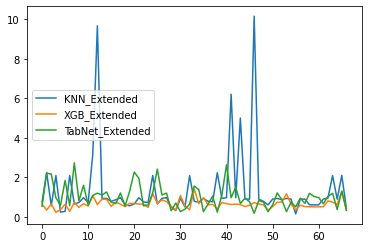

In [ ]:
fig, ax = plt.subplots()
for name, model in predictions.items():
    ax.plot((np.exp(model) - 1) * epsilon, label = f'{name}')

plt.legend()
plt.show()

In [ ]:
predictions['XGB_Extended']

np.savetxt('Fe predictions.csv', (np.exp(predictions['XGB_Extended']) - 1) * epsilon, delimiter = ',')

In [ ]:
data_width_extended.describe()

Wavelength     Z number           1s           2s           2p  \
count  2691.000000  2691.000000  2691.000000  2691.000000  2691.000000   
mean    437.237659    14.851728     1.769231     1.612040     3.460424   
std     216.138500    15.972465     0.421403     0.736961     2.178343   
min     113.416500     2.000000     1.000000     0.000000     0.000000   
25%     283.999000     6.000000     2.000000     2.000000     1.000000   
50%     471.315614     7.000000     2.000000     2.000000     3.000000   
75%     541.520000    26.000000     2.000000     2.000000     6.000000   
max    2058.130000    82.000000     2.000000     2.000000     6.000000   

                3s           3p           3d           4s           4p  ...  \
count  2691.000000  2691.000000  2691.000000  2691.000000  2691.000000  ...   
mean      0.858417     1.943144     2.469342     0.332219     0.749164  ...   
std       0.905386     2.719631     3.993686     0.686838     1.678609  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
50%       1.000000     0.000000     0.000000     0.000000     0.000000  ...   
75%       2.000000     6.000000     7.000000     0.000000     1.000000  ...   
max       2.000000     6.000000    10.000000     2.000000     6.000000  ...   

                8p           8d           9s          10s  Multiplicity.1  \
count  2691.000000  2691.000000  2691.000000  2691.000000     2691.000000   
mean      0.001115     0.002230     0.001115     0.001115        2.899666   
std       0.033377     0.047175     0.033377     0.033377        1.247288   
min       0.000000     0.000000     0.000000     0.000000        1.000000   
25%       0.000000     0.000000     0.000000     0.000000        2.000000   
50%       0.000000     0.000000     0.000000     0.000000        3.000000   
75%       0.000000     0.000000     0.000000     0.000000        4.000000   
max       1.000000     1.000000     1.000000     1.000000        7.000000   

            Term.1     Parity.1          J.1       E upper             T  
count  2691.000000  2691.000000  2691.000000  2.691000e+03   2691.000000  
mean      1.544036     0.603122     1.827202  2.113072e+05  16475.397562  
std       1.311591     0.489341     1.431801  3.324122e+06   9473.849984  
min       0.000000     0.000000     0.000000  1.173231e+04   2809.523810  
25%       1.000000     0.000000     1.000000  5.387426e+04  10500.000000  
50%       1.000000     1.000000     1.500000  8.848342e+04  12500.000000  
75%       2.000000     1.000000     2.000000  1.184278e+05  20265.000000  
max       5.000000     1.000000     7.000000  9.968131e+07  52500.000000  

[8 rows x 52 columns]

# Auxilary functions

In [ ]:
d = pd.read_excel('/content/Stark_ML/Source_files/Stark_data.xlsx',
                     sheet_name='Fe_diagnostics',
                     usecols='BD:BE'
                   )

In [ ]:
with open("insert.txt", "w") as output:
    output.write('insert into starknew (line_id, temp, e_dens, fwhm, alpha, beta, width_ref, shift_ref) \nvalues')
    for index, item in d.iterrows():
        if not np.isnan(item['fwhm']):
            line = f"({item['line_id']}, 7200, 1.0E17, {item['fwhm']}, 0, 0, 19, 19),\n"
            output.write(line)

In [ ]:
with open("delete.txt", "w") as output:
    output.write('delete from starknew where line_id in (')
    for index, item in d.iterrows():
        line = f"{int(item['line_id'])}, "
        output.write(line)
    output.write(')')

# Debugging

In [ ]:
import sklearn
import sklearn.datasets
from sklearn.model_selection import train_test_split

calif_housing = sklearn.datasets.fetch_california_housing()
x = calif_housing.data
y = calif_housing.target
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
x_learn, x_valid, y_learn, y_valid = train_test_split(x_train, y_train, random_state=42)

In [ ]:
from pytorch_tabnet.tab_model import  TabNetRegressor
from warnings import simplefilter
simplefilter("ignore", category=UserWarning)

tabnet = TabNetRegressor()
tabnet.fit(x_learn, y_learn.reshape(-1, 1),
           eval_set = [(x_valid,  y_valid.reshape(-1, 1))])

epoch 0  | loss: 2.51742 | val_0_mse: 125.44913|  0:00:00s
epoch 1  | loss: 0.9442  | val_0_mse: 69.5027 |  0:00:01s
epoch 2  | loss: 0.70522 | val_0_mse: 1.89471 |  0:00:01s
epoch 3  | loss: 0.62883 | val_0_mse: 10.61009|  0:00:02s
epoch 4  | loss: 0.59072 | val_0_mse: 17.51561|  0:00:02s
epoch 5  | loss: 0.55737 | val_0_mse: 2.09436 |  0:00:03s
epoch 6  | loss: 0.52634 | val_0_mse: 5.42873 |  0:00:03s
epoch 7  | loss: 0.50333 | val_0_mse: 3.12888 |  0:00:04s
epoch 8  | loss: 0.47479 | val_0_mse: 4.47762 |  0:00:04s
epoch 9  | loss: 0.46156 | val_0_mse: 5.1585  |  0:00:05s
epoch 10 | loss: 0.44672 | val_0_mse: 3.87746 |  0:00:06s
epoch 11 | loss: 0.44287 | val_0_mse: 11.27014|  0:00:06s
epoch 12 | loss: 0.42907 | val_0_mse: 6.45102 |  0:00:07s

Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_mse = 1.89471


In [ ]:
!nvidia-smi

Mon Mar 27 13:11:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0    50W / 400W |   1383MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import datetime
print(datetime.datetime.now())
predictions = {}
for i in range(100):
    models = [f'TabNet_Extended']
    models_d = create_models_dict(models)
    epsilon = 1e-3

    for name, model in models_d.items():
        print(f"Training {name}_{i} model")
        if 'TabNet' in name:
            model.fit(data_width_extended.drop(columns=['Element', 'Wavelength', 'Z number']), np.log(1 + target_width_extended / epsilon), XW_test, np.log(1 + YW_test / epsilon))
        predictions[f'{name}_{i}'] = model.predict(data_predictions.drop(columns=['Element', 'Wavelength', 'Z number', 'w (A)', 'd (A)']))
print(datetime.datetime.now())

2022-10-07 16:36:48.896124
Training TabNet_Extended_0 model

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 3.04255
Training TabNet_Extended_1 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 77 with best_epoch = 57 and best_eval_mse = 6.12583
Training TabNet_Extended_2 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 79 with best_epoch = 59 and best_eval_mse = 5.84129
Training TabNet_Extended_3 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 95 with best_epoch = 75 and best_eval_mse = 5.75448
Training TabNet_Extended_4 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 5.35698
Training TabNet_Extended_5 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 5.52399
Training TabNet_Extended_6 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 76 with best_epoch = 56 and best_eval_mse = 6.13257
Training TabNet_Extended_7 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 65 with best_epoch = 45 and best_eval_mse = 7.19106
Training TabNet_Extended_8 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 4.58952
Training TabNet_Extended_9 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 8.97335
Training TabNet_Extended_10 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 5.74376
Training TabNet_Extended_11 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 5.5148
Training TabNet_Extended_12 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 4.45584
Training TabNet_Extended_13 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 4.08152
Training TabNet_Extended_14 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 5.10881
Training TabNet_Extended_15 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 5.77577
Training TabNet_Extended_16 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 6.30728
Training TabNet_Extended_17 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 8.08837
Training TabNet_Extended_18 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 4.25321
Training TabNet_Extended_19 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 5.85513
Training TabNet_Extended_20 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 5.95309
Training TabNet_Extended_21 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 3.52942
Training TabNet_Extended_22 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 75 with best_epoch = 55 and best_eval_mse = 6.17833
Training TabNet_Extended_23 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 5.19966
Training TabNet_Extended_24 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 7.48535
Training TabNet_Extended_25 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 82 with best_epoch = 62 and best_eval_mse = 4.3064
Training TabNet_Extended_26 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 5.91902
Training TabNet_Extended_27 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 65 with best_epoch = 45 and best_eval_mse = 6.61379
Training TabNet_Extended_28 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 3.43085
Training TabNet_Extended_29 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 4.20461
Training TabNet_Extended_30 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 4.57072
Training TabNet_Extended_31 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 6.61023
Training TabNet_Extended_32 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 100 with best_epoch = 80 and best_eval_mse = 6.32855
Training TabNet_Extended_33 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 86 with best_epoch = 66 and best_eval_mse = 4.89149
Training TabNet_Extended_34 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 5.05503
Training TabNet_Extended_35 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 3.2417
Training TabNet_Extended_36 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 7 and best_eval_mse = 5.03381
Training TabNet_Extended_37 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 91 with best_epoch = 71 and best_eval_mse = 5.31025
Training TabNet_Extended_38 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 30 with best_epoch = 10 and best_eval_mse = 4.81982
Training TabNet_Extended_39 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 4.59477
Training TabNet_Extended_40 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 2.93886
Training TabNet_Extended_41 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 5.6699
Training TabNet_Extended_42 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 104 with best_epoch = 84 and best_eval_mse = 6.14118
Training TabNet_Extended_43 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 5.2026
Training TabNet_Extended_44 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 4.44702
Training TabNet_Extended_45 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 4.17587
Training TabNet_Extended_46 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 3.04255
Training TabNet_Extended_47 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 3.01732
Training TabNet_Extended_48 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 4.59477
Training TabNet_Extended_49 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 85 with best_epoch = 65 and best_eval_mse = 4.65963
Training TabNet_Extended_50 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 4.43146
Training TabNet_Extended_51 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 6.49016
Training TabNet_Extended_52 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 3.97446
Training TabNet_Extended_53 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 3.98373
Training TabNet_Extended_54 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 3.67056
Training TabNet_Extended_55 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 3.82365
Training TabNet_Extended_56 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 4.14496
Training TabNet_Extended_57 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 5.79771
Training TabNet_Extended_58 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 3.34682
Training TabNet_Extended_59 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 6.45926
Training TabNet_Extended_60 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 76 with best_epoch = 56 and best_eval_mse = 3.37794
Training TabNet_Extended_61 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 92 with best_epoch = 72 and best_eval_mse = 6.2687
Training TabNet_Extended_62 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 145 with best_epoch = 125 and best_eval_mse = 6.15393
Training TabNet_Extended_63 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 62 with best_epoch = 42 and best_eval_mse = 2.101
Training TabNet_Extended_64 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 1.7955
Training TabNet_Extended_65 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 4.57262
Training TabNet_Extended_66 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 4.43933
Training TabNet_Extended_67 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 2.93886
Training TabNet_Extended_68 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 4.75868
Training TabNet_Extended_69 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 86 with best_epoch = 66 and best_eval_mse = 5.00476
Training TabNet_Extended_70 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 4.37823
Training TabNet_Extended_71 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 4.70403
Training TabNet_Extended_72 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 4.29617
Training TabNet_Extended_73 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 2.9218
Training TabNet_Extended_74 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 4.14496
Training TabNet_Extended_75 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 3.04255
Training TabNet_Extended_76 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 62 with best_epoch = 42 and best_eval_mse = 3.04172
Training TabNet_Extended_77 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 5.44043
Training TabNet_Extended_78 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 3.18843
Training TabNet_Extended_79 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 4.65368
Training TabNet_Extended_80 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 3.86164
Training TabNet_Extended_81 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 82 with best_epoch = 62 and best_eval_mse = 4.83234
Training TabNet_Extended_82 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 73 with best_epoch = 53 and best_eval_mse = 2.68887
Training TabNet_Extended_83 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 3.64052
Training TabNet_Extended_84 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 8.56167
Training TabNet_Extended_85 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 3.46708
Training TabNet_Extended_86 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 5.1177
Training TabNet_Extended_87 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 134 with best_epoch = 114 and best_eval_mse = 6.37954
Training TabNet_Extended_88 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 30 with best_epoch = 10 and best_eval_mse = 3.8318
Training TabNet_Extended_89 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 3.47013
Training TabNet_Extended_90 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 100 with best_epoch = 80 and best_eval_mse = 6.32855
Training TabNet_Extended_91 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 4.91101
Training TabNet_Extended_92 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 6.65984
Training TabNet_Extended_93 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 4.58952
Training TabNet_Extended_94 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 10.76688
Training TabNet_Extended_95 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 9.29159
Training TabNet_Extended_96 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 5.08264
Training TabNet_Extended_97 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 7.18283
Training TabNet_Extended_98 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 3.82056
Training TabNet_Extended_99 model


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 5.81753
2022-10-07 16:44:36.530796


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
import pickle
with open('100 Predictions.pkl', 'wb') as f:
    pickle.dump(predictions, f)

In [ ]:
from IGTD.Scripts.IGTD_Functions import *

In [ ]:
norm_data = min_max_transform(XW_train.to_numpy())

ranking, corr = generate_feature_distance_ranking(norm_data)

pix = generate_matrix_distance_ranking(5, 10)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


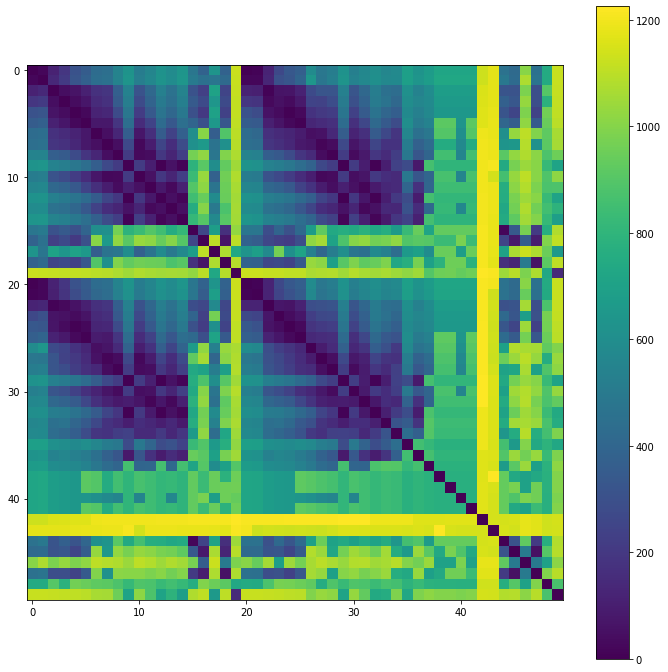

In [ ]:
%matplotlib inline
plt.figure(figsize= (12,12))
plt.imshow(ranking)
plt.colorbar()
plt.show()

In [ ]:
index_record, err_record, run_time = IGTD_square_error(ranking, pix[1], file_name = 'Resss', save_folder = 'content')

Step 0 err: 257691010.5
Step 1 err: 255832285.5
Step 2 err: 246399922.5
Step 3 err: 239328368.5
Step 4 err: 235608396.0
Step 5 err: 232484304.0
Step 6 err: 232088886.0
Step 7 err: 229477898.0
Step 8 err: 227306473.5
Step 9 err: 224024455.5
Step 10 err: 222188044.5
Step 11 err: 221507323.5
Step 12 err: 217669354.5
Step 13 err: 216178668.5
Step 14 err: 210966114.5
Step 15 err: 203040724.5
Step 16 err: 202499243.5
Step 17 err: 201651613.0
Step 18 err: 199403221.5
Step 19 err: 193175922.0
Step 20 err: 189309448.0
Step 21 err: 188777974.0
Step 22 err: 183403447.5
Step 23 err: 179634477.5
Step 24 err: 175187853.5
Step 25 err: 174028828.5
Step 26 err: 166774797.5
Step 27 err: 162546831.0
Step 28 err: 161998117.5
Step 29 err: 161801355.5
Step 30 err: 159855898.0
Step 31 err: 159066295.0
Step 32 err: 154391907.0
Step 33 err: 147493713.5
Step 34 err: 145762498.5
Step 35 err: 141129923.5
Step 36 err: 140800367.5
Step 37 err: 140212771.0
Step 38 err: 139902695.0
Step 39 err: 136925639.0
Step 40 er

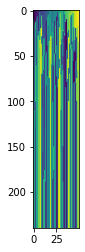

In [ ]:
table_to_image(norm_data, [5, 10], 'Pearson', 'Euclidean', save_image_size = )

In [ ]:
models = ['TabNet_Scaled']
models_d = create_models_dict(models)

for name, models in models_d.items():
    print(f'Fitting model {name}')
    model.fit(XW_train, YW_train)

type(models_d['TabNet_Scaled'])

Fitting model TabNet_Scaled


ValueError: ignored

In [ ]:
%debug

> /usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py(765)check_array()
    763                     "Reshape your data either using array.reshape(-1, 1) if "
    764                     "your data has a single feature or array.reshape(1, -1) "
--> 765                     "if it contains a single sample.".format(array)
    766                 )
    767             # If input is 1D raise error

ipdb> q


In [ ]:
LW_elem

Element  Wavelength
2        Mg   518.36043
3        Mg   517.26844
4        Mg   516.73213
5        Mn   403.07530
6        Mn   403.30620
7        Mn   403.44830
8        Mn   279.48170
9        Mn   279.82690
10       Mn   280.10810
11       Mn   404.13550
12       Mn   404.87430
13       Mn   405.55440
14       Mn   357.78680
15       Mn   478.34270
16       Mn   482.35240
587       S   469.41130
588       S   469.41130
589       S   469.54430
590       S   469.54430
591       S   469.62520
592       S   469.62520
593       S   527.81280
594       S   527.81280
595       S   527.87000
596       S   527.87000
597       S   527.89930
598       S   527.89930
730      Mg   552.84100
731      Mg   470.29900
732      Mg   470.29900
733      Mg   291.54500
734      Mg   291.54500
735      Mg   285.21300
736      Mg   285.21300

Fitting KNN
Fitting RF
Fitting GB
Fitting XGB
[11:04:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fitting TabNet

Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 386.1548
Best weights from best epoch are automatically used!
Fitting LightGBM
Calculating bootstrap score for KNN
Calculating bootstrap score for RF
Calculating bootstrap score for GB
Calculating bootstrap score for XGB
Calculating bootstrap score for TabNet
Calculating bootstrap score for LightGBM


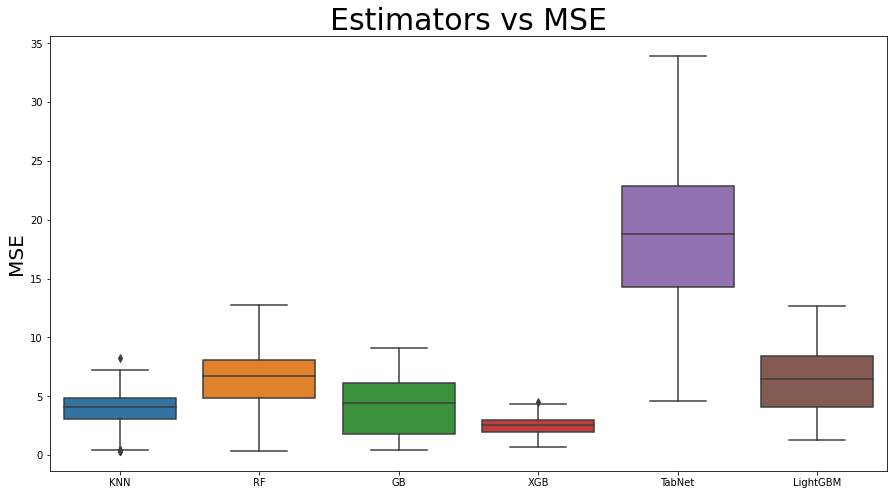

In [ ]:
models = ['KNN', 'RF', 'GB', 'XGB', 'TabNet', 'LightGBM']

models_d = create_models_dict(models)

tuned_results = train_and_test_regressor(models_d, XW_train, YW_train, XW_test, YW_test)

plot_model_comparison(tuned_results)

In [ ]:
%debug

> /content/Stark_ML/models/base_models.py(146)__init__()
    144         super().__init__(params)
    145 
--> 146         self.model = GradientBoostingRegressor(**params)
    147 
    148         self.params = params

ipdb> params
{'learning_rate': 0.46045263398094544, 'num_leaves': 227, 'reg_alpha': 3.275388510467362e-08, 'reg_lambda': 0.20393450817425327}
ipdb> model
*** NameError: name 'model' is not defined
ipdb> q



PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.7/bdb.py", line 357, in set_quit
    sys.settrace(None)



[16:19:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

 XGB model: 7.652456533356582
GB model 11.978170490764201
[16:19:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

 XGB model: 85.67093351905685
GB model 67.74644926737481
[16:19:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

 XGB model: 1.871245347868278
GB model 48.14135844210374
[16:19:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

 XGB model: 2.3040662820980895
GB model 2.5558378882546395
[16:19:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

 XGB model: 1.6383731338990246
GB model 2.1933960069613687

 XGB score 19.827414963255766
GB score 26.52304241909175
{'GB': Gradi

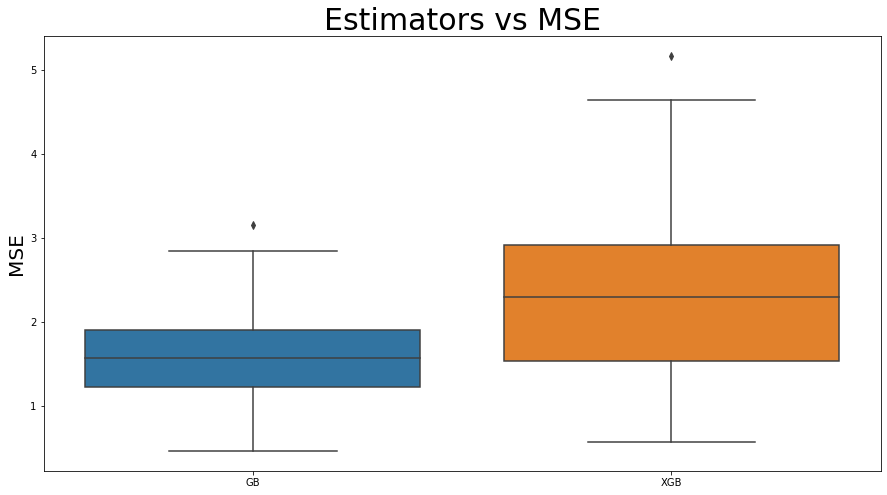

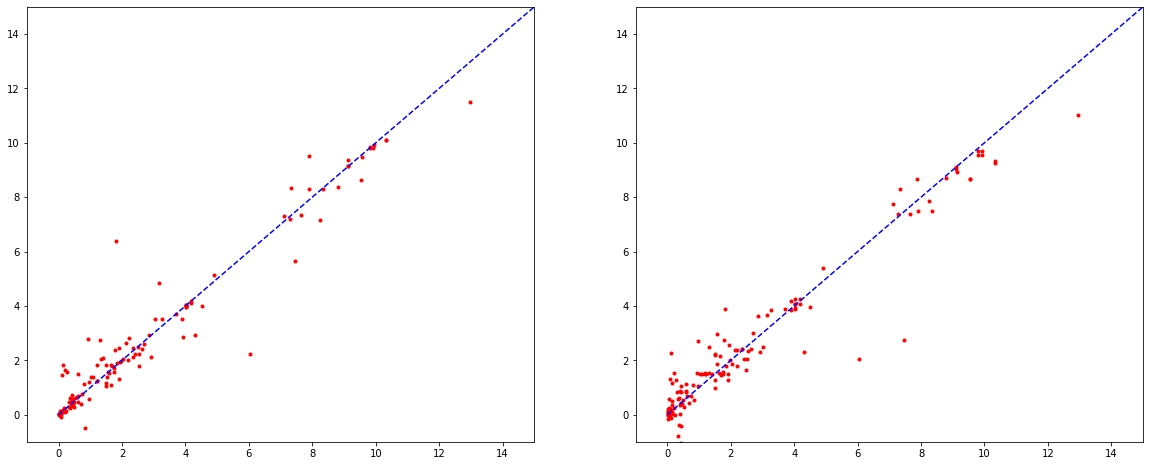

GB MSE: 2.699773000606855
XGB MSE: 5.888925800005179


In [ ]:
nfolds = 5
#kf = KFold(nfolds, shuffle = True, random_state=7)
kf = KFold(nfolds, shuffle = False)
score_XGB = 0
score_GB = 0

with open(path + f'/GB' + '_optimal_parameters', 'r') as fp:
    GB_params = json.load(fp)
with open(path + f'/XGB' + '_optimal_parameters', 'r') as fp:
    XGB_params = json.load(fp)

for train, test in kf.split(XW_train):
    #print(XW_train.iloc[test, :])
    #print(YW_train.iloc[test])
    #break

    model_XGB = xgboost.XGBRegressor(**XGB_params, n_estimators = 500, n_jobs = -1)
    model_GB = GradientBoostingRegressor(**GB_params, n_estimators = 500)
    
    model_XGB.fit(XW_train.iloc[train, :], YW_train.iloc[train])
    model_GB.fit(XW_train.iloc[train, :], YW_train.iloc[train])
    
    score_XGB += mean_squared_error(YW_train.iloc[test], model_XGB.predict(XW_train.iloc[test, :]),
                                squared = True)
    score_GB += mean_squared_error(YW_train.iloc[test], model_GB.predict(XW_train.iloc[test, :]),
                                squared = True)
    print('\n', 'XGB model:', mean_squared_error(YW_train.iloc[test], model_XGB.predict(XW_train.iloc[test, :]),
                                squared = True))
    print('GB model', mean_squared_error(YW_train.iloc[test], model_GB.predict(XW_train.iloc[test, :]),
                                squared = True))
score_XGB /= nfolds
score_GB /= nfolds

print(f"\n XGB score {score_XGB}")
print(f"GB score {score_GB}")

models = {
    'GB' : model_GB,
    'XGB' : model_XGB
}
print(models)
rrr = train_and_test_regressor(models,
                               XW_train,
                               YW_train,
                               XW_test.sample(frac = 1, random_state = 777),
                               YW_test.sample(frac = 1, random_state = 777))
plot_model_comparison(rrr)

fig, ax = plt.subplots(1, 2, figsize = (20, 8))
ax[0].plot(YW_test, model_GB.predict(XW_test), 'r.')
ax[1].plot(YW_test, model_XGB.predict(XW_test), 'r.')
for i in ax:
    i.plot([0, 170], [0, 170], color = 'b', ls = '--')
    i.set_xlim(-1, 15)
    i.set_ylim(-1, 15)
plt.show()


print(f'GB MSE: {mean_squared_error(YW_test, model_GB.predict(XW_test))}')
print(f'XGB MSE: {mean_squared_error(YW_test, model_XGB.predict(XW_test))}')


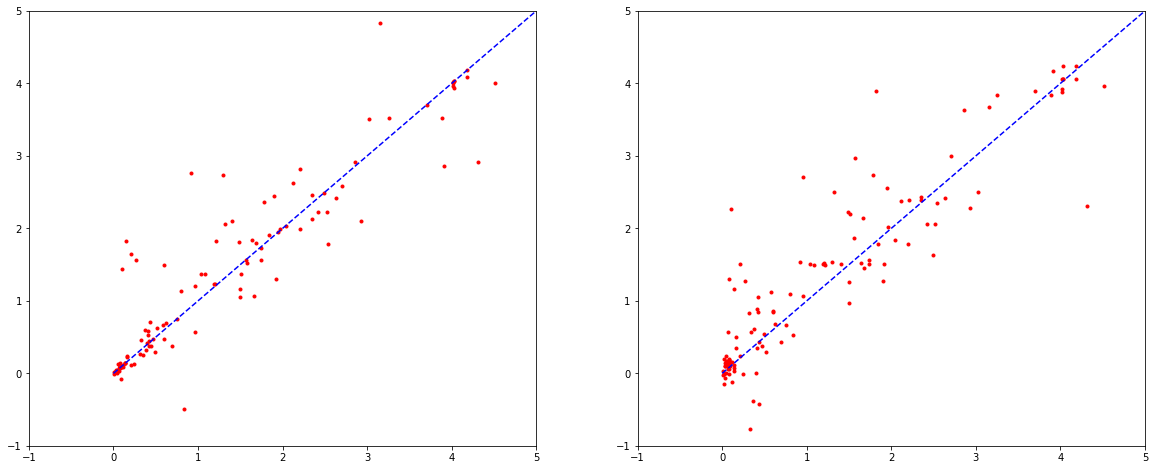

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (20, 8))
ax[0].plot(YW_test, model_GB.predict(XW_test), 'r.')
ax[1].plot(YW_test, model_XGB.predict(XW_test), 'r.')
for i in ax:
    i.plot([0, 170], [0, 170], color = 'b', ls = '--')
    i.set_xlim(-1, 5)
    i.set_ylim(-1, 5)
plt.show()

In [ ]:
models = ['KNN', 'RF', 'GB', 'XGB', 'TabNet']

models_d = create_models_dict(models)

In [ ]:
print(models_d.items())

TypeError: ignored

In [ ]:
abc = np.array([2, 3, 4])
abc = abc.flatten()
abc.shape

(3,)